# Generative Adversarial Network (GAN)

![](https://nbviewer.jupyter.org/github/hse-aml/intro-to-dl/blob/master/week4/images/gan.png)

Пришло время поговорить о более интересных архитектурах, а именно о GANах или состязательных нейронных сетках. [Впервые GANы были предложены в 2014 году.](https://arxiv.org/abs/1406.2661) Сейчас они очень активно исследуются. GANы состоят из двух нейронных сетей: 

* Первая - генератор порождает из некоторого заданного распределения случайные числа и собирает из них объекты, которые идут на вход второй сети. 
* Вторая - дискриминатор получает на вход объекты из реальной выборки и объекты, созданные генератором. Она пытается определить какой объект был порождён генератором, а какой является реальным.

Таким образом генератор пытается создавать объекты, которые дискриминатор не сможет отличить от реальных. 

In [1]:
import tensorflow as tf
print(tf.__version__)

2.0.0


In [2]:
import numpy as np
import time 

import matplotlib.pyplot as plt
%matplotlib inline

# 1. Данные

Для начала давайте попробуем погонять модели на рукописных цифрах из MNIST как бы скучно это не было. 

In [3]:
(X, _ ), (_, _) = tf.keras.datasets.mnist.load_data()

In [4]:
X = X/127.5 - 1 # отнормировали данные на отрезок [-1, 1]

In [5]:
X.min(), X.max()  # проверили нормировку

(-1.0, 1.0)

In [6]:
# наша ламповый датасет из Cимпсонов
X = X[:,:,:,np.newaxis]
X.shape

(60000, 28, 28, 1)

Давайте вытащим несколько рандомных картинок и нарисуем их.

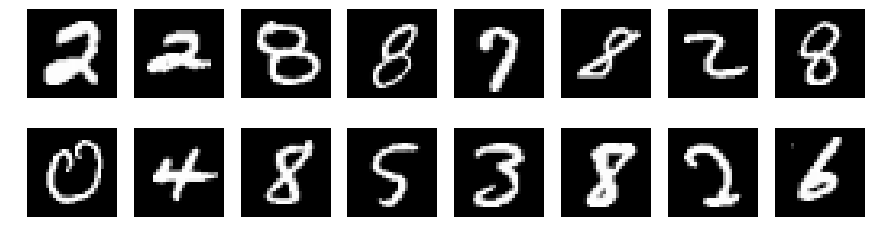

In [7]:
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, X.shape[0])
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid(False)
        ax.axis('off')
        ax.imshow(np.squeeze(X,-1)[random_index, :], cmap='gray')
plt.show()

Соберём для наших данных удобный генератор. 

# 2. Дискриминатор 

* Дискриминатор - это обычная свёрточная сетка 
* Цель этой сетки - отличать сгенерированные изображения от реальных

In [8]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers as L
from tensorflow.keras import layers

In [9]:
IMG_SHAPE = X.shape[1:]

In [10]:
discriminator = Sequential()

discriminator.add(L.Conv2D(64, kernel_size=(5,5), 
                           strides=(2, 2), padding='same', 
                           input_shape=IMG_SHAPE))
discriminator.add(L.BatchNormalization())
discriminator.add(L.LeakyReLU())

discriminator.add(L.Conv2D(128, kernel_size=(5,5), 
                           strides=(2, 2), padding='same'))
discriminator.add(L.BatchNormalization())
discriminator.add(L.LeakyReLU())

discriminator.add(L.Flatten())

# на выход из дискриминатора мы забираем логарифм, а не вероятность 
discriminator.add(L.Dense(2, activation=tf.nn.log_softmax))

# 3. Генератор

* Генерирует из шума изображения 

Будем генерировать новых Симпсонов из шума размера 256.

In [11]:
CODE_SIZE = 100

In [34]:
generator = Sequential()

generator.add(L.InputLayer([CODE_SIZE],name='noise'))

generator.add(L.Dense(256*7*7, activation='elu'))
generator.add(L.Reshape((7,7,256)))

generator.add(L.Conv2DTranspose(128, kernel_size=(3,3)))
generator.add(L.LeakyReLU())

generator.add(L.Conv2DTranspose(64, kernel_size=(3,3)))
generator.add(L.LeakyReLU())

generator.add(L.UpSampling2D(size=(2,2)))
generator.add(L.Conv2DTranspose(32,kernel_size=3,activation='relu'))
generator.add(L.Conv2DTranspose(32,kernel_size=3,activation='relu'))
generator.add(L.Conv2DTranspose(32,kernel_size=3,activation='relu'))

generator.add(L.Conv2D(1, kernel_size=3, padding='same'))

print('Выход генератора: ', generator.output_shape[1:])

Выход генератора:  (28, 28, 1)


Посмотрим на пример, который нам генерирует на выход наша свежая нейронка! 

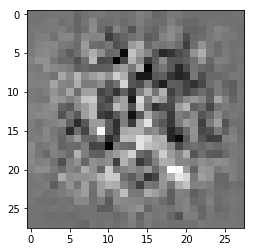

In [35]:
noise = tf.random.normal([1, CODE_SIZE])
generated_image = generator(noise)

plt.imshow(generated_image[0, :, :, 0], cmap='gray');

Хммм... А что про это всё думает дескриминатор?

In [36]:
decision = discriminator(generated_image)

# на выход из дискриминатора мы забираем логарифм!
tf.nn.softmax(decision)

<tf.Tensor: id=21490, shape=(1, 2), dtype=float32, numpy=array([[0.54777384, 0.45222616]], dtype=float32)>

# 4. Функция потерь 

Потери для дескриминатора это обычныя кросс-энтропия.

In [37]:
def discriminator_loss(logp_real, logp_gen):
    d_loss = -tf.reduce_mean(logp_real[:,1] + logp_gen[:,0])
    
    # немного регуляризации, чтобы не запомнить базовую выборку
    d_loss += tf.reduce_mean(discriminator.layers[-1].kernel**2)
    return d_loss

In [38]:
real_log = discriminator(X[:1])
gen_log = discriminator(generated_image)

discriminator_loss(real_log, gen_log)

<tf.Tensor: id=21600, shape=(), dtype=float32, numpy=0.8132905>

Для генератора мы хотим максимизировать ошибку дискриминатора на фэйковых примерах. 

In [39]:
def generator_loss(logp_gen):
    return tf.reduce_mean(logp_gen[:,0])

In [40]:
generator_loss(gen_log)

<tf.Tensor: id=21606, shape=(), dtype=float32, numpy=-0.6018928>

# 5. Градиентный спуск

Учить пару из сеток будем так: 

* Делаем $k$ шагов обучения дискриминатора. Целевая переменная - реальный объект перед нами или порождённый. Веса изменяем стандартно, пытаясь уменьшить кросс-энтропию.
* Делаем $m$ шагов обучения генератора. Веса внутри сетки меняем так, чтобы увеличить логарифм вероятности дискриминатора присвоить сгенерированному объекту лэйбл реального. 
* Обучаем итеративно до тех пор, пока дискриминатор больше не сможет найти разницу (либо пока у нас не закончится терпение).
* При обучении может возникнуть огромное количество пробем от взрыва весов до более тонких вещей. Имеет смысл посмотреть на разные трюки, используемые при обучении:  https://github.com/soumith/ganhacks

Собираем структуру для обучения.

In [41]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
#discriminator_optimizer = tf.keras.optimizers.SGD(1e-3)

Чекпойнты для процесса обучения.

In [42]:
import os 
checkpoint_dir = './training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

Задаём один шаг процедуры обучения генератора.

In [43]:
@tf.function
def train_generator_step(images, noise):

    # ищем градиенты 
    with tf.GradientTape() as gen_tape:
        
        # сгенерировали новое изображение из шума
        generated_images = generator(noise)
        
        # посчитали прогнозы дискриминатора
        real_output = discriminator(images)
        fake_output = discriminator(generated_images)
        
        # нашли ошибку
        gen_loss = generator_loss(fake_output)
        
    # нашли градиенты
    grad = gen_tape.gradient(gen_loss, generator.trainable_variables)
        
    # сделали шаг градиентного спуска 
    generator_optimizer.apply_gradients(zip(grad, generator.trainable_variables))
    pass

Теперь шаг обучения дискриминатора. 

In [44]:
@tf.function
def train_discriminator_step(images, noise):
    
    # ищем градиенты 
    with tf.GradientTape() as disc_tape:
        
        # сгенерировали новое изображение из шума
        generated_images = generator(noise)
        
        # посчитали прогнозы дискриминатора
        real_output = discriminator(images)
        fake_output = discriminator(generated_images)
        
        # нашли ошибку
        disc_loss = discriminator_loss(real_output, fake_output)
        
    # нашли градиенты
    grad = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        
    # сделали шаг градиентного спуска 
    discriminator_optimizer.apply_gradients(zip(grad, discriminator.trainable_variables))
    pass

Мы почти готовы учить нашу сетку. Напишем две простенькие функции для генерации фэйковых и настоящих батчей. 

In [45]:
# функция, которая генерирует батч с шумом
def sample_noise_batch(bsize):
    return tf.random.normal([bsize, CODE_SIZE], dtype=tf.float32)


# функция, которая генерирует батч из реальных данных (для баловства)
def sample_data_batch(bsize):
    idxs = np.random.choice(np.arange(X.shape[0]), size=bsize)
    return X[idxs]


Проверяем отрабатывают ли наши шаги.

In [46]:
data_test = sample_data_batch(256)
fake_test = sample_noise_batch(256)

gen_log = discriminator(generator(fake_test))
real_log = discriminator(data_test)

print('Ошибка дескриминатора:', discriminator_loss(real_log, gen_log).numpy())
print('Ошибка генератора:', generator_loss(gen_log).numpy())

Ошибка дескриминатора: 0.8252746
Ошибка генератора: -0.6021314


In [47]:
# сделали шаг работы генератора
train_generator_step(data_test, fake_test)

gen_log = discriminator(generator(fake_test))
real_log = discriminator(data_test)

print('Ошибка дескриминатора:', discriminator_loss(real_log, gen_log).numpy())
print('Ошибка генератора:', generator_loss(gen_log).numpy())

Ошибка дескриминатора: 0.8301182
Ошибка генератора: -0.6069749


In [48]:
# сделали шаг работы дискриминатора
train_discriminator_step(data_test, fake_test)

gen_log = discriminator(generator(fake_test))
real_log = discriminator(data_test)

print('Ошибка дескриминатора:', discriminator_loss(real_log, gen_log).numpy())
print('Ошибка генератора:', generator_loss(gen_log).numpy())

Ошибка дескриминатора: 0.8209005
Ошибка генератора: -0.605849


Как думаете, выглядит адекватно? Мы нигде не ошиблись? 

Напишем пару вспомогательных функций для отрисовки картинок. 

In [49]:
# рисуем изображения
def sample_images(rows, cols, num=0):
    images = generator.predict(sample_noise_batch(bsize=rows*cols))
    
    fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
    for i in range(cols):
        for j in range(rows):
            ax = fig.add_subplot(rows, cols, i * rows + j + 1)
            ax.grid('off')
            ax.axis('off')
            ax.imshow(np.squeeze(images[i * rows + j],-1),cmap='gray')
    
    # сохраняем картинку для гифки
    if num >0:
        plt.savefig('images_gan/image_at_epoch_{:04d}.png'.format(num))
    plt.show()
    
# рисуем распределения
def sample_probas(X):
    plt.title('Generated vs real data')
    
    plt.hist(np.exp(discriminator.predict(X))[:,1],
             label='D(x)', alpha=0.5,range=[0,1])
    
    plt.hist(np.exp(discriminator.predict(generator.predict(sample_noise_batch(X.shape[0]))))[:,1],
             label='D(G(z))',alpha=0.5,range=[0,1])
    
    plt.legend(loc='best')
    plt.show()
    

/usr/local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


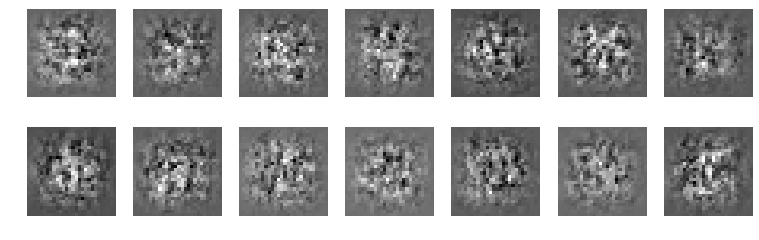

In [50]:
sample_images(2,7)

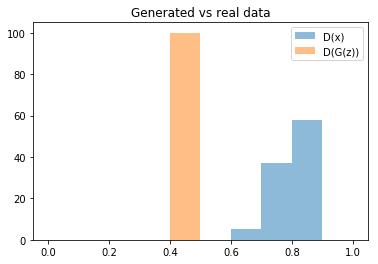

In [51]:
sample_probas(X[:100]) 

Немного побалуемся с шагами. 

In [52]:
data_test = sample_data_batch(256)
fake_test = sample_noise_batch(256)

# Генератор
train_generator_step(data_test, fake_test)

gen_log = discriminator(generator(fake_test))
real_log = discriminator(data_test)

print('Ошибка дескриминатора:', discriminator_loss(real_log, gen_log).numpy())
print('Ошибка генератора:', generator_loss(gen_log).numpy())

Ошибка дескриминатора: 0.8265162
Ошибка генератора: -0.60958564


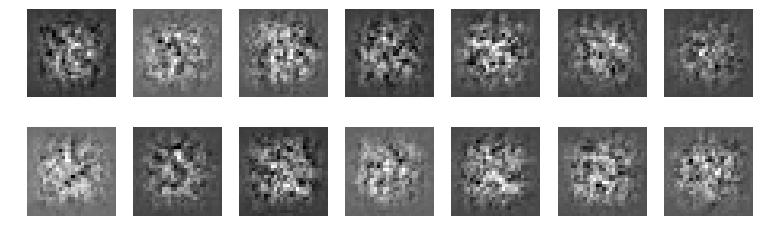

In [53]:
sample_images(2,7)

In [54]:
data_test = sample_data_batch(256)
fake_test = sample_noise_batch(256)

# Дискриминатор
train_discriminator_step(data_test, fake_test)

gen_log = discriminator(generator(fake_test))
real_log = discriminator(data_test)

print('Ошибка дескриминатора:', discriminator_loss(real_log, gen_log).numpy())
print('Ошибка генератора:', generator_loss(gen_log).numpy())

Ошибка дескриминатора: 0.8139927
Ошибка генератора: -0.60786927


# 6. Обучение

Ну и наконец последний шаг. Тренировка сеток.  При обучении нужно соблюдать между сетками баланс. Важно сделать так, чтобы ни одна из них не стала сразу же побеждать. Иначе обучение остановится. 

* Чтобы избежать моментального выигрыша дискриминатора, мы добавили в его функцию потерь $l_2$ регуляризацию. 
* Кроме регуляризации можно пытаться учить модели сбалансированно, делая внутри цикла шаги чуть более умным способом. 


Time for epoch 1 is 0.06442508101463318 min
error D: 0.7852511405944824, error G: -0.6060011982917786


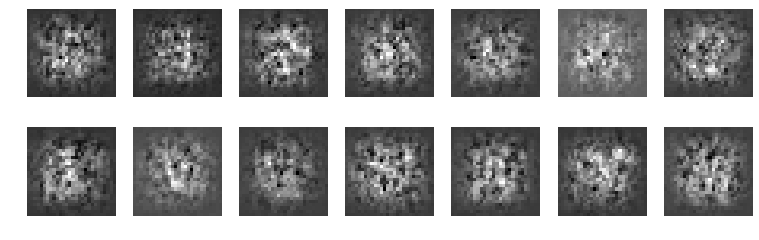

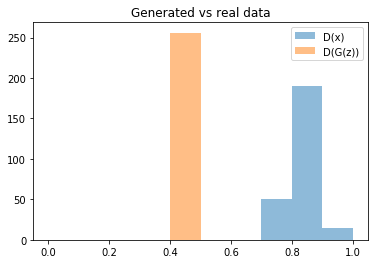

Time for epoch 2 is 0.1627548150718212 min
error D: 0.7496927380561829, error G: -0.6023277044296265
Time for epoch 3 is 0.23323556780815125 min
error D: 0.7309094667434692, error G: -0.5987756252288818
Time for epoch 4 is 0.30823395028710365 min
error D: 0.7098988890647888, error G: -0.5946568250656128
Time for epoch 5 is 0.3785581476986408 min
error D: 0.6880081295967102, error G: -0.5900804996490479
Time for epoch 6 is 0.4524476192891598 min
error D: 0.6699711084365845, error G: -0.5852057933807373
Time for epoch 7 is 0.5196378156542778 min
error D: 0.6579416990280151, error G: -0.5795211791992188
Time for epoch 8 is 0.5883124470710754 min
error D: 0.6439930200576782, error G: -0.5737651586532593
Time for epoch 9 is 0.6628815494477749 min
error D: 0.6305334568023682, error G: -0.5671858787536621
Time for epoch 10 is 0.743399117141962 min
error D: 0.619289219379425, error G: -0.5606405138969421
Time for epoch 11 is 0.8245814144611359 min
error D: 0.6042433381080627, error G: -0.55198

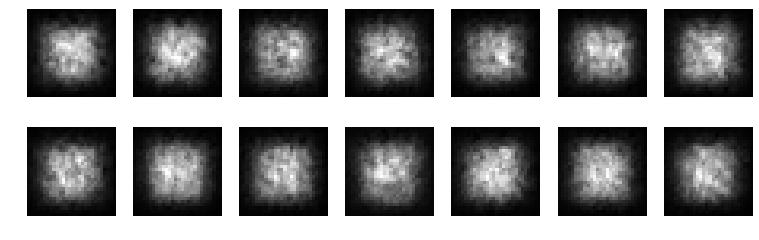

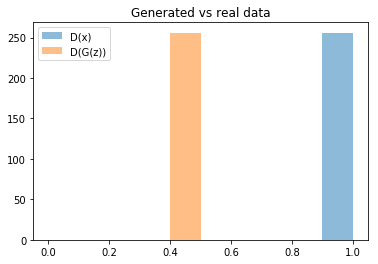

Time for epoch 12 is 0.9407012164592743 min
error D: 0.5915408730506897, error G: -0.5435642004013062
Time for epoch 13 is 1.0145842842757702 min
error D: 0.5788335204124451, error G: -0.5335268974304199
Time for epoch 14 is 1.0923450514674187 min
error D: 0.5647447109222412, error G: -0.5226542949676514
Time for epoch 15 is 1.1917618326842785 min
error D: 0.5493181347846985, error G: -0.5098974108695984
Time for epoch 16 is 1.2966512478888035 min
error D: 0.5313804745674133, error G: -0.49561530351638794
Time for epoch 17 is 1.3774633295834064 min
error D: 0.5120989680290222, error G: -0.4793151021003723
Time for epoch 18 is 1.4538548849523067 min
error D: 0.49212178587913513, error G: -0.46131330728530884
Time for epoch 19 is 1.534054484218359 min
error D: 0.46968209743499756, error G: -0.44047367572784424
Time for epoch 20 is 1.6100643016397953 min
error D: 0.44515088200569153, error G: -0.41787558794021606
Time for epoch 21 is 1.6831197664141655 min
error D: 0.4194376468658447, err

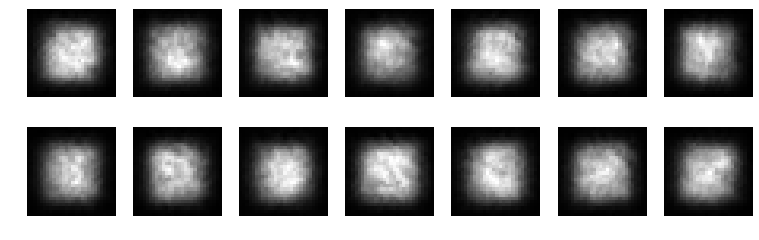

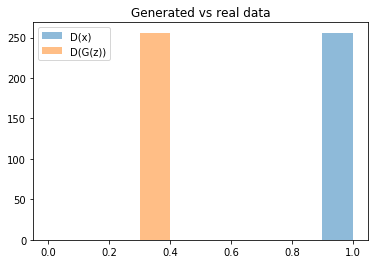

Time for epoch 22 is 1.8044131807982922 min
error D: 0.3926520347595215, error G: -0.3694465756416321
Time for epoch 23 is 1.8739998452365398 min
error D: 0.3672316074371338, error G: -0.3447473645210266
Time for epoch 24 is 1.9412169307470322 min
error D: 0.34263375401496887, error G: -0.3214288353919983
Time for epoch 25 is 2.0089718997478485 min
error D: 0.32033345103263855, error G: -0.3000800609588623
Time for epoch 26 is 2.0750163309276104 min
error D: 0.30044037103652954, error G: -0.2815679907798767
Time for epoch 27 is 2.1395923495292664 min
error D: 0.2827364206314087, error G: -0.26506465673446655
Time for epoch 28 is 2.206525344401598 min
error D: 0.2668088674545288, error G: -0.2501789331436157
Time for epoch 29 is 2.2710770964622498 min
error D: 0.2556031048297882, error G: -0.23917508125305176
Time for epoch 30 is 2.3440931476652622 min
error D: 0.2458154857158661, error G: -0.2308286875486374
Time for epoch 31 is 2.4254606664180756 min
error D: 0.23759211599826813, erro

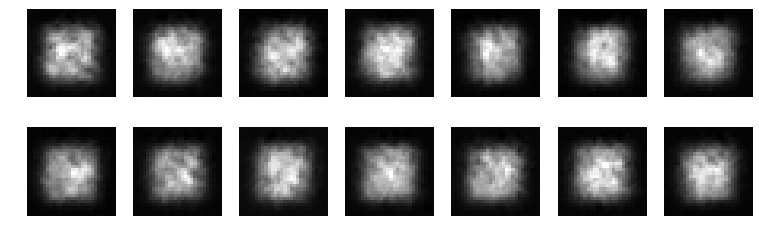

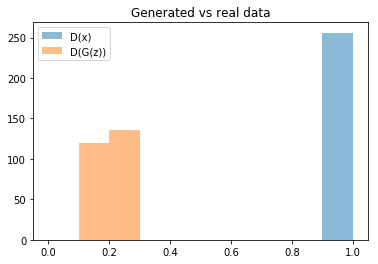

Time for epoch 32 is 2.5442696809768677 min
error D: 0.23100703954696655, error G: -0.21731092035770416
Time for epoch 33 is 2.643336832523346 min
error D: 0.22628696262836456, error G: -0.21262779831886292
Time for epoch 34 is 2.7352294847369194 min
error D: 0.22109313309192657, error G: -0.2085859328508377
Time for epoch 35 is 2.84798201918602 min
error D: 0.21774666011333466, error G: -0.2049470841884613
Time for epoch 36 is 2.950757462531328 min
error D: 0.21321259438991547, error G: -0.2010536640882492
Time for epoch 37 is 3.061163816601038 min
error D: 0.20960436761379242, error G: -0.19758790731430054
Time for epoch 38 is 3.1709618978202343 min
error D: 0.2062126249074936, error G: -0.19466841220855713
Time for epoch 39 is 3.255632434040308 min
error D: 0.20293402671813965, error G: -0.19170339405536652
Time for epoch 40 is 3.331740565598011 min
error D: 0.19886913895606995, error G: -0.1880911886692047
Time for epoch 41 is 3.3994305841624737 min
error D: 0.19496296346187592, er

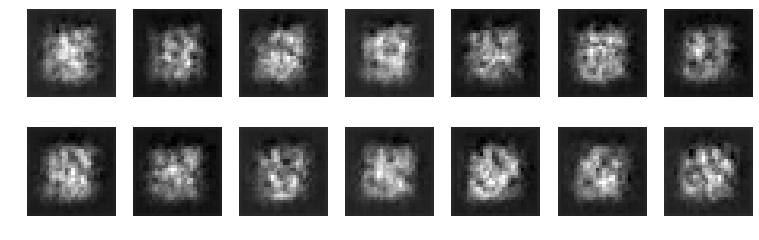

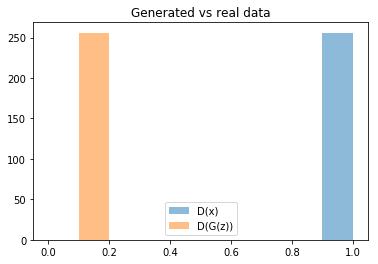

Time for epoch 42 is 3.4969163313508034 min
error D: 0.19123822450637817, error G: -0.18097808957099915
Time for epoch 43 is 3.574490264058113 min
error D: 0.18782232701778412, error G: -0.17745797336101532
Time for epoch 44 is 3.6489904299378395 min
error D: 0.18343399465084076, error G: -0.1733015924692154
Time for epoch 45 is 3.7185190469026566 min
error D: 0.17883636057376862, error G: -0.1693497598171234
Time for epoch 46 is 3.7840147987008095 min
error D: 0.17499038577079773, error G: -0.16528761386871338
Time for epoch 47 is 3.8717502802610397 min
error D: 0.17078952491283417, error G: -0.16132289171218872
Time for epoch 48 is 3.9831175953149796 min
error D: 0.1668558120727539, error G: -0.15729308128356934
Time for epoch 49 is 4.0765951462090015 min
error D: 0.16336452960968018, error G: -0.15341010689735413
Time for epoch 50 is 4.152290064841509 min
error D: 0.15910430252552032, error G: -0.1496475785970688
Time for epoch 51 is 4.2299859672784805 min
error D: 0.155521646142005

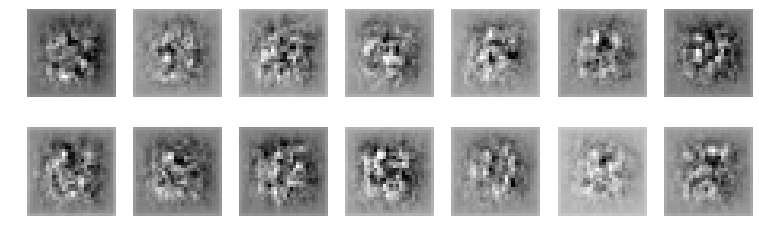

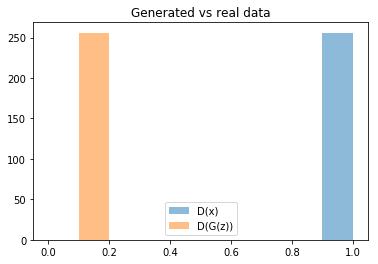

Time for epoch 52 is 4.333899833261967 min
error D: 0.1519993245601654, error G: -0.14281120896339417
Time for epoch 53 is 4.41814911365509 min
error D: 0.149188831448555, error G: -0.13980013132095337
Time for epoch 54 is 4.508008796721697 min
error D: 0.14656667411327362, error G: -0.13740894198417664
Time for epoch 55 is 4.601669702678919 min
error D: 0.14445777237415314, error G: -0.13502317667007446
Time for epoch 56 is 4.678720898926258 min
error D: 0.14281950891017914, error G: -0.13345029950141907
Time for epoch 57 is 4.746657785028219 min
error D: 0.14181147515773773, error G: -0.13223236799240112
Time for epoch 58 is 4.813715066760778 min
error D: 0.14103001356124878, error G: -0.1315809041261673
Time for epoch 59 is 4.90443204715848 min
error D: 0.14113225042819977, error G: -0.13169321417808533
Time for epoch 60 is 4.986209612339735 min
error D: 0.14289672672748566, error G: -0.13240259885787964
Time for epoch 61 is 5.049718629568815 min
error D: 0.14244522154331207, error 

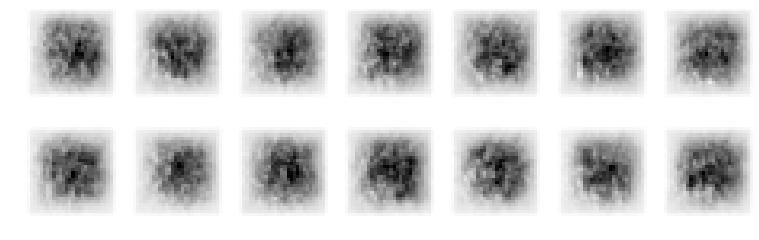

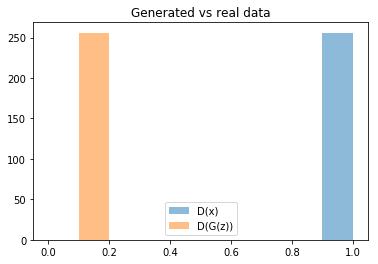

Time for epoch 62 is 5.157038331031799 min
error D: 0.14682243764400482, error G: -0.13586506247520447
Time for epoch 63 is 5.267546817660332 min
error D: 0.14989879727363586, error G: -0.1386299580335617
Time for epoch 64 is 5.349647164344788 min
error D: 0.1532440334558487, error G: -0.14180302619934082
Time for epoch 65 is 5.413961049169302 min
error D: 0.15642063319683075, error G: -0.1446387767791748
Time for epoch 66 is 5.490588948130608 min
error D: 0.16158196330070496, error G: -0.14754611253738403
Time for epoch 67 is 5.562470614910126 min
error D: 0.16398902237415314, error G: -0.14985430240631104
Time for epoch 68 is 5.633781332522631 min
error D: 0.1661115437746048, error G: -0.14996038377285004
Time for epoch 69 is 5.705019764602184 min
error D: 0.16618560254573822, error G: -0.14709456264972687
Time for epoch 70 is 5.771679785102606 min
error D: 0.16244587302207947, error G: -0.141027569770813
Time for epoch 71 is 5.837479632347822 min
error D: 0.15341050922870636, error 

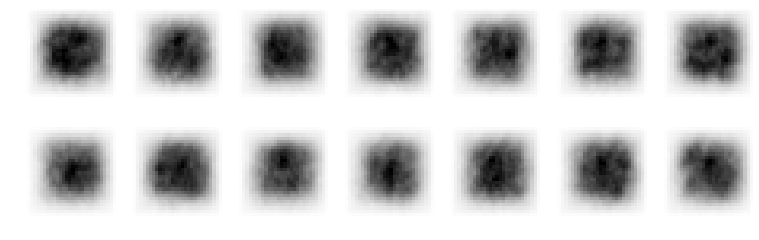

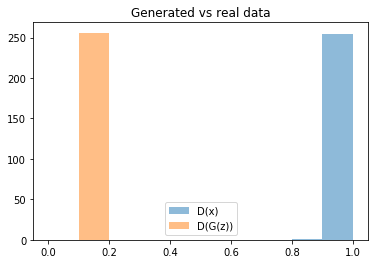

Time for epoch 72 is 5.9389064982533455 min
error D: 0.1425662636756897, error G: -0.11597569286823273
Time for epoch 73 is 6.009166982024908 min
error D: 0.1306380182504654, error G: -0.10148950666189194
Time for epoch 74 is 6.072382301092148 min
error D: 0.11683832108974457, error G: -0.0861494392156601
Time for epoch 75 is 6.137537430971861 min
error D: 0.10784805566072464, error G: -0.0739838182926178
Time for epoch 76 is 6.201180178672075 min
error D: 0.09752395749092102, error G: -0.06307585537433624
Time for epoch 77 is 6.2665067464113235 min
error D: 0.08961327373981476, error G: -0.05577914044260979
Time for epoch 78 is 6.33099153265357 min
error D: 0.08545035868883133, error G: -0.04874861240386963
Time for epoch 79 is 6.394902016967535 min
error D: 0.08030132204294205, error G: -0.044587358832359314
Time for epoch 80 is 6.45909871160984 min
error D: 0.07579023391008377, error G: -0.04129414260387421
Time for epoch 81 is 6.523223161697388 min
error D: 0.07242650538682938, err

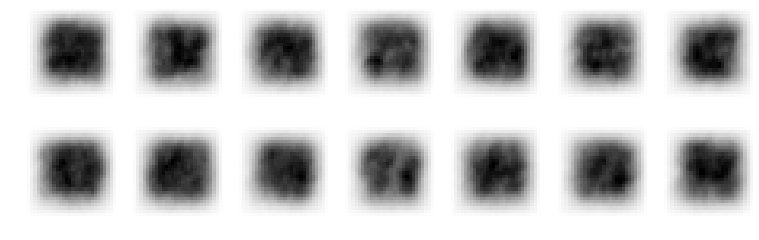

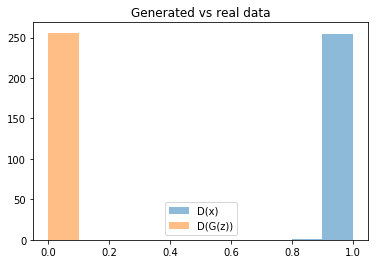

Time for epoch 82 is 6.6197755970060825 min
error D: 0.07328160852193832, error G: -0.0394507460296154
Time for epoch 83 is 6.683344833552837 min
error D: 0.07267338037490845, error G: -0.03978976607322693
Time for epoch 84 is 6.750327482819557 min
error D: 0.07694777846336365, error G: -0.04346100240945816
Time for epoch 85 is 6.815630629658699 min
error D: 0.07699376344680786, error G: -0.044206682592630386
Time for epoch 86 is 6.880062814801931 min
error D: 0.07446757704019547, error G: -0.044438429176807404
Time for epoch 87 is 6.94587891548872 min
error D: 0.08071316033601761, error G: -0.04968821629881859
Time for epoch 88 is 7.009629283100367 min
error D: 0.09011674672365189, error G: -0.05699478089809418
Time for epoch 89 is 7.07368541508913 min
error D: 0.09143185615539551, error G: -0.05823153629899025
Time for epoch 90 is 7.136844713240862 min
error D: 0.10048942267894745, error G: -0.06661301851272583
Time for epoch 91 is 7.200758185237646 min
error D: 0.11142652481794357, 

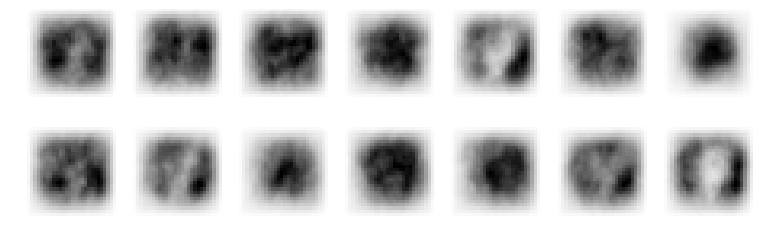

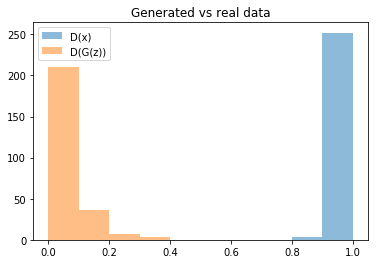

Time for epoch 92 is 7.291140630841255 min
error D: 0.11256509274244308, error G: -0.07686688005924225
Time for epoch 93 is 7.354510612785816 min
error D: 0.1319183111190796, error G: -0.09403006732463837
Time for epoch 94 is 7.418251883238554 min
error D: 0.14064735174179077, error G: -0.09879066795110703
Time for epoch 95 is 7.482555333524942 min
error D: 0.14806613326072693, error G: -0.10246387124061584
Time for epoch 96 is 7.546160914003849 min
error D: 0.16175983846187592, error G: -0.1152171641588211
Time for epoch 97 is 7.611633233726025 min
error D: 0.1837080419063568, error G: -0.13051213324069977
Time for epoch 98 is 7.687150664627552 min
error D: 0.23811763525009155, error G: -0.17274907231330872
Time for epoch 99 is 7.769210081547499 min
error D: 0.23715052008628845, error G: -0.1663626730442047
Time for epoch 100 is 7.848443832248449 min
error D: 0.2943430542945862, error G: -0.2050579935312271
Time for epoch 101 is 7.918510053306818 min
error D: 0.37577024102211, error G

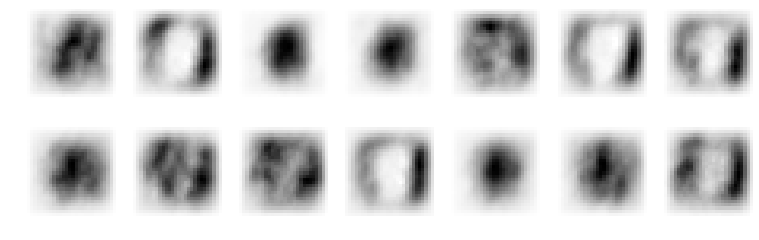

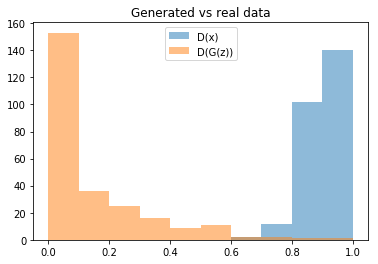

Time for epoch 102 is 8.028653163462877 min
error D: 0.3445243537425995, error G: -0.22977302968502045
Time for epoch 103 is 8.114167984575033 min
error D: 0.37833309173583984, error G: -0.25063496828079224
Time for epoch 104 is 8.197375599294901 min
error D: 0.44090813398361206, error G: -0.2884431481361389
Time for epoch 105 is 8.265844598412514 min
error D: 0.5435537099838257, error G: -0.33302193880081177
Time for epoch 106 is 8.329695582389832 min
error D: 0.5506712794303894, error G: -0.3257252275943756
Time for epoch 107 is 8.394009549170732 min
error D: 0.5585175156593323, error G: -0.31766822934150696
Time for epoch 108 is 8.457703310996294 min
error D: 0.49509698152542114, error G: -0.27968257665634155
Time for epoch 109 is 8.52231876924634 min
error D: 0.5333662629127502, error G: -0.29410237073898315
Time for epoch 110 is 8.586783364415169 min
error D: 0.531594455242157, error G: -0.29021504521369934
Time for epoch 111 is 8.65077269822359 min
error D: 0.6072254776954651, er

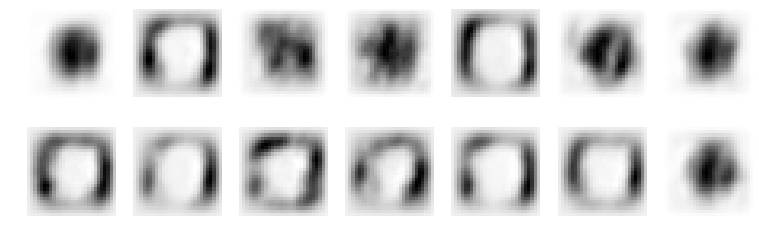

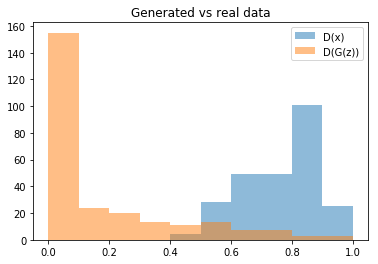

Time for epoch 112 is 8.7415871322155 min
error D: 0.6107969284057617, error G: -0.3245028257369995
Time for epoch 113 is 8.80634906515479 min
error D: 0.6030242443084717, error G: -0.3141993284225464
Time for epoch 114 is 8.874117966741323 min
error D: 0.5956941246986389, error G: -0.3262268304824829
Time for epoch 115 is 8.940094150602818 min
error D: 0.6664132475852966, error G: -0.35246890783309937
Time for epoch 116 is 9.004430547356606 min
error D: 0.6926659345626831, error G: -0.35222989320755005
Time for epoch 117 is 9.0680972635746 min
error D: 0.6214063167572021, error G: -0.33682891726493835
Time for epoch 118 is 9.13201479613781 min
error D: 0.6794196963310242, error G: -0.37376296520233154
Time for epoch 119 is 9.196421012282372 min
error D: 0.6892535090446472, error G: -0.3868062198162079
Time for epoch 120 is 9.26053024828434 min
error D: 0.753338634967804, error G: -0.43635112047195435
Time for epoch 121 is 9.32385091483593 min
error D: 0.7371405959129333, error G: -0.4

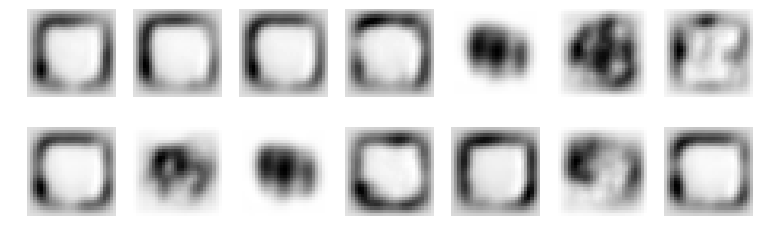

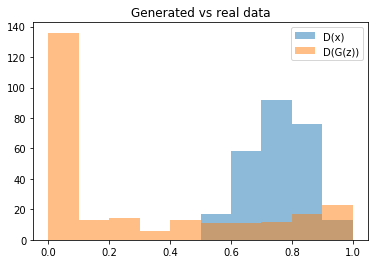

Time for epoch 122 is 9.413100332021713 min
error D: 0.9629331231117249, error G: -0.5976946949958801
Time for epoch 123 is 9.477863729000092 min
error D: 1.1745983362197876, error G: -0.7392457723617554
Time for epoch 124 is 9.541787430644035 min
error D: 1.091748595237732, error G: -0.7005302906036377
Time for epoch 125 is 9.60497498139739 min
error D: 1.2121474742889404, error G: -0.758845329284668
Time for epoch 126 is 9.66931178048253 min
error D: 1.232229232788086, error G: -0.767573893070221
Time for epoch 127 is 9.736734081059694 min
error D: 1.1528620719909668, error G: -0.6574884057044983
Time for epoch 128 is 9.800687067210674 min
error D: 1.0010371208190918, error G: -0.4936145544052124
Time for epoch 129 is 9.86490161344409 min
error D: 0.7131954431533813, error G: -0.3323519825935364
Time for epoch 130 is 9.930675651878119 min
error D: 0.5755546689033508, error G: -0.24064883589744568
Time for epoch 131 is 9.995584048330784 min
error D: 0.49478912353515625, error G: -0.19

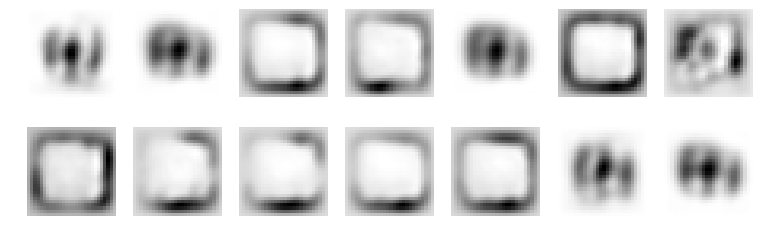

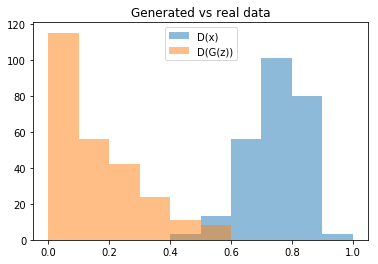

Time for epoch 132 is 10.085944283753633 min
error D: 0.4186989963054657, error G: -0.1671830117702484
Time for epoch 133 is 10.150082781910896 min
error D: 0.38612496852874756, error G: -0.15643051266670227
Time for epoch 134 is 10.214573469012976 min
error D: 0.35417771339416504, error G: -0.14224179089069366
Time for epoch 135 is 10.278253115713596 min
error D: 0.3607555031776428, error G: -0.16006067395210266
Time for epoch 136 is 10.341710481792688 min
error D: 0.3357725441455841, error G: -0.14952249825000763
Time for epoch 137 is 10.406052101403475 min
error D: 0.3410508334636688, error G: -0.15914127230644226
Time for epoch 138 is 10.470675397664309 min
error D: 0.33482301235198975, error G: -0.1619064211845398
Time for epoch 139 is 10.535602316260338 min
error D: 0.3081175684928894, error G: -0.14669516682624817
Time for epoch 140 is 10.600186865776777 min
error D: 0.3283585011959076, error G: -0.157267764210701
Time for epoch 141 is 10.68564273044467 min
error D: 0.3549192845

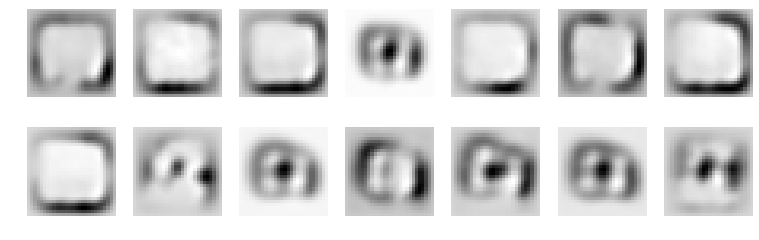

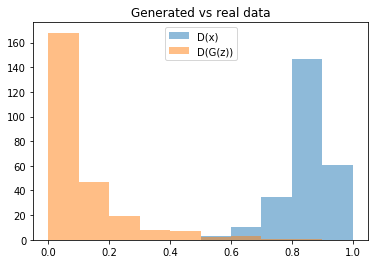

Time for epoch 142 is 10.795820619910955 min
error D: 0.3442801237106323, error G: -0.17801982164382935
Time for epoch 143 is 10.876584332436323 min
error D: 0.3546038269996643, error G: -0.18449163436889648
Time for epoch 144 is 10.954507112503052 min
error D: 0.36299633979797363, error G: -0.19156718254089355
Time for epoch 145 is 11.02080237865448 min
error D: 0.3778992295265198, error G: -0.20536719262599945
Time for epoch 146 is 11.089779663830996 min
error D: 0.36649614572525024, error G: -0.2037578523159027
Time for epoch 147 is 11.156857900321484 min
error D: 0.40585753321647644, error G: -0.22776058316230774
Time for epoch 148 is 11.223202530294657 min
error D: 0.44060853123664856, error G: -0.2560253143310547
Time for epoch 149 is 11.289247065782547 min
error D: 0.42725011706352234, error G: -0.23527587950229645
Time for epoch 150 is 11.365619365125895 min
error D: 0.47045212984085083, error G: -0.2732197642326355
Time for epoch 151 is 11.446599882096052 min
error D: 0.497873

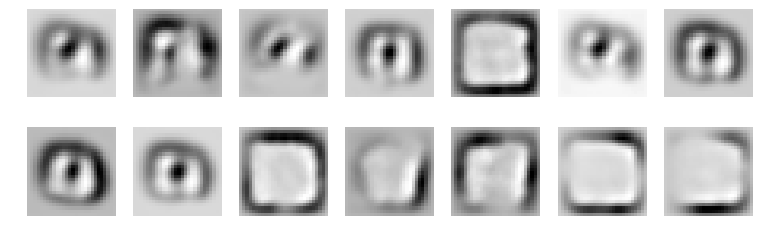

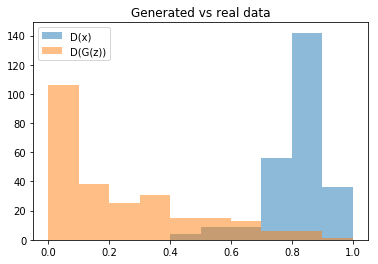

Time for epoch 152 is 11.556565929204226 min
error D: 0.5238937735557556, error G: -0.3124311864376068
Time for epoch 153 is 11.621516179293394 min
error D: 0.6018145680427551, error G: -0.3508427143096924
Time for epoch 154 is 11.687973115593195 min
error D: 0.6686941981315613, error G: -0.3948826491832733
Time for epoch 155 is 11.770757835358381 min
error D: 0.6975439190864563, error G: -0.4181312918663025
Time for epoch 156 is 11.850299313664436 min
error D: 0.7180294394493103, error G: -0.4236798882484436
Time for epoch 157 is 11.946271166205406 min
error D: 0.8097869753837585, error G: -0.4869426190853119
Time for epoch 158 is 12.037222750484943 min
error D: 0.7932586073875427, error G: -0.47251248359680176
Time for epoch 159 is 12.116315867751837 min
error D: 0.8282535076141357, error G: -0.5004640817642212
Time for epoch 160 is 12.181784562766552 min
error D: 0.8559609651565552, error G: -0.505692183971405
Time for epoch 161 is 12.249107915908098 min
error D: 0.8328770995140076,

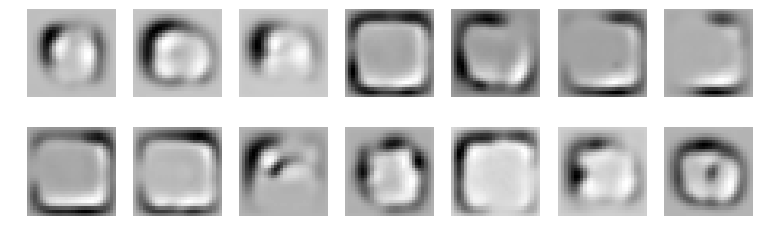

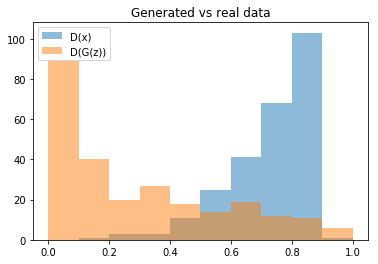

Time for epoch 162 is 12.34385859966278 min
error D: 0.8795363903045654, error G: -0.5187571048736572
Time for epoch 163 is 12.408576246351004 min
error D: 0.7926234006881714, error G: -0.46119779348373413
Time for epoch 164 is 12.47666261345148 min
error D: 0.8462044596672058, error G: -0.5107508897781372
Time for epoch 165 is 12.547884549945593 min
error D: 0.900051474571228, error G: -0.5451505184173584
Time for epoch 166 is 12.613442666828632 min
error D: 0.7900903224945068, error G: -0.4803447127342224
Time for epoch 167 is 12.67786893248558 min
error D: 0.8229179978370667, error G: -0.4869549870491028
Time for epoch 168 is 12.742711115628481 min
error D: 0.785366415977478, error G: -0.4675884246826172
Time for epoch 169 is 12.809052415192127 min
error D: 0.7673510313034058, error G: -0.4370308816432953
Time for epoch 170 is 12.875424981117249 min
error D: 0.698828399181366, error G: -0.40447914600372314
Time for epoch 171 is 12.942818764597178 min
error D: 0.6916834712028503, err

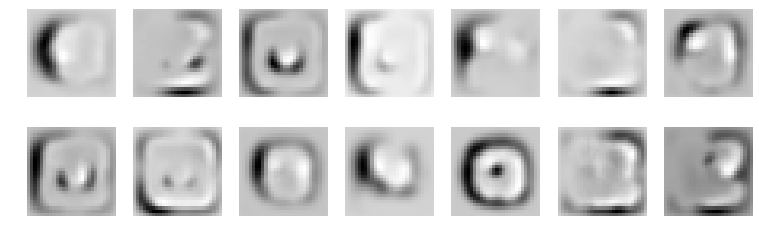

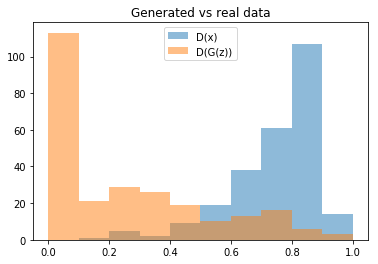

Time for epoch 172 is 13.035272348672152 min
error D: 0.7465212345123291, error G: -0.38618481159210205
Time for epoch 173 is 13.10173949971795 min
error D: 0.7210724353790283, error G: -0.3822377920150757
Time for epoch 174 is 13.170148678123951 min
error D: 0.7484623193740845, error G: -0.385844349861145
Time for epoch 175 is 13.235372297465801 min
error D: 0.8465967774391174, error G: -0.45202967524528503
Time for epoch 176 is 13.301490500569344 min
error D: 0.8369847536087036, error G: -0.42942553758621216
Time for epoch 177 is 13.368453700095415 min
error D: 0.9103311896324158, error G: -0.4680063724517822
Time for epoch 178 is 13.433145180344582 min
error D: 0.91538006067276, error G: -0.46548163890838623
Time for epoch 179 is 13.499332416802645 min
error D: 0.9394119381904602, error G: -0.4601336121559143
Time for epoch 180 is 13.56607024744153 min
error D: 0.9681900143623352, error G: -0.45452991127967834
Time for epoch 181 is 13.630008596926928 min
error D: 0.9201307892799377,

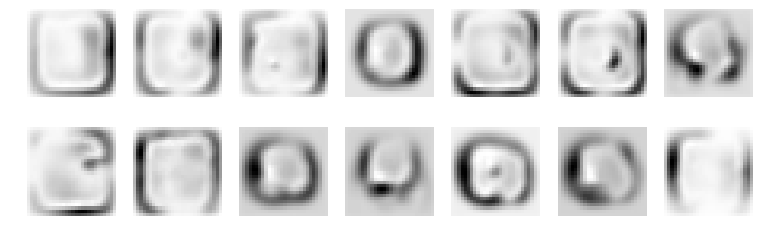

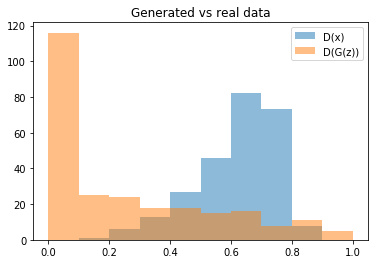

Time for epoch 182 is 13.72291661426425 min
error D: 0.8458828926086426, error G: -0.39132046699523926
Time for epoch 183 is 13.787485267966986 min
error D: 0.801825225353241, error G: -0.3559225797653198
Time for epoch 184 is 13.856237530708313 min
error D: 0.7306482195854187, error G: -0.28348347544670105
Time for epoch 185 is 13.921761680394411 min
error D: 0.5861291289329529, error G: -0.21460574865341187
Time for epoch 186 is 13.987976148724556 min
error D: 0.4914039075374603, error G: -0.1659901738166809
Time for epoch 187 is 14.053342647850513 min
error D: 0.4386202394962311, error G: -0.15142665803432465
Time for epoch 188 is 14.118983749300241 min
error D: 0.3596608340740204, error G: -0.1251271665096283
Time for epoch 189 is 14.186306178569794 min
error D: 0.3349880874156952, error G: -0.12004076689481735
Time for epoch 190 is 14.252734247595072 min
error D: 0.2903640866279602, error G: -0.10355076938867569
Time for epoch 191 is 14.319697767496109 min
error D: 0.2950403988361

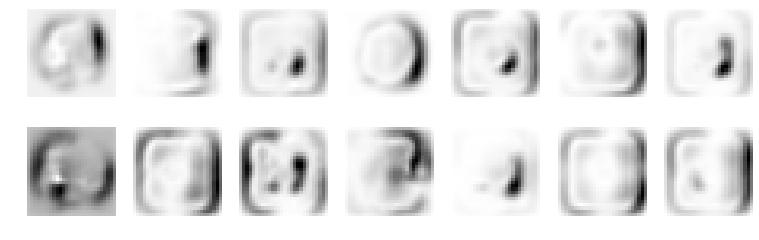

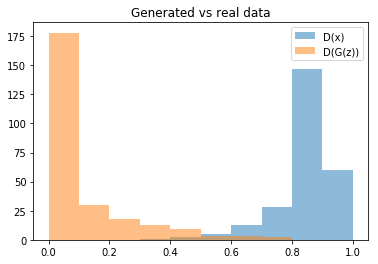

Time for epoch 192 is 14.41479778289795 min
error D: 0.30563610792160034, error G: -0.1238688975572586
Time for epoch 193 is 14.481385547667742 min
error D: 0.3106544315814972, error G: -0.1401911973953247
Time for epoch 194 is 14.550758466124535 min
error D: 0.386788010597229, error G: -0.19817563891410828
Time for epoch 195 is 14.616520319133997 min
error D: 0.377975732088089, error G: -0.2000192105770111
Time for epoch 196 is 14.68299663439393 min
error D: 0.35470420122146606, error G: -0.1956675946712494
Time for epoch 197 is 14.748094666749239 min
error D: 0.46332255005836487, error G: -0.26214414834976196
Time for epoch 198 is 14.81329157948494 min
error D: 0.5193392038345337, error G: -0.3111302852630615
Time for epoch 199 is 14.879859901964664 min
error D: 0.5388245582580566, error G: -0.3148713707923889
Time for epoch 200 is 14.945857916027308 min
error D: 0.7524734735488892, error G: -0.4616549611091614
Time for epoch 201 is 15.014802601188421 min
error D: 0.6754682660102844,

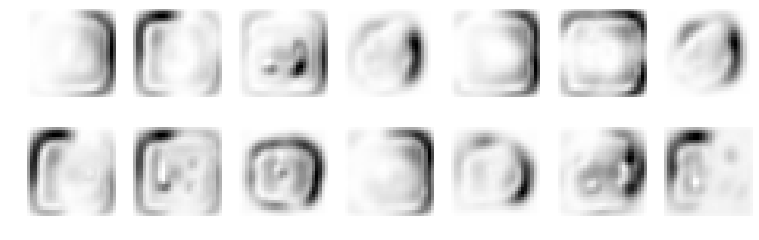

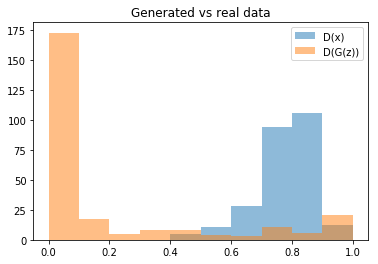

Time for epoch 202 is 15.106497645378113 min
error D: 0.8819151520729065, error G: -0.5216194987297058
Time for epoch 203 is 15.173558715730906 min
error D: 0.8035174012184143, error G: -0.4623604714870453
Time for epoch 204 is 15.241567846387625 min
error D: 0.7610808610916138, error G: -0.40066319704055786
Time for epoch 205 is 15.308622281998396 min
error D: 0.7213754653930664, error G: -0.34919750690460205
Time for epoch 206 is 15.374976463615894 min
error D: 0.6937287449836731, error G: -0.3218483328819275
Time for epoch 207 is 15.440647467970848 min
error D: 0.669675886631012, error G: -0.3053581118583679
Time for epoch 208 is 15.506174866110086 min
error D: 0.6228521466255188, error G: -0.2843545973300934
Time for epoch 209 is 15.57175861299038 min
error D: 0.581428050994873, error G: -0.2711099684238434
Time for epoch 210 is 15.637461680918932 min
error D: 0.5671846866607666, error G: -0.2664276361465454
Time for epoch 211 is 15.705174934118986 min
error D: 0.5226796269416809, 

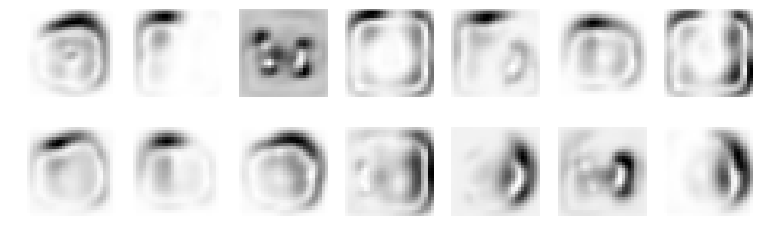

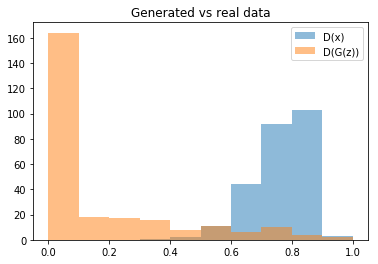

Time for epoch 212 is 15.798357713967562 min
error D: 0.492631733417511, error G: -0.23353783786296844
Time for epoch 213 is 15.863094314932823 min
error D: 0.5364841222763062, error G: -0.2722974419593811
Time for epoch 214 is 15.927473034709692 min
error D: 0.4858545958995819, error G: -0.24949663877487183
Time for epoch 215 is 15.997721936553717 min
error D: 0.5294148921966553, error G: -0.27740049362182617
Time for epoch 216 is 16.090322326868773 min
error D: 0.5302097201347351, error G: -0.28747236728668213
Time for epoch 217 is 16.1661985963583 min
error D: 0.6087328791618347, error G: -0.3415003716945648
Time for epoch 218 is 16.23286333307624 min
error D: 0.6293729543685913, error G: -0.3605613112449646
Time for epoch 219 is 16.30083554983139 min
error D: 0.6389174461364746, error G: -0.3815995454788208
Time for epoch 220 is 16.370268765836954 min
error D: 0.7875766158103943, error G: -0.48056167364120483
Time for epoch 221 is 16.44449169933796 min
error D: 0.80464106798172, er

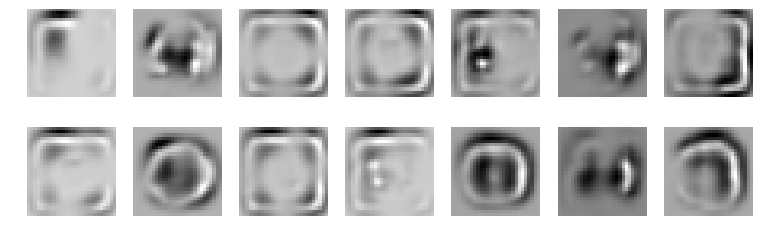

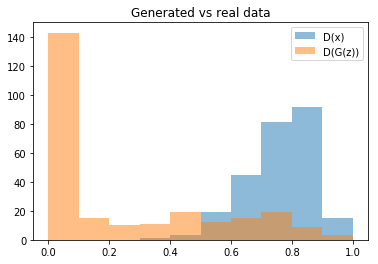

Time for epoch 222 is 16.557649794965982 min
error D: 0.845336377620697, error G: -0.5601585507392883
Time for epoch 223 is 16.64155213162303 min
error D: 0.9141514301300049, error G: -0.6139393448829651
Time for epoch 224 is 16.7198801971972 min
error D: 0.8635320663452148, error G: -0.5899373292922974
Time for epoch 225 is 16.805241346359253 min
error D: 1.0216679573059082, error G: -0.7189654111862183
Time for epoch 226 is 16.882879097014666 min
error D: 0.9062308073043823, error G: -0.6517242193222046
Time for epoch 227 is 16.949430733919144 min
error D: 0.9520584940910339, error G: -0.70496666431427
Time for epoch 228 is 17.01673561707139 min
error D: 0.9221625924110413, error G: -0.6868705749511719
Time for epoch 229 is 17.088597398251295 min
error D: 0.8868350386619568, error G: -0.6686439514160156
Time for epoch 230 is 17.171273346990347 min
error D: 0.8767642378807068, error G: -0.6544153690338135
Time for epoch 231 is 17.265972513705492 min
error D: 0.7282792329788208, error 

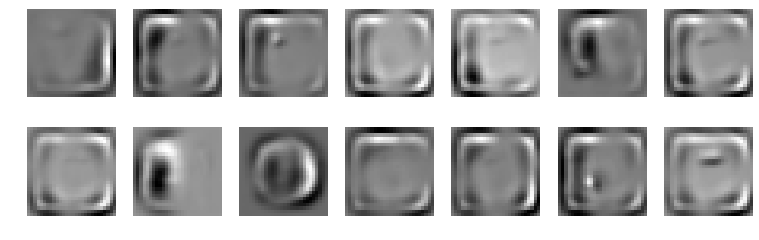

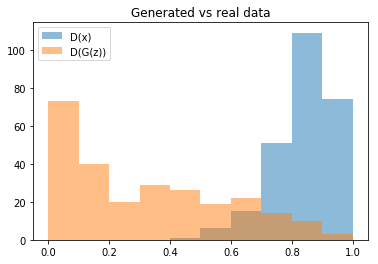

Time for epoch 232 is 17.41293553262949 min
error D: 0.6930368542671204, error G: -0.5076993107795715
Time for epoch 233 is 17.502727694809437 min
error D: 0.637933611869812, error G: -0.46107274293899536
Time for epoch 234 is 17.574995279312134 min
error D: 0.5718173980712891, error G: -0.4124916195869446
Time for epoch 235 is 17.658347815275192 min
error D: 0.4740579426288605, error G: -0.32871079444885254
Time for epoch 236 is 17.726625565439463 min
error D: 0.4243837893009186, error G: -0.28682103753089905
Time for epoch 237 is 17.80039483308792 min
error D: 0.3871377110481262, error G: -0.24799469113349915
Time for epoch 238 is 17.880127549171448 min
error D: 0.35069212317466736, error G: -0.21559615433216095
Time for epoch 239 is 17.953624367713928 min
error D: 0.3544028699398041, error G: -0.2153799831867218
Time for epoch 240 is 18.031428813934326 min
error D: 0.32909777760505676, error G: -0.19408343732357025
Time for epoch 241 is 18.100153263658285 min
error D: 0.364215075969

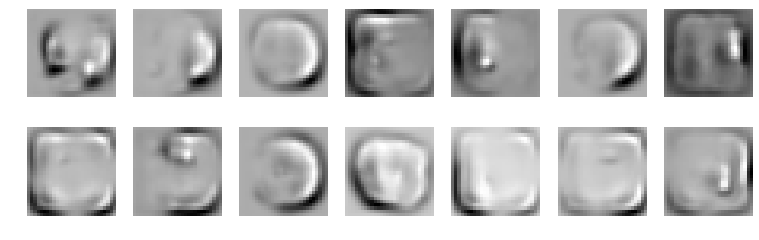

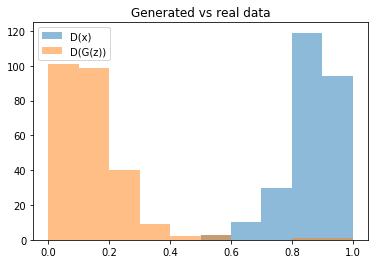

Time for epoch 242 is 18.207395300269127 min
error D: 0.33855441212654114, error G: -0.1926722228527069
Time for epoch 243 is 18.284328315407038 min
error D: 0.35843008756637573, error G: -0.20484322309494019
Time for epoch 244 is 18.37046378105879 min
error D: 0.38236764073371887, error G: -0.2200392186641693
Time for epoch 245 is 18.466535732150078 min
error D: 0.4137837290763855, error G: -0.23591496050357819
Time for epoch 246 is 18.534107733517885 min
error D: 0.4699658155441284, error G: -0.2759809195995331
Time for epoch 247 is 18.599901247769594 min
error D: 0.545585572719574, error G: -0.3226173520088196
Time for epoch 248 is 18.66488241404295 min
error D: 0.6218525171279907, error G: -0.347695916891098
Time for epoch 249 is 18.731247380375862 min
error D: 0.5614606738090515, error G: -0.31702661514282227
Time for epoch 250 is 18.799212250858545 min
error D: 0.687299907207489, error G: -0.35742324590682983
Time for epoch 251 is 18.867067098617554 min
error D: 0.660448074340820

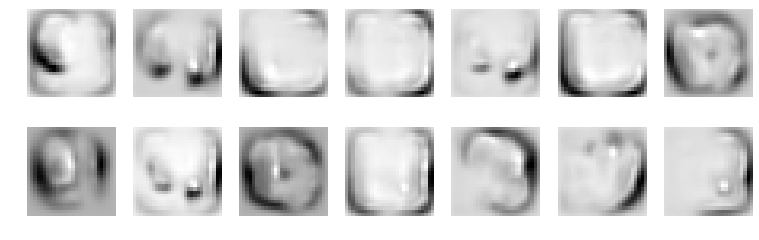

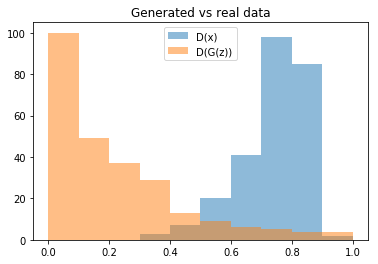

Time for epoch 252 is 18.96866500005126 min
error D: 0.6273180842399597, error G: -0.3001445531845093
Time for epoch 253 is 19.0529272146523 min
error D: 0.6559090614318848, error G: -0.3199441432952881
Time for epoch 254 is 19.139533281326294 min
error D: 0.6141976118087769, error G: -0.2962988018989563
Time for epoch 255 is 19.23433604836464 min
error D: 0.6720192432403564, error G: -0.31726205348968506
Time for epoch 256 is 19.312853615731 min
error D: 0.6721185445785522, error G: -0.3134915232658386
Time for epoch 257 is 19.389488764107227 min
error D: 0.6396895051002502, error G: -0.27862703800201416
Time for epoch 258 is 19.467801347374916 min
error D: 0.6064374446868896, error G: -0.25808751583099365
Time for epoch 259 is 19.547613132745028 min
error D: 0.5827526450157166, error G: -0.23222555220127106
Time for epoch 260 is 19.620734997093678 min
error D: 0.5507257580757141, error G: -0.21181638538837433
Time for epoch 261 is 19.702415268868208 min
error D: 0.4930051565170288, e

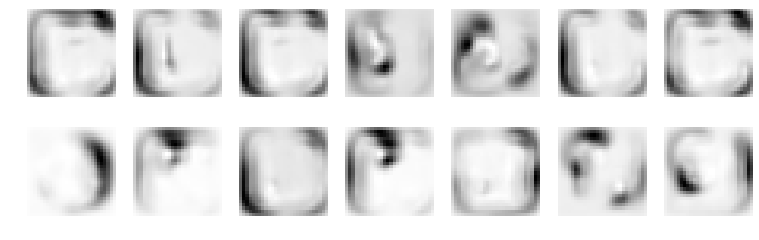

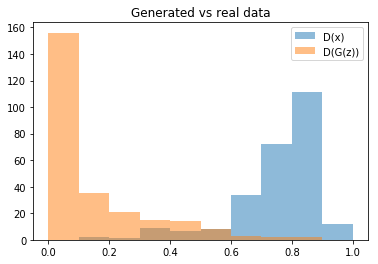

Time for epoch 262 is 19.81407194957137 min
error D: 0.4870852530002594, error G: -0.17400427162647247
Time for epoch 263 is 19.88770169764757 min
error D: 0.39609992504119873, error G: -0.1399608850479126
Time for epoch 264 is 19.996351398527622 min
error D: 0.4204404652118683, error G: -0.1457909345626831
Time for epoch 265 is 20.087950244545937 min
error D: 0.3654632270336151, error G: -0.12454614043235779
Time for epoch 266 is 20.155147168785334 min
error D: 0.3349882662296295, error G: -0.11648225784301758
Time for epoch 267 is 20.242001567035913 min
error D: 0.32193344831466675, error G: -0.10406769067049026
Time for epoch 268 is 20.315754801034927 min
error D: 0.31681060791015625, error G: -0.10631231218576431
Time for epoch 269 is 20.391709700226784 min
error D: 0.3163646459579468, error G: -0.10922033339738846
Time for epoch 270 is 20.497029349207878 min
error D: 0.30113816261291504, error G: -0.10719069838523865
Time for epoch 271 is 20.605035796761513 min
error D: 0.27509200

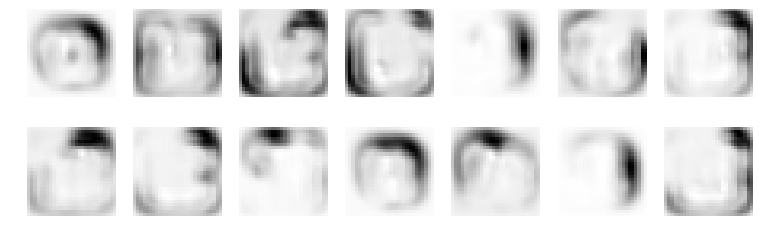

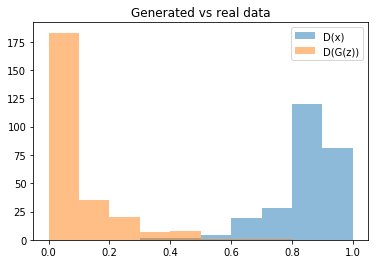

Time for epoch 272 is 20.722779516130686 min
error D: 0.2966613471508026, error G: -0.10322351008653641
Time for epoch 273 is 20.797759268432856 min
error D: 0.268343061208725, error G: -0.09681026637554169
Time for epoch 274 is 20.86367331445217 min
error D: 0.28167110681533813, error G: -0.10442008823156357
Time for epoch 275 is 20.932497262954712 min
error D: 0.2665337026119232, error G: -0.0965133085846901
Time for epoch 276 is 21.004218231886625 min
error D: 0.25521689653396606, error G: -0.0988418310880661
Time for epoch 277 is 21.079391047358513 min
error D: 0.25472044944763184, error G: -0.09711816906929016
Time for epoch 278 is 21.16149751469493 min
error D: 0.25951898097991943, error G: -0.1009254902601242
Time for epoch 279 is 21.239013832062483 min
error D: 0.26575660705566406, error G: -0.1041312888264656
Time for epoch 280 is 21.309848379343748 min
error D: 0.32575318217277527, error G: -0.13392066955566406
Time for epoch 281 is 21.38293683156371 min
error D: 0.3147841095

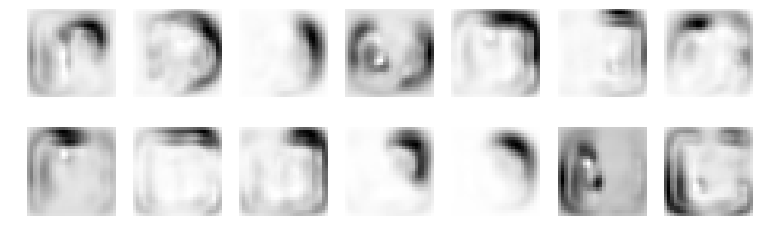

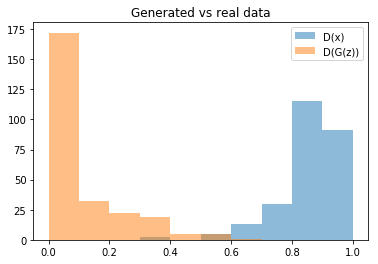

Time for epoch 282 is 21.491171531379223 min
error D: 0.3271828293800354, error G: -0.14036540687084198
Time for epoch 283 is 21.55604351311922 min
error D: 0.33230775594711304, error G: -0.14538736641407013
Time for epoch 284 is 21.687015149742365 min
error D: 0.32868635654449463, error G: -0.14295828342437744
Time for epoch 285 is 21.80790499970317 min
error D: 0.3572378158569336, error G: -0.16068312525749207
Time for epoch 286 is 21.936032213270664 min
error D: 0.3770172894001007, error G: -0.17203013598918915
Time for epoch 287 is 22.04666445031762 min
error D: 0.36323651671409607, error G: -0.16913145780563354
Time for epoch 288 is 22.122079882770777 min
error D: 0.37823694944381714, error G: -0.18103113770484924
Time for epoch 289 is 22.194592997431755 min
error D: 0.40426790714263916, error G: -0.1883029341697693
Time for epoch 290 is 22.27822406217456 min
error D: 0.4480399191379547, error G: -0.22020407021045685
Time for epoch 291 is 22.35990896821022 min
error D: 0.468603104

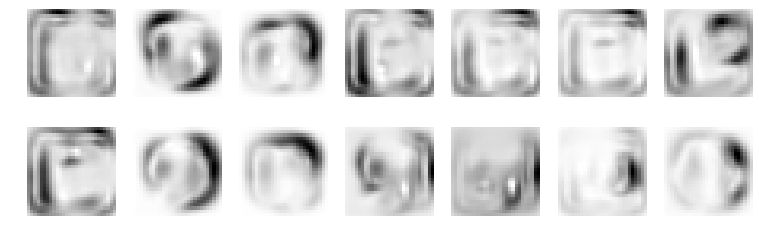

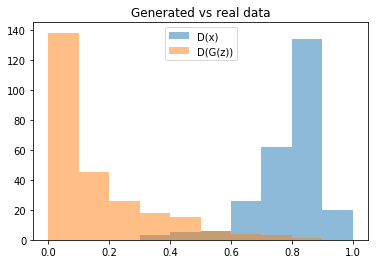

Time for epoch 292 is 22.46455144882202 min
error D: 0.46391040086746216, error G: -0.22936232388019562
Time for epoch 293 is 22.540011532604694 min
error D: 0.48043712973594666, error G: -0.2418777048587799
Time for epoch 294 is 22.611496228724718 min
error D: 0.49471592903137207, error G: -0.24750271439552307
Time for epoch 295 is 22.676715299487114 min
error D: 0.5235065221786499, error G: -0.2745281755924225
Time for epoch 296 is 22.744290448725224 min
error D: 0.5518236756324768, error G: -0.29666224122047424
Time for epoch 297 is 22.811534233391285 min
error D: 0.505501925945282, error G: -0.2628098130226135
Time for epoch 298 is 22.877810049802065 min
error D: 0.5590986013412476, error G: -0.3048440217971802
Time for epoch 299 is 22.94663568213582 min
error D: 0.5667689442634583, error G: -0.3099888563156128
Time for epoch 300 is 23.01566579937935 min
error D: 0.5591793656349182, error G: -0.30953171849250793
Time for epoch 301 is 23.0822278149426 min
error D: 0.5483611822128296

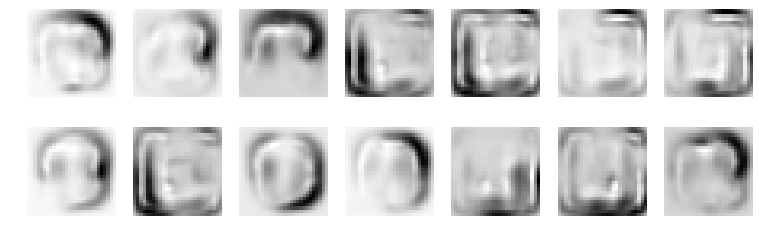

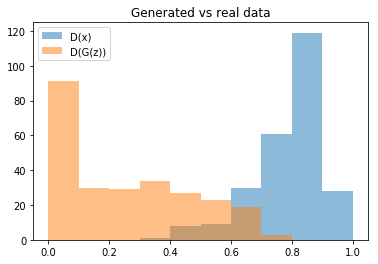

Time for epoch 302 is 23.17726579681039 min
error D: 0.5656712651252747, error G: -0.3160959482192993
Time for epoch 303 is 23.241602547466755 min
error D: 0.575497567653656, error G: -0.319504976272583
Time for epoch 304 is 23.308469131588936 min
error D: 0.565791130065918, error G: -0.3219507336616516
Time for epoch 305 is 23.37482415139675 min
error D: 0.5798115134239197, error G: -0.3313939571380615
Time for epoch 306 is 23.44146091490984 min
error D: 0.6052429676055908, error G: -0.34517019987106323
Time for epoch 307 is 23.506998401135206 min
error D: 0.6026071310043335, error G: -0.34155985713005066
Time for epoch 308 is 23.572586964815855 min
error D: 0.5932939052581787, error G: -0.3410109877586365
Time for epoch 309 is 23.63934076577425 min
error D: 0.610334575176239, error G: -0.3613055944442749
Time for epoch 310 is 23.70512467995286 min
error D: 0.6037865281105042, error G: -0.3577789068222046
Time for epoch 311 is 23.77348966151476 min
error D: 0.5986627340316772, error G

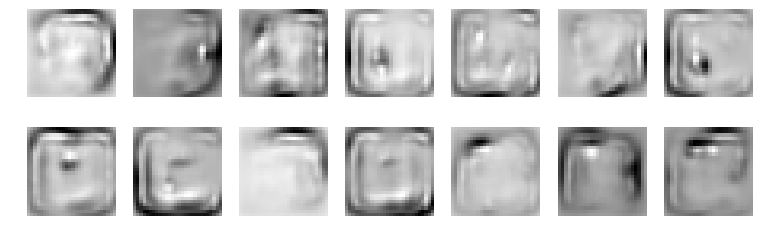

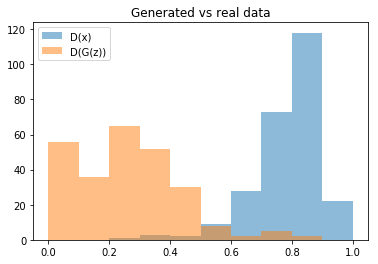

Time for epoch 312 is 23.866612914949656 min
error D: 0.562822163105011, error G: -0.3281041383743286
Time for epoch 313 is 23.932559818029404 min
error D: 0.610031008720398, error G: -0.35215601325035095
Time for epoch 314 is 23.997888263314962 min
error D: 0.588952898979187, error G: -0.33795490860939026
Time for epoch 315 is 24.063130013644695 min
error D: 0.566559910774231, error G: -0.33864349126815796
Time for epoch 316 is 24.130374148488045 min
error D: 0.5723962187767029, error G: -0.3306770622730255
Time for epoch 317 is 24.200204350054264 min
error D: 0.5139080286026001, error G: -0.29688042402267456
Time for epoch 318 is 24.26758486405015 min
error D: 0.5059452652931213, error G: -0.285595566034317
Time for epoch 319 is 24.33274954557419 min
error D: 0.4807858467102051, error G: -0.2696208953857422
Time for epoch 320 is 24.398143764585257 min
error D: 0.5075913071632385, error G: -0.295306921005249
Time for epoch 321 is 24.46540903300047 min
error D: 0.5031141638755798, erro

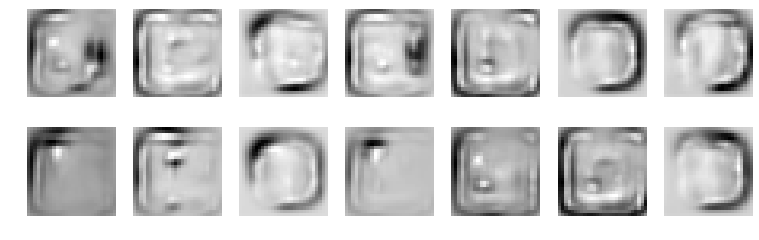

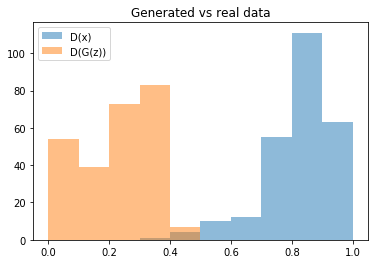

Time for epoch 322 is 24.557155679911375 min
error D: 0.5100635886192322, error G: -0.3039644956588745
Time for epoch 323 is 24.624036882072687 min
error D: 0.5157325267791748, error G: -0.31155693531036377
Time for epoch 324 is 24.691358096897602 min
error D: 0.5408826470375061, error G: -0.3237348794937134
Time for epoch 325 is 24.757374681532383 min
error D: 0.5414936542510986, error G: -0.3271762728691101
Time for epoch 326 is 24.82275114580989 min
error D: 0.5929927825927734, error G: -0.3520580530166626
Time for epoch 327 is 24.888955548405647 min
error D: 0.6153356432914734, error G: -0.3622850179672241
Time for epoch 328 is 24.95592115074396 min
error D: 0.6214877963066101, error G: -0.354436457157135
Time for epoch 329 is 25.02064896374941 min
error D: 0.591022789478302, error G: -0.3341759145259857
Time for epoch 330 is 25.086573012173176 min
error D: 0.551953911781311, error G: -0.3049992024898529
Time for epoch 331 is 25.152926415205002 min
error D: 0.5711434483528137, erro

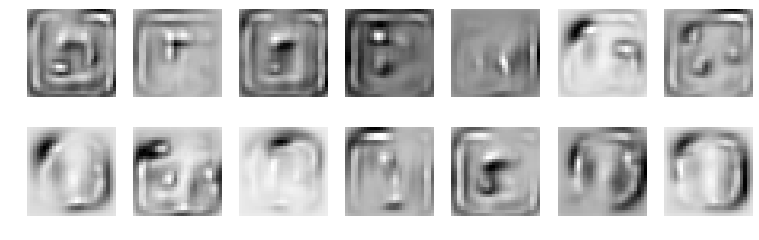

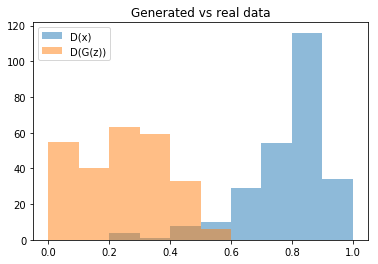

Time for epoch 332 is 25.245679948478937 min
error D: 0.527188241481781, error G: -0.28413233160972595
Time for epoch 333 is 25.3112669326365 min
error D: 0.5246973633766174, error G: -0.2757435142993927
Time for epoch 334 is 25.378910679370165 min
error D: 0.4950695335865021, error G: -0.2627282738685608
Time for epoch 335 is 25.459919329732656 min
error D: 0.49822932481765747, error G: -0.27639925479888916
Time for epoch 336 is 25.53378226235509 min
error D: 0.4652335047721863, error G: -0.2581268548965454
Time for epoch 337 is 25.60842576622963 min
error D: 0.5134509205818176, error G: -0.289169043302536
Time for epoch 338 is 25.681703485548496 min
error D: 0.4811544716358185, error G: -0.27569615840911865
Time for epoch 339 is 25.75417857989669 min
error D: 0.5239852070808411, error G: -0.31516045331954956
Time for epoch 340 is 25.825953282415867 min
error D: 0.5286052823066711, error G: -0.31294047832489014
Time for epoch 341 is 25.898705381900072 min
error D: 0.5466013550758362, 

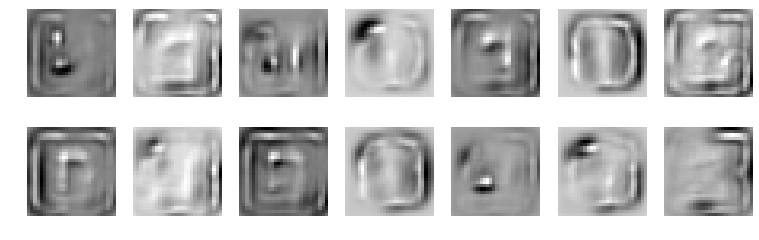

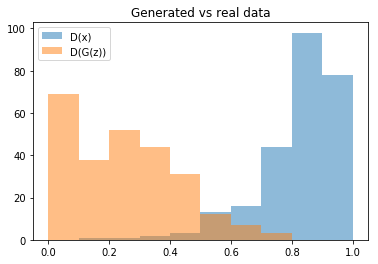

Time for epoch 342 is 26.01147459819913 min
error D: 0.5986687541007996, error G: -0.3548632860183716
Time for epoch 343 is 26.110572084784508 min
error D: 0.5952982902526855, error G: -0.35911816358566284
Time for epoch 344 is 26.189352367073298 min
error D: 0.5973807573318481, error G: -0.3618902862071991
Time for epoch 345 is 26.273382548242807 min
error D: 0.5952320694923401, error G: -0.36034125089645386
Time for epoch 346 is 26.340952046215534 min
error D: 0.6447492837905884, error G: -0.39429718255996704
Time for epoch 347 is 26.43208098039031 min
error D: 0.5944316387176514, error G: -0.3591602146625519
Time for epoch 348 is 26.503711331635714 min
error D: 0.621483325958252, error G: -0.37200266122817993
Time for epoch 349 is 26.579961463809013 min
error D: 0.6039606332778931, error G: -0.3569847345352173
Time for epoch 350 is 26.65595466643572 min
error D: 0.6128472089767456, error G: -0.3694484233856201
Time for epoch 351 is 26.724824517965317 min
error D: 0.5830718874931335,

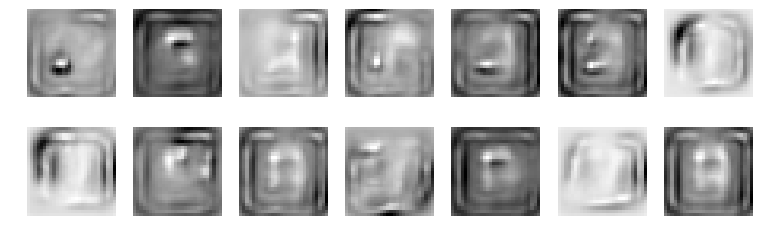

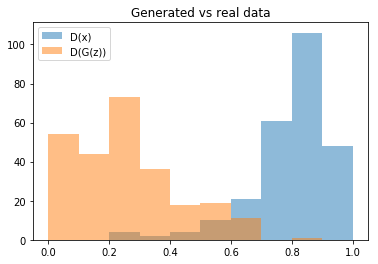

Time for epoch 352 is 26.834974948316813 min
error D: 0.5650618076324463, error G: -0.32905516028404236
Time for epoch 353 is 26.914219465106726 min
error D: 0.5763960480690002, error G: -0.33317720890045166
Time for epoch 354 is 26.98176634684205 min
error D: 0.5800567865371704, error G: -0.3360455632209778
Time for epoch 355 is 27.048594065010548 min
error D: 0.5406440496444702, error G: -0.30610209703445435
Time for epoch 356 is 27.116427212953568 min
error D: 0.5315728783607483, error G: -0.2918890118598938
Time for epoch 357 is 27.18349988013506 min
error D: 0.5102049112319946, error G: -0.2814701795578003
Time for epoch 358 is 27.25459125265479 min
error D: 0.5239604115486145, error G: -0.2835717499256134
Time for epoch 359 is 27.329379551112652 min
error D: 0.5078612565994263, error G: -0.2734508812427521
Time for epoch 360 is 27.413845416158438 min
error D: 0.5223467350006104, error G: -0.28370481729507446
Time for epoch 361 is 27.478594332933426 min
error D: 0.5589756369590759

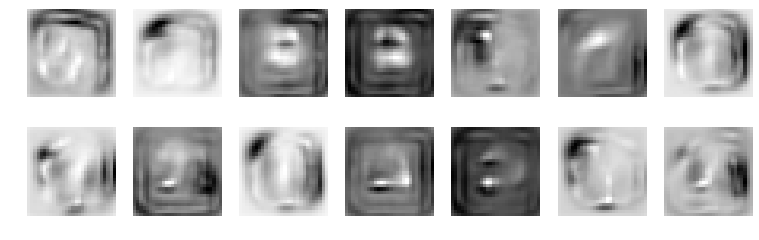

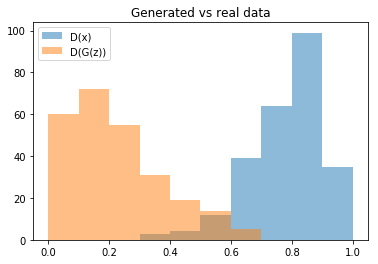

Time for epoch 362 is 27.574312832206488 min
error D: 0.5755205154418945, error G: -0.30135124921798706
Time for epoch 363 is 27.64420571550727 min
error D: 0.5508361458778381, error G: -0.2879657447338104
Time for epoch 364 is 27.740622498095036 min
error D: 0.6227135062217712, error G: -0.3242376148700714
Time for epoch 365 is 27.821417417377234 min
error D: 0.6516098380088806, error G: -0.3439252972602844
Time for epoch 366 is 27.895110715180635 min
error D: 0.6614992022514343, error G: -0.351070761680603
Time for epoch 367 is 27.970307517796755 min
error D: 0.8163021206855774, error G: -0.4364430904388428
Time for epoch 368 is 28.048364713788033 min
error D: 0.7535459995269775, error G: -0.38004329800605774
Time for epoch 369 is 28.119787614792585 min
error D: 0.7680507898330688, error G: -0.38835442066192627
Time for epoch 370 is 28.184007830917835 min
error D: 0.7221689224243164, error G: -0.3412998914718628
Time for epoch 371 is 28.247795667499304 min
error D: 0.681290864944458,

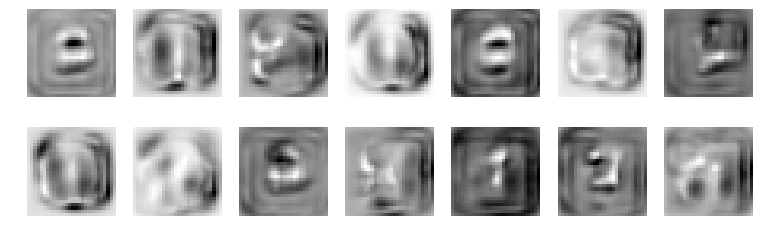

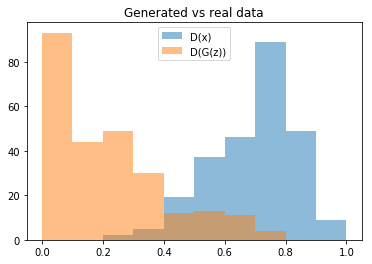

Time for epoch 372 is 28.347953978925943 min
error D: 0.5939469933509827, error G: -0.25711196660995483
Time for epoch 373 is 28.42967338114977 min
error D: 0.5484927892684937, error G: -0.23960036039352417
Time for epoch 374 is 28.498592533171177 min
error D: 0.4981642961502075, error G: -0.22748979926109314
Time for epoch 375 is 28.565607495605946 min
error D: 0.46042415499687195, error G: -0.21929164230823517
Time for epoch 376 is 28.631410896778107 min
error D: 0.4630798101425171, error G: -0.2279948741197586
Time for epoch 377 is 28.698084644973278 min
error D: 0.4226471781730652, error G: -0.21822932362556458
Time for epoch 378 is 28.764272648841143 min
error D: 0.5433717370033264, error G: -0.2884367108345032
Time for epoch 379 is 28.83191178366542 min
error D: 0.5165190696716309, error G: -0.27039361000061035
Time for epoch 380 is 28.898268967866898 min
error D: 0.575300395488739, error G: -0.3071291446685791
Time for epoch 381 is 28.963334314525127 min
error D: 0.6218464970588

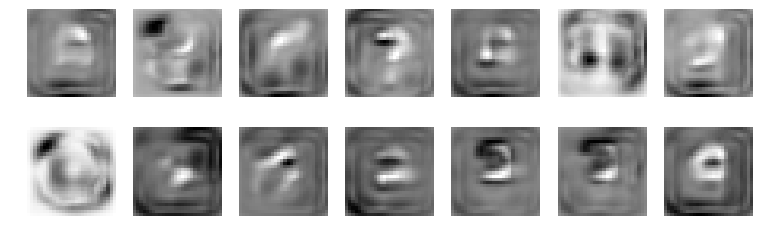

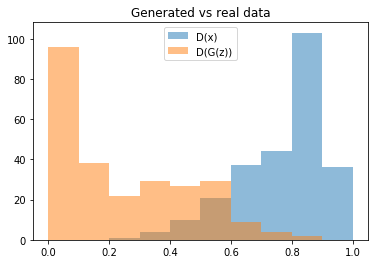

Time for epoch 382 is 29.05584143474698 min
error D: 0.6616326570510864, error G: -0.3462069034576416
Time for epoch 383 is 29.123233277350664 min
error D: 0.7397102117538452, error G: -0.397722989320755
Time for epoch 384 is 29.19250512868166 min
error D: 0.7804369330406189, error G: -0.41448065638542175
Time for epoch 385 is 29.26028348132968 min
error D: 0.6791884303092957, error G: -0.3554582893848419
Time for epoch 386 is 29.327258981764317 min
error D: 0.698106586933136, error G: -0.3681706190109253
Time for epoch 387 is 29.39351061359048 min
error D: 0.6983664631843567, error G: -0.35342490673065186
Time for epoch 388 is 29.458981666713953 min
error D: 0.6811988949775696, error G: -0.35838794708251953
Time for epoch 389 is 29.525500748306513 min
error D: 0.6700858473777771, error G: -0.33983761072158813
Time for epoch 390 is 29.589783899486065 min
error D: 0.623740017414093, error G: -0.3205409049987793
Time for epoch 391 is 29.6546055264771 min
error D: 0.6392011046409607, erro

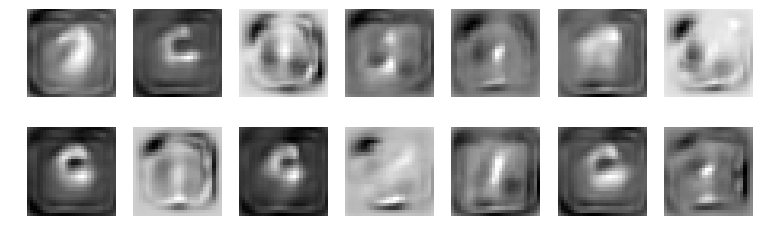

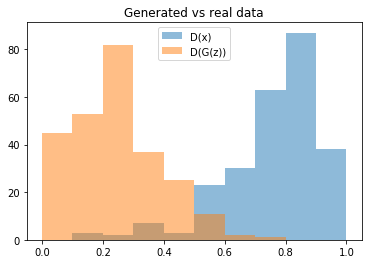

Time for epoch 392 is 29.747490346431732 min
error D: 0.5990659594535828, error G: -0.30803680419921875
Time for epoch 393 is 29.812723230570555 min
error D: 0.5998947024345398, error G: -0.3080317974090576
Time for epoch 394 is 29.879902716726065 min
error D: 0.5868410468101501, error G: -0.2994346022605896
Time for epoch 395 is 29.945732932537794 min
error D: 0.5600465536117554, error G: -0.29695284366607666
Time for epoch 396 is 30.014303233474493 min
error D: 0.6292833089828491, error G: -0.3484049141407013
Time for epoch 397 is 30.086642652750015 min
error D: 0.6838969588279724, error G: -0.37002232670783997
Time for epoch 398 is 30.15823069959879 min
error D: 0.6902246475219727, error G: -0.38798266649246216
Time for epoch 399 is 30.229267332702875 min
error D: 0.6486735343933105, error G: -0.3695436716079712
Time for epoch 400 is 30.298035744577646 min
error D: 0.774097740650177, error G: -0.4250895380973816
Time for epoch 401 is 30.364167161285877 min
error D: 0.738596796989440

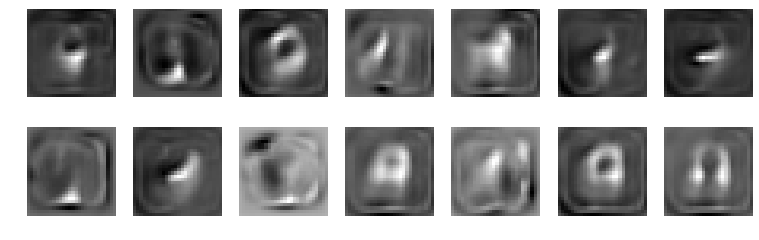

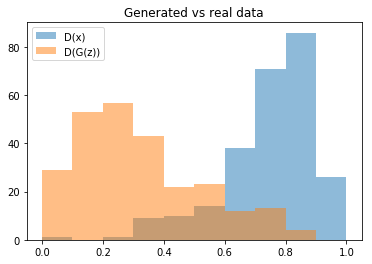

Time for epoch 402 is 30.45386589691043 min
error D: 0.8318548202514648, error G: -0.45588529109954834
Time for epoch 403 is 30.519211266189814 min
error D: 0.7734940052032471, error G: -0.43652617931365967
Time for epoch 404 is 30.58479818329215 min
error D: 0.7450268864631653, error G: -0.4102340042591095
Time for epoch 405 is 30.651256002485752 min
error D: 0.793101966381073, error G: -0.4467514157295227
Time for epoch 406 is 30.71659093350172 min
error D: 0.8253958821296692, error G: -0.44126594066619873
Time for epoch 407 is 30.78108136728406 min
error D: 0.8652514219284058, error G: -0.47451406717300415
Time for epoch 408 is 30.846834912896156 min
error D: 0.8185737729072571, error G: -0.4420679807662964
Time for epoch 409 is 30.9116158336401 min
error D: 0.8607863783836365, error G: -0.4343249797821045
Time for epoch 410 is 30.977320317178965 min
error D: 0.8537173271179199, error G: -0.4394077658653259
Time for epoch 411 is 31.043827395886183 min
error D: 0.9160460233688354, er

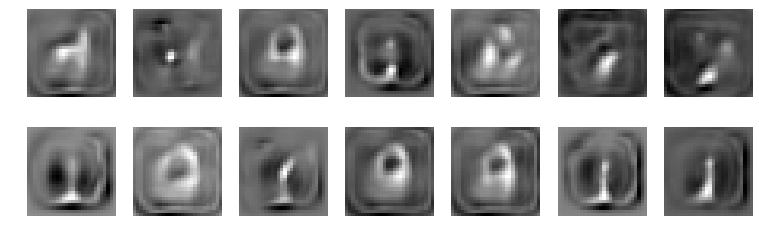

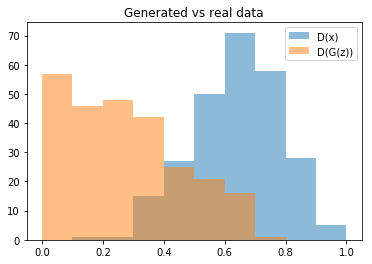

Time for epoch 412 is 31.139437433332205 min
error D: 0.905476450920105, error G: -0.4523000717163086
Time for epoch 413 is 31.205099813640118 min
error D: 0.8588577508926392, error G: -0.41516757011413574
Time for epoch 414 is 31.274938732385635 min
error D: 0.900970458984375, error G: -0.42215901613235474
Time for epoch 415 is 31.342190146446228 min
error D: 0.9469653367996216, error G: -0.48914214968681335
Time for epoch 416 is 31.408988147974014 min
error D: 0.987061083316803, error G: -0.34526169300079346
Time for epoch 417 is 31.475618079304695 min
error D: 1.0837147235870361, error G: -0.6992771029472351
Time for epoch 418 is 31.54275269806385 min
error D: 0.9862218499183655, error G: -0.3285961151123047
Time for epoch 419 is 31.607037264853716 min
error D: 1.0066089630126953, error G: -0.6314668655395508
Time for epoch 420 is 31.672363944351673 min
error D: 1.0898321866989136, error G: -0.2634287476539612
Time for epoch 421 is 31.740889348089695 min
error D: 1.1655162572860718,

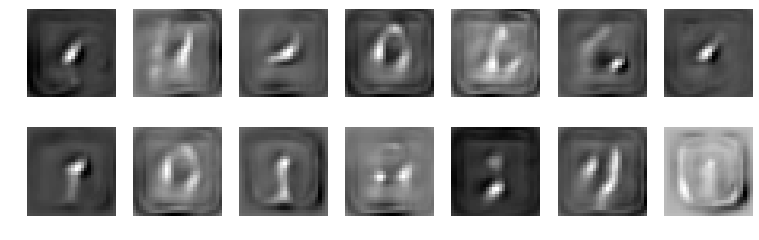

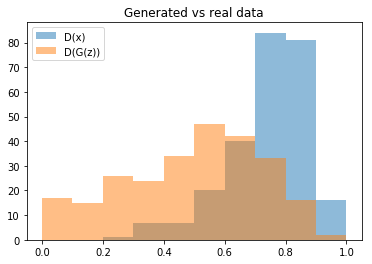

Time for epoch 422 is 31.831063602119684 min
error D: 0.9748775959014893, error G: -0.2690597176551819
Time for epoch 423 is 31.89531284943223 min
error D: 1.0398504734039307, error G: -0.750195324420929
Time for epoch 424 is 31.96310179680586 min
error D: 0.9255267381668091, error G: -0.2558050751686096
Time for epoch 425 is 32.032207529991865 min
error D: 0.9580939412117004, error G: -0.6189095973968506
Time for epoch 426 is 32.09891797974706 min
error D: 0.8920483589172363, error G: -0.29984328150749207
Time for epoch 427 is 32.16804889962077 min
error D: 0.9202030301094055, error G: -0.5296788811683655
Time for epoch 428 is 32.2341573163867 min
error D: 0.8524547219276428, error G: -0.330465704202652
Time for epoch 429 is 32.300290551036596 min
error D: 0.8991755247116089, error G: -0.4721938967704773
Time for epoch 430 is 32.36704374477267 min
error D: 0.8813914060592651, error G: -0.35513538122177124
Time for epoch 431 is 32.4340037368238 min
error D: 0.9228261709213257, error G:

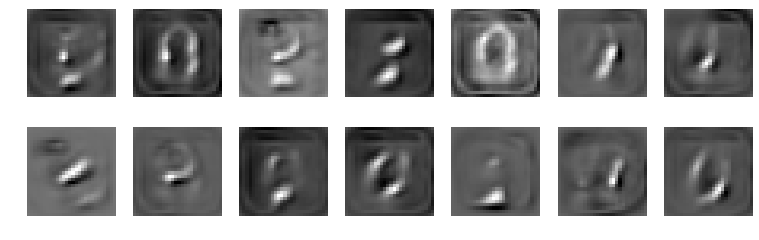

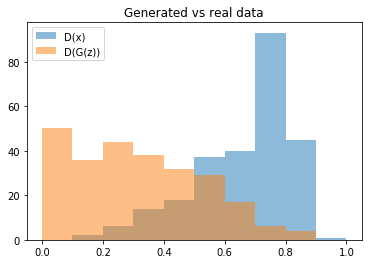

Time for epoch 432 is 32.52800818160176 min
error D: 0.9292956590652466, error G: -0.322139173746109
Time for epoch 433 is 32.59401731565595 min
error D: 0.9124317765235901, error G: -0.5146484375
Time for epoch 434 is 32.66138718277216 min
error D: 0.8441942930221558, error G: -0.34642040729522705
Time for epoch 435 is 32.72941591218114 min
error D: 0.8637272119522095, error G: -0.35759881138801575
Time for epoch 436 is 32.795263916254044 min
error D: 0.8538804650306702, error G: -0.3729856610298157
Time for epoch 437 is 32.86225698143244 min
error D: 0.8737952709197998, error G: -0.31351107358932495
Time for epoch 438 is 32.92754591628909 min
error D: 0.7786197066307068, error G: -0.4075561761856079
Time for epoch 439 is 32.9943841136992 min
error D: 0.7313019037246704, error G: -0.283862441778183
Time for epoch 440 is 33.060825515538454 min
error D: 0.6726335287094116, error G: -0.29651588201522827
Time for epoch 441 is 33.12655773386359 min
error D: 0.6739863157272339, error G: -0.

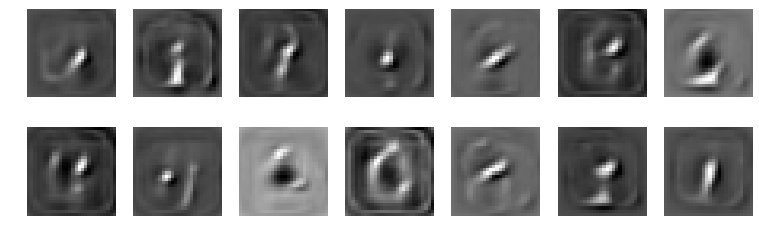

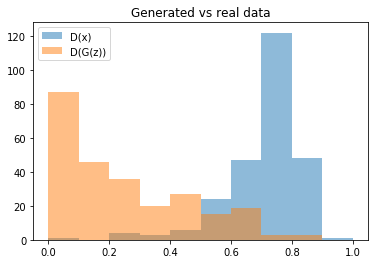

Time for epoch 442 is 33.218695763498545 min
error D: 0.678152322769165, error G: -0.3174552917480469
Time for epoch 443 is 33.28749271854758 min
error D: 0.7347118854522705, error G: -0.34900811314582825
Time for epoch 444 is 33.35476390272379 min
error D: 0.7094027400016785, error G: -0.34742656350135803
Time for epoch 445 is 33.4220833517611 min
error D: 0.7416094541549683, error G: -0.3801265358924866
Time for epoch 446 is 33.49044546857476 min
error D: 0.7394301295280457, error G: -0.3629548251628876
Time for epoch 447 is 33.55870192870498 min
error D: 0.8136450052261353, error G: -0.4495425224304199
Time for epoch 448 is 33.622977681457996 min
error D: 0.9059632420539856, error G: -0.4047645926475525
Time for epoch 449 is 33.69167201220989 min
error D: 0.9410290122032166, error G: -0.5367602705955505
Time for epoch 450 is 33.75775717943907 min
error D: 0.9841229319572449, error G: -0.4974931478500366
Time for epoch 451 is 33.82470219954848 min
error D: 0.9872140884399414, error G

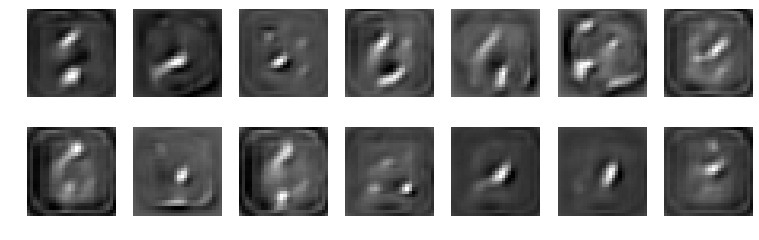

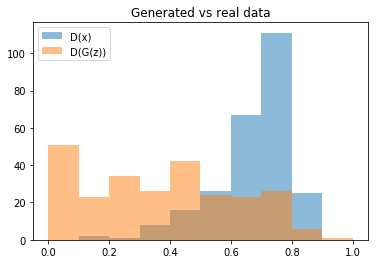

Time for epoch 452 is 33.9167367964983 min
error D: 0.947614312171936, error G: -0.5056428909301758
Time for epoch 453 is 33.982862897217274 min
error D: 0.9091520309448242, error G: -0.5215314626693726
Time for epoch 454 is 34.051931247115135 min
error D: 0.9503630995750427, error G: -0.5174187421798706
Time for epoch 455 is 34.117564767599106 min
error D: 0.9586400389671326, error G: -0.5627943277359009
Time for epoch 456 is 34.18678041920066 min
error D: 0.948352038860321, error G: -0.48920968174934387
Time for epoch 457 is 34.25647645071149 min
error D: 0.8668285608291626, error G: -0.5039336681365967
Time for epoch 458 is 34.32496105134487 min
error D: 0.9013641476631165, error G: -0.49790695309638977
Time for epoch 459 is 34.39076829701662 min
error D: 0.8737852573394775, error G: -0.4963245391845703
Time for epoch 460 is 34.457329481840134 min
error D: 0.8937332630157471, error G: -0.5066929459571838
Time for epoch 461 is 34.52528756484389 min
error D: 0.9462239146232605, error 

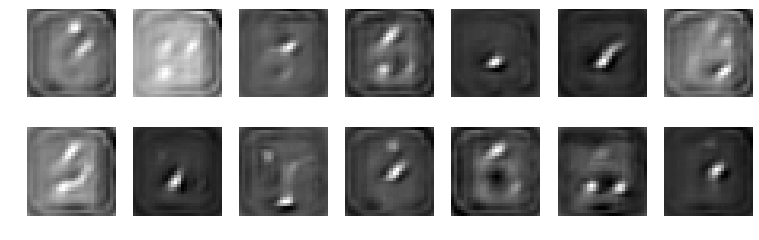

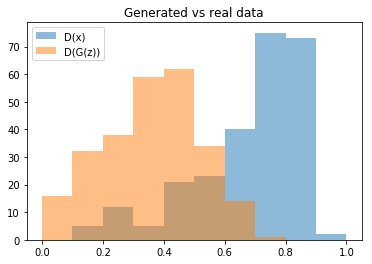

Time for epoch 462 is 34.61851290240884 min
error D: 0.9236128926277161, error G: -0.5168139934539795
Time for epoch 463 is 34.68293986842036 min
error D: 0.9837635159492493, error G: -0.5154241323471069
Time for epoch 464 is 34.748618230223656 min
error D: 1.0097897052764893, error G: -0.5306329727172852
Time for epoch 465 is 34.81406791508198 min
error D: 1.0166171789169312, error G: -0.5223262310028076
Time for epoch 466 is 34.87954868003726 min
error D: 1.0415328741073608, error G: -0.5243356227874756
Time for epoch 467 is 34.94596338272095 min
error D: 1.0523043870925903, error G: -0.5333471894264221
Time for epoch 468 is 35.01289104670286 min
error D: 1.0619535446166992, error G: -0.5570411682128906
Time for epoch 469 is 35.07895424962044 min
error D: 0.9950422048568726, error G: -0.42989015579223633
Time for epoch 470 is 35.14549672976136 min
error D: 1.0554996728897095, error G: -0.6388735771179199
Time for epoch 471 is 35.2129386998713 min
error D: 0.9979532957077026, error G:

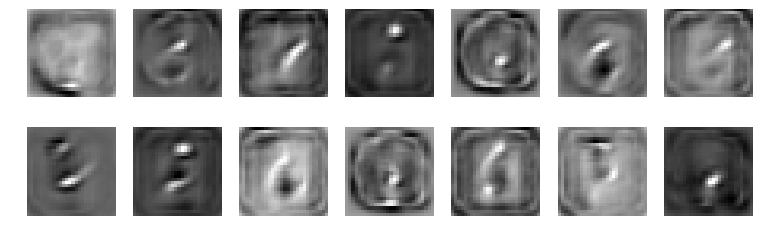

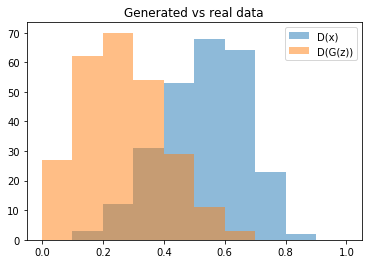

Time for epoch 472 is 35.304909247905016 min
error D: 1.0468318462371826, error G: -0.7569863796234131
Time for epoch 473 is 35.372630547732115 min
error D: 1.0823835134506226, error G: -0.27144211530685425
Time for epoch 474 is 35.43838304653764 min
error D: 1.0357213020324707, error G: -0.695891797542572
Time for epoch 475 is 35.506465297192335 min
error D: 0.9499683380126953, error G: -0.3079372048377991
Time for epoch 476 is 35.57515051588416 min
error D: 0.9561553597450256, error G: -0.6007336378097534
Time for epoch 477 is 35.64300378039479 min
error D: 0.8874752521514893, error G: -0.336256206035614
Time for epoch 478 is 35.71173871308565 min
error D: 0.8750681281089783, error G: -0.5455058813095093
Time for epoch 479 is 35.77792404964566 min
error D: 0.8664118051528931, error G: -0.3064764142036438
Time for epoch 480 is 35.84585181623697 min
error D: 0.9277336001396179, error G: -0.6071497201919556
Time for epoch 481 is 35.91249016299844 min
error D: 0.8082180023193359, error G

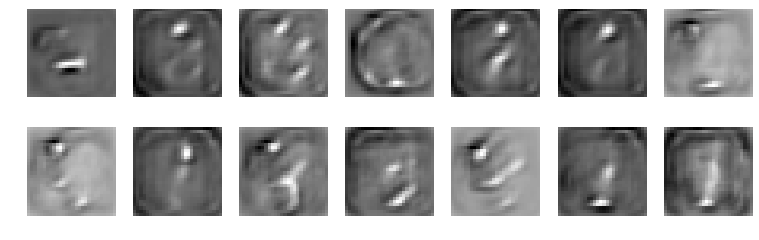

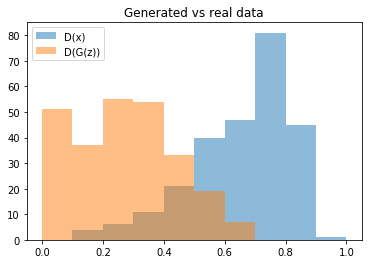

Time for epoch 482 is 36.006093211472034 min
error D: 0.8671920299530029, error G: -0.5186780691146851
Time for epoch 483 is 36.07143613323569 min
error D: 0.8202582001686096, error G: -0.3951554000377655
Time for epoch 484 is 36.13814086467028 min
error D: 0.7998670339584351, error G: -0.4725522994995117
Time for epoch 485 is 36.20611719787121 min
error D: 0.8490971922874451, error G: -0.4248117208480835
Time for epoch 486 is 36.27293409407139 min
error D: 0.8137046098709106, error G: -0.46395236253738403
Time for epoch 487 is 36.3399363681674 min
error D: 0.8184984922409058, error G: -0.4569091796875
Time for epoch 488 is 36.407252464443445 min
error D: 0.8136060833930969, error G: -0.47777724266052246
Time for epoch 489 is 36.47408854961395 min
error D: 0.8202803730964661, error G: -0.4614337980747223
Time for epoch 490 is 36.540147718042135 min
error D: 0.845560610294342, error G: -0.5060491561889648
Time for epoch 491 is 36.6088146828115 min
error D: 0.8496922254562378, error G: -

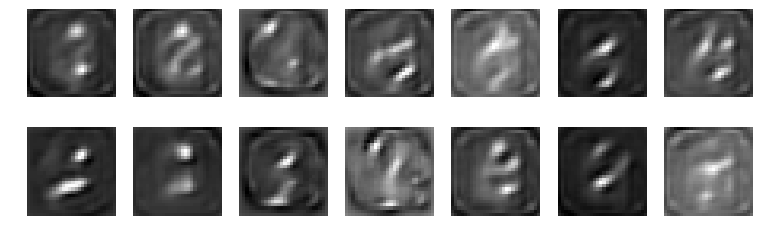

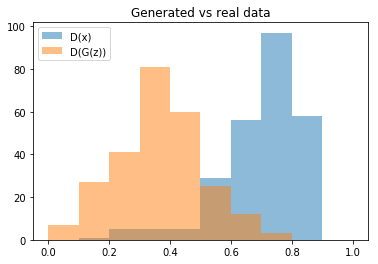

Time for epoch 492 is 36.70049734786153 min
error D: 0.8764326572418213, error G: -0.4866842031478882
Time for epoch 493 is 36.76517893001437 min
error D: 0.9121783375740051, error G: -0.5328373908996582
Time for epoch 494 is 36.83298400044441 min
error D: 0.9816278219223022, error G: -0.5197022557258606
Time for epoch 495 is 36.89886761456728 min
error D: 0.9999919533729553, error G: -0.5455583930015564
Time for epoch 496 is 36.963449630886316 min
error D: 1.106548547744751, error G: -0.694720983505249
Time for epoch 497 is 37.028749883174896 min
error D: 1.169934630393982, error G: -0.3481459617614746
Time for epoch 498 is 37.0929515324533 min
error D: 1.7380495071411133, error G: -1.5031707286834717
Time for epoch 499 is 37.1578025482595 min
error D: 1.4805572032928467, error G: -0.1955934762954712
Time for epoch 500 is 37.22256878390908 min
error D: 1.7201207876205444, error G: -1.476529836654663
Time for epoch 501 is 37.28660253062844 min
error D: 1.3762719631195068, error G: -0.1

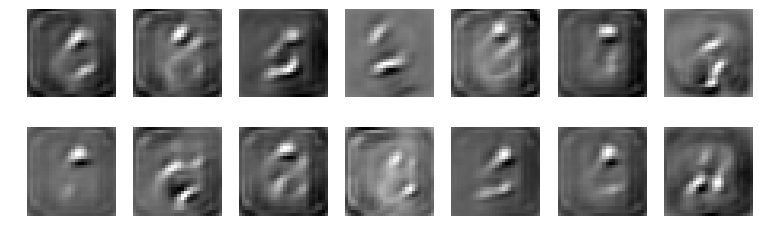

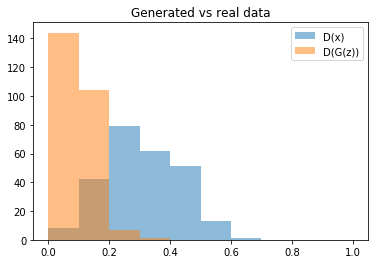

Time for epoch 502 is 37.378074396401644 min
error D: 1.128257155418396, error G: -0.8807171583175659
Time for epoch 503 is 37.44493293389678 min
error D: 0.9936299324035645, error G: -0.07693274319171906
Time for epoch 504 is 37.51395623385906 min
error D: 0.6959876418113708, error G: -0.40494444966316223
Time for epoch 505 is 37.57841622829437 min
error D: 0.5600069761276245, error G: -0.14403407275676727
Time for epoch 506 is 37.64436464756727 min
error D: 0.4829352796077728, error G: -0.20883585512638092
Time for epoch 507 is 37.712186731398106 min
error D: 0.42527201771736145, error G: -0.1437053382396698
Time for epoch 508 is 37.77795608341694 min
error D: 0.38500192761421204, error G: -0.14665915071964264
Time for epoch 509 is 37.845437344163656 min
error D: 0.37116509675979614, error G: -0.14478087425231934
Time for epoch 510 is 37.911756098270416 min
error D: 0.34827426075935364, error G: -0.13141098618507385
Time for epoch 511 is 37.97804693505168 min
error D: 0.3322698771953

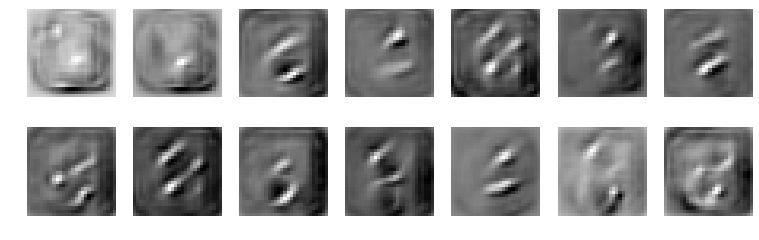

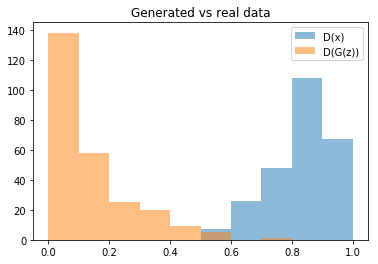

Time for epoch 512 is 38.07020199671388 min
error D: 0.3459964990615845, error G: -0.1387307494878769
Time for epoch 513 is 38.1370789334178 min
error D: 0.34383198618888855, error G: -0.14455845952033997
Time for epoch 514 is 38.20357942953706 min
error D: 0.3707517981529236, error G: -0.15291579067707062
Time for epoch 515 is 38.27282016351819 min
error D: 0.3763083815574646, error G: -0.16482654213905334
Time for epoch 516 is 38.34088775143027 min
error D: 0.4152940809726715, error G: -0.17417065799236298
Time for epoch 517 is 38.40682791545987 min
error D: 0.439773827791214, error G: -0.20498159527778625
Time for epoch 518 is 38.4717657007277 min
error D: 0.47580134868621826, error G: -0.21892693638801575
Time for epoch 519 is 38.537417598068714 min
error D: 0.5223812460899353, error G: -0.2446460723876953
Time for epoch 520 is 38.6017976179719 min
error D: 0.6428380608558655, error G: -0.166145920753479
Time for epoch 521 is 38.66642067953944 min
error D: 0.7530485987663269, error

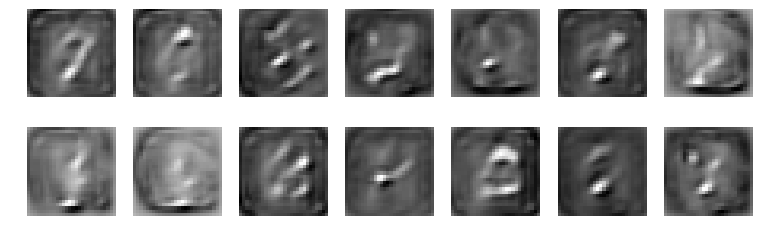

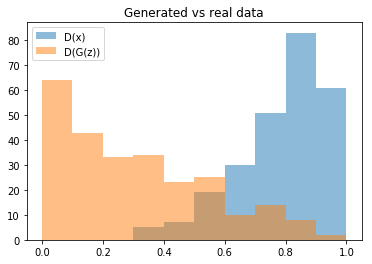

Time for epoch 522 is 38.76313829794526 min
error D: 0.8798639178276062, error G: -0.16823935508728027
Time for epoch 523 is 38.82872927933931 min
error D: 1.243493914604187, error G: -1.022634744644165
Time for epoch 524 is 38.8958884626627 min
error D: 1.27100670337677, error G: -0.11951389908790588
Time for epoch 525 is 38.96316101774573 min
error D: 1.5450518131256104, error G: -1.2847495079040527
Time for epoch 526 is 39.03145856410265 min
error D: 1.2608087062835693, error G: -0.2553144693374634
Time for epoch 527 is 39.097295712679625 min
error D: 1.6740942001342773, error G: -1.3685373067855835
Time for epoch 528 is 39.164977949112654 min
error D: 1.4474387168884277, error G: -0.340890496969223
Time for epoch 529 is 39.23060003295541 min
error D: 1.4233952760696411, error G: -1.0354706048965454
Time for epoch 530 is 39.29534040018916 min
error D: 1.2411903142929077, error G: -0.4433400630950928
Time for epoch 531 is 39.36285526677966 min
error D: 1.078341007232666, error G: -0.

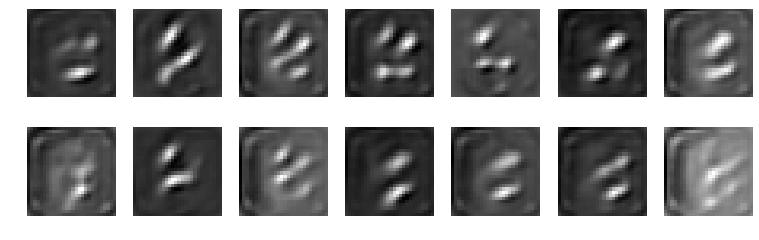

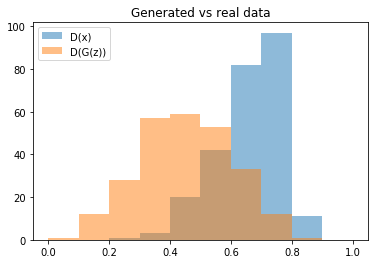

Time for epoch 532 is 39.453527100384235 min
error D: 0.9072321653366089, error G: -0.48200076818466187
Time for epoch 533 is 39.52088361233473 min
error D: 0.7727441191673279, error G: -0.4137745797634125
Time for epoch 534 is 39.58808058127761 min
error D: 0.6472112536430359, error G: -0.3506327271461487
Time for epoch 535 is 39.65432659909129 min
error D: 0.591984748840332, error G: -0.3351229429244995
Time for epoch 536 is 39.72141456604004 min
error D: 0.5542629361152649, error G: -0.3199482262134552
Time for epoch 537 is 39.78697856143117 min
error D: 0.511500895023346, error G: -0.29508817195892334
Time for epoch 538 is 39.8533555008471 min
error D: 0.47604453563690186, error G: -0.28405261039733887
Time for epoch 539 is 39.91935411840677 min
error D: 0.4931033253669739, error G: -0.2967531681060791
Time for epoch 540 is 39.98448879644275 min
error D: 0.491776704788208, error G: -0.2992175221443176
Time for epoch 541 is 40.05009751394391 min
error D: 0.5416446924209595, error G:

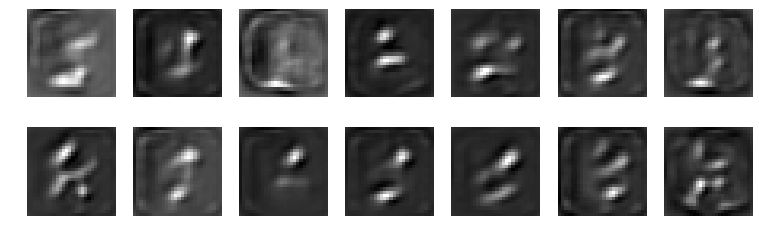

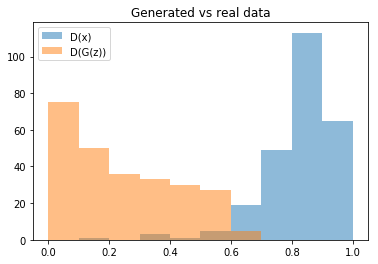

Time for epoch 542 is 40.14066759869456 min
error D: 0.5505410432815552, error G: -0.33063584566116333
Time for epoch 543 is 40.20529992878437 min
error D: 0.5798473358154297, error G: -0.3474310338497162
Time for epoch 544 is 40.27049920335412 min
error D: 0.6183969378471375, error G: -0.3740347623825073
Time for epoch 545 is 40.33588018640876 min
error D: 0.6780246496200562, error G: -0.39862412214279175
Time for epoch 546 is 40.4009761326015 min
error D: 0.7086849808692932, error G: -0.4077564477920532
Time for epoch 547 is 40.468384332954884 min
error D: 0.6984403729438782, error G: -0.3993590176105499
Time for epoch 548 is 40.534346997737885 min
error D: 0.7351917028427124, error G: -0.40607643127441406
Time for epoch 549 is 40.5992812179029 min
error D: 0.7404281497001648, error G: -0.42277640104293823
Time for epoch 550 is 40.663851514458656 min
error D: 0.751858115196228, error G: -0.3918139338493347
Time for epoch 551 is 40.728300146758556 min
error D: 0.7137485146522522, erro

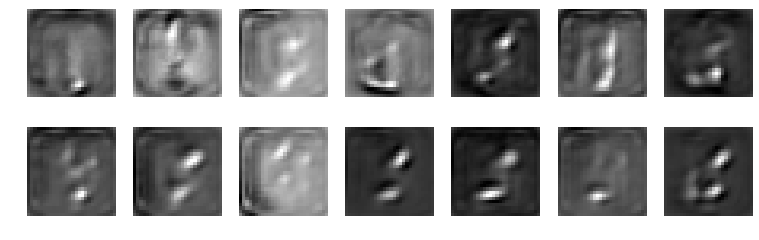

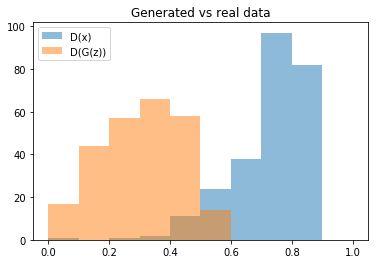

Time for epoch 552 is 40.819192465394735 min
error D: 0.7425928711891174, error G: -0.36401307582855225
Time for epoch 553 is 40.88491663336754 min
error D: 0.7202901840209961, error G: -0.3794024586677551
Time for epoch 554 is 40.950386464595795 min
error D: 0.7326014041900635, error G: -0.35758301615715027
Time for epoch 555 is 41.01632524654269 min
error D: 0.7052716016769409, error G: -0.38068631291389465
Time for epoch 556 is 41.08041138201952 min
error D: 0.7065477967262268, error G: -0.33409929275512695
Time for epoch 557 is 41.14592454954982 min
error D: 0.6893937587738037, error G: -0.39090707898139954
Time for epoch 558 is 41.21031541377306 min
error D: 0.6869220733642578, error G: -0.32846492528915405
Time for epoch 559 is 41.27513198181987 min
error D: 0.711147129535675, error G: -0.3633776903152466
Time for epoch 560 is 41.34003848209977 min
error D: 0.7084805369377136, error G: -0.34535738825798035
Time for epoch 561 is 41.40467891842127 min
error D: 0.7495314478874207, e

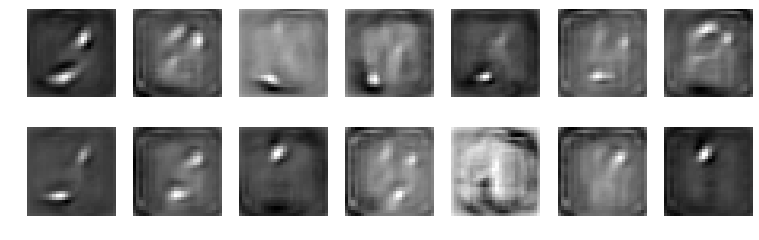

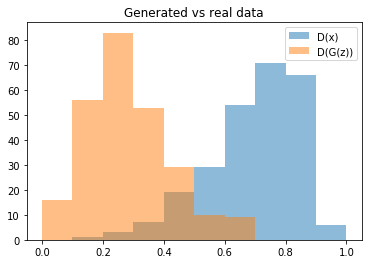

Time for epoch 562 is 41.49625886231661 min
error D: 0.7649921178817749, error G: -0.43875494599342346
Time for epoch 563 is 41.57344659790397 min
error D: 0.7761290669441223, error G: -0.38889646530151367
Time for epoch 564 is 41.67409259825945 min
error D: 0.7820507287979126, error G: -0.38036221265792847
Time for epoch 565 is 41.76987645030022 min
error D: 0.8530288338661194, error G: -0.4837060570716858
Time for epoch 566 is 41.85988416150212 min
error D: 0.9112416505813599, error G: -0.435709148645401
Time for epoch 567 is 41.93485466390848 min
error D: 0.8946481943130493, error G: -0.5430137515068054
Time for epoch 568 is 42.022785380482674 min
error D: 0.9194127321243286, error G: -0.43930163979530334
Time for epoch 569 is 42.110743802040815 min
error D: 0.9581416249275208, error G: -0.6362411975860596
Time for epoch 570 is 42.19916941598058 min
error D: 0.9214004278182983, error G: -0.34596699476242065
Time for epoch 571 is 42.283028196543455 min
error D: 0.9354631900787354, er

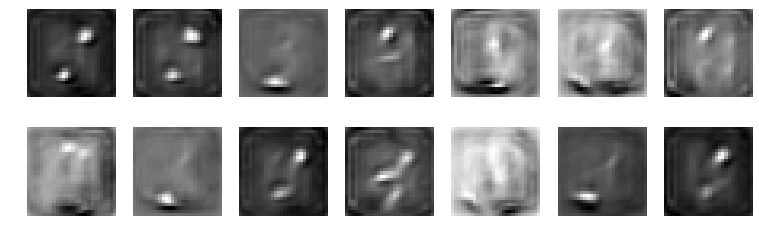

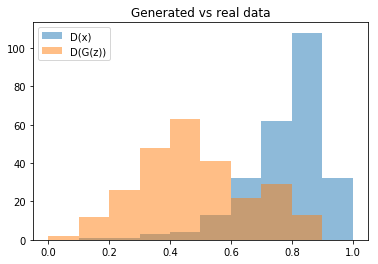

Time for epoch 572 is 42.40575596690178 min
error D: 0.88355553150177, error G: -0.33516639471054077
Time for epoch 573 is 42.47782193124294 min
error D: 0.8505314588546753, error G: -0.5599707365036011
Time for epoch 574 is 42.54900848120451 min
error D: 0.8636515736579895, error G: -0.3183494806289673
Time for epoch 575 is 42.62584911286831 min
error D: 0.7694785594940186, error G: -0.5035105347633362
Time for epoch 576 is 42.728538915514946 min
error D: 0.7518411874771118, error G: -0.32232123613357544
Time for epoch 577 is 42.8049953840673 min
error D: 0.6669186949729919, error G: -0.38964033126831055
Time for epoch 578 is 42.87206721678376 min
error D: 0.6263759732246399, error G: -0.3015247583389282
Time for epoch 579 is 42.938592717051506 min
error D: 0.6381928324699402, error G: -0.3659326434135437
Time for epoch 580 is 43.008209981024265 min
error D: 0.5803698301315308, error G: -0.28314846754074097
Time for epoch 581 is 43.09167082980275 min
error D: 0.5686575174331665, error

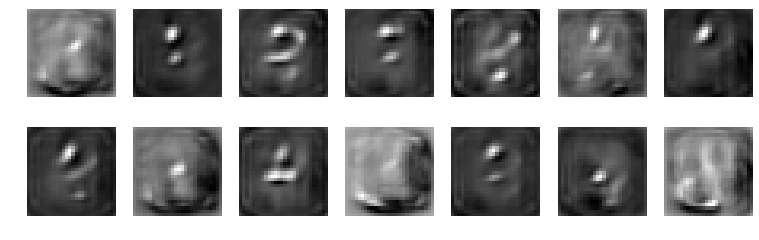

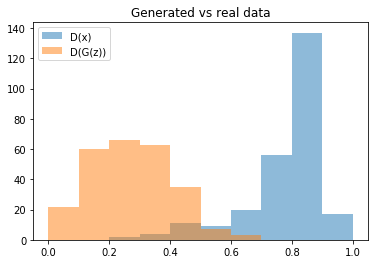

Time for epoch 582 is 43.20981511846185 min
error D: 0.5850241184234619, error G: -0.3107239603996277
Time for epoch 583 is 43.2780996337533 min
error D: 0.5815132260322571, error G: -0.28186482191085815
Time for epoch 584 is 43.348910331726074 min
error D: 0.5918445587158203, error G: -0.3095620274543762
Time for epoch 585 is 43.42498863115907 min
error D: 0.5612336993217468, error G: -0.28405117988586426
Time for epoch 586 is 43.52280071750283 min
error D: 0.6178484559059143, error G: -0.2983884811401367
Time for epoch 587 is 43.61216801404953 min
error D: 0.699618399143219, error G: -0.39935505390167236
Time for epoch 588 is 43.69349117949605 min
error D: 0.6887838244438171, error G: -0.31082814931869507
Time for epoch 589 is 43.765503499656916 min
error D: 0.759026825428009, error G: -0.45746636390686035
Time for epoch 590 is 43.833234898746014 min
error D: 0.8103203177452087, error G: -0.2990333139896393
Time for epoch 591 is 43.897623378783464 min
error D: 0.9090437889099121, err

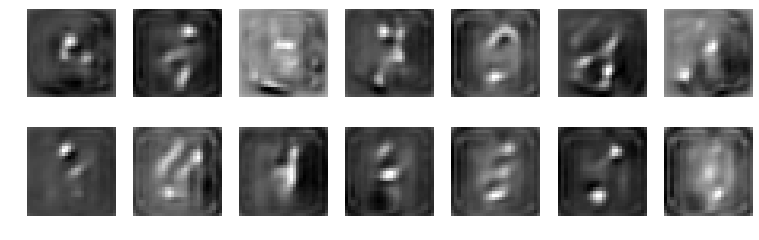

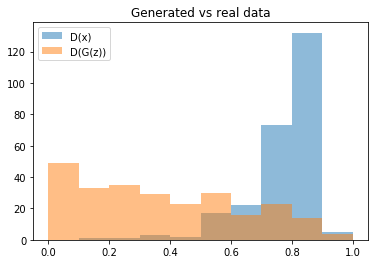

Time for epoch 592 is 44.00933915004134 min
error D: 1.0270378589630127, error G: -0.1581173688173294
Time for epoch 593 is 44.08671960234642 min
error D: 1.1988797187805176, error G: -1.0236194133758545
Time for epoch 594 is 44.15867153182626 min
error D: 1.1396913528442383, error G: -0.1447141319513321
Time for epoch 595 is 44.224983762949705 min
error D: 1.0920429229736328, error G: -0.8971190452575684
Time for epoch 596 is 44.30405405163765 min
error D: 1.2973763942718506, error G: -0.0890987366437912
Time for epoch 597 is 44.38560739904642 min
error D: 1.3140130043029785, error G: -1.1418616771697998
Time for epoch 598 is 44.45857583358884 min
error D: 1.0723520517349243, error G: -0.09264080226421356
Time for epoch 599 is 44.52574369683862 min
error D: 1.2207812070846558, error G: -1.0625094175338745
Time for epoch 600 is 44.59248873218894 min
error D: 0.938046932220459, error G: -0.08231419324874878
Time for epoch 601 is 44.65808109566569 min
error D: 0.8930860161781311, error G

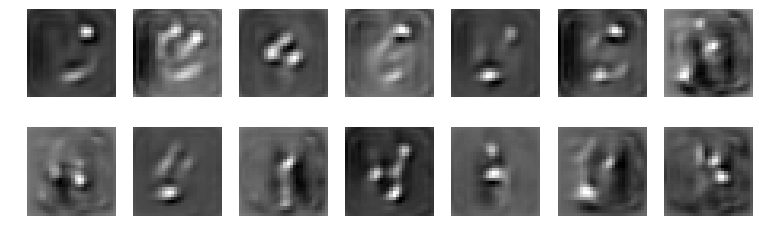

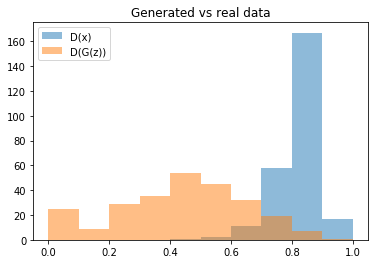

Time for epoch 602 is 44.75185386836529 min
error D: 0.6792435050010681, error G: -0.14666497707366943
Time for epoch 603 is 44.817659832537174 min
error D: 0.7690224051475525, error G: -0.5343285799026489
Time for epoch 604 is 44.88641056418419 min
error D: 0.6758265495300293, error G: -0.1852721869945526
Time for epoch 605 is 44.95557809993625 min
error D: 0.6485633850097656, error G: -0.38914939761161804
Time for epoch 606 is 45.025573782622814 min
error D: 0.6871926784515381, error G: -0.22663873434066772
Time for epoch 607 is 45.09229548275471 min
error D: 0.7268456816673279, error G: -0.4706957936286926
Time for epoch 608 is 45.16136223077774 min
error D: 0.7142701745033264, error G: -0.2472318708896637
Time for epoch 609 is 45.23014601692557 min
error D: 0.8242480754852295, error G: -0.5417793989181519
Time for epoch 610 is 45.29666791856289 min
error D: 0.8123506903648376, error G: -0.2913571894168854
Time for epoch 611 is 45.36237468197942 min
error D: 0.8709598183631897, erro

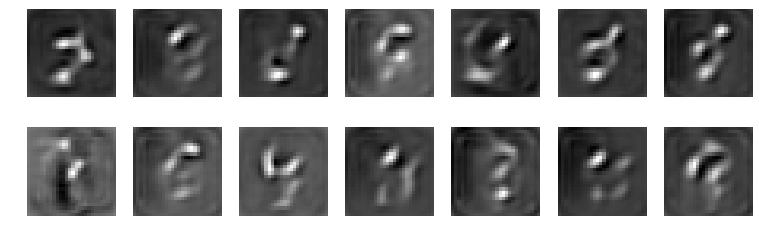

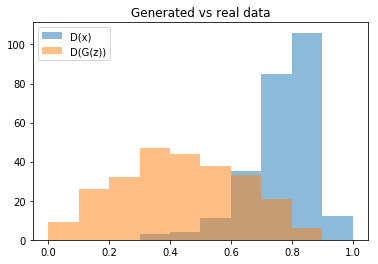

Time for epoch 612 is 45.455032009631395 min
error D: 0.800665557384491, error G: -0.2951446771621704
Time for epoch 613 is 45.52308272942901 min
error D: 0.8673165440559387, error G: -0.5843743681907654
Time for epoch 614 is 45.59044836834073 min
error D: 0.7795915007591248, error G: -0.3465748429298401
Time for epoch 615 is 45.658222146332264 min
error D: 0.768860936164856, error G: -0.4752427935600281
Time for epoch 616 is 45.72855048254132 min
error D: 0.6731810569763184, error G: -0.3589365482330322
Time for epoch 617 is 45.794996812939644 min
error D: 0.6625139117240906, error G: -0.37401703000068665
Time for epoch 618 is 45.86256830021739 min
error D: 0.6096528768539429, error G: -0.32298749685287476
Time for epoch 619 is 45.92842831090093 min
error D: 0.589091420173645, error G: -0.323908269405365
Time for epoch 620 is 45.991903986781836 min
error D: 0.5602344274520874, error G: -0.3083406686782837
Time for epoch 621 is 46.05744418501854 min
error D: 0.6035596132278442, error G

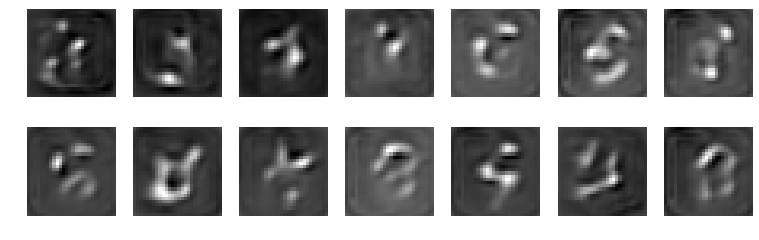

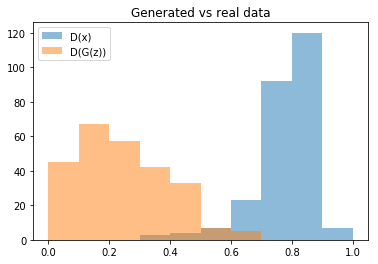

Time for epoch 622 is 46.15223877876997 min
error D: 0.5724267363548279, error G: -0.3219589591026306
Time for epoch 623 is 46.22058176621795 min
error D: 0.6087092161178589, error G: -0.32786786556243896
Time for epoch 624 is 46.28802876546979 min
error D: 0.6486724615097046, error G: -0.3574170470237732
Time for epoch 625 is 46.355793330818415 min
error D: 0.632727324962616, error G: -0.3295862078666687
Time for epoch 626 is 46.422319531440735 min
error D: 0.696729838848114, error G: -0.3886135220527649
Time for epoch 627 is 46.489264614880085 min
error D: 0.688040554523468, error G: -0.3161912262439728
Time for epoch 628 is 46.55544278398156 min
error D: 0.7685893177986145, error G: -0.5033680200576782
Time for epoch 629 is 46.62083660066128 min
error D: 0.7598409056663513, error G: -0.27444976568222046
Time for epoch 630 is 46.68790341541171 min
error D: 0.8643739819526672, error G: -0.6210553646087646
Time for epoch 631 is 46.75387446582317 min
error D: 0.8641077280044556, error G

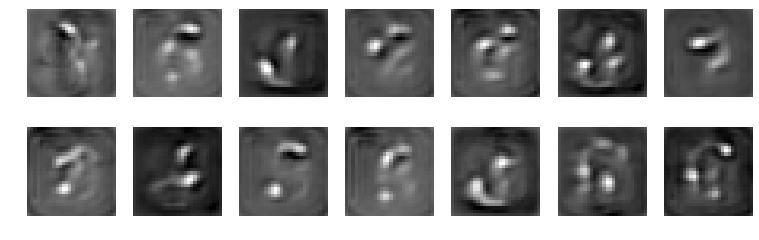

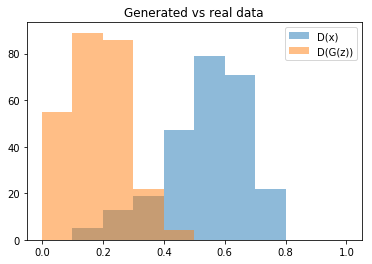

Time for epoch 632 is 46.845525931566954 min
error D: 0.9179073572158813, error G: -0.6842374801635742
Time for epoch 633 is 46.91225704923272 min
error D: 0.8961321711540222, error G: -0.19766175746917725
Time for epoch 634 is 46.9787276647985 min
error D: 1.0135589838027954, error G: -0.7999719977378845
Time for epoch 635 is 47.04678671434522 min
error D: 0.9261037111282349, error G: -0.16590313613414764
Time for epoch 636 is 47.11367624998093 min
error D: 0.9993734359741211, error G: -0.8039957284927368
Time for epoch 637 is 47.18067378178239 min
error D: 0.9323895573616028, error G: -0.16398712992668152
Time for epoch 638 is 47.247758995741606 min
error D: 1.0080902576446533, error G: -0.8053227663040161
Time for epoch 639 is 47.313672214746475 min
error D: 0.8835561871528625, error G: -0.19657960534095764
Time for epoch 640 is 47.38077253103256 min
error D: 0.9941161870956421, error G: -0.7797024250030518
Time for epoch 641 is 47.44684478640556 min
error D: 0.9518081545829773, err

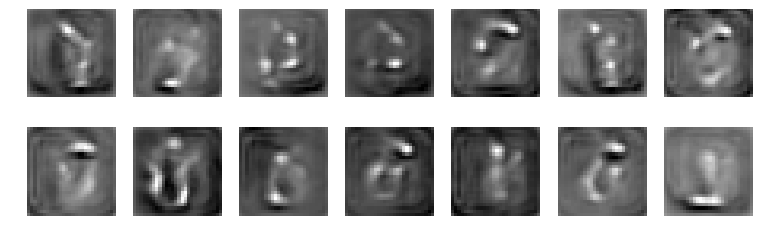

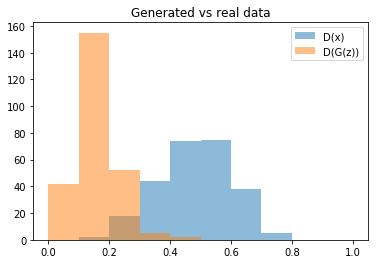

Time for epoch 642 is 47.53945221379399 min
error D: 0.9616469740867615, error G: -0.7150290608406067
Time for epoch 643 is 47.60672429949045 min
error D: 1.0005247592926025, error G: -0.20608848333358765
Time for epoch 644 is 47.672167267650366 min
error D: 1.098880410194397, error G: -0.8743381500244141
Time for epoch 645 is 47.74190013110638 min
error D: 1.0321907997131348, error G: -0.24200385808944702
Time for epoch 646 is 47.807266894727945 min
error D: 1.1148761510849, error G: -0.8807130455970764
Time for epoch 647 is 47.8740551173687 min
error D: 1.0079673528671265, error G: -0.2832527160644531
Time for epoch 648 is 47.939659882336855 min
error D: 1.090733528137207, error G: -0.8332043886184692
Time for epoch 649 is 48.00529818236828 min
error D: 1.0386481285095215, error G: -0.3273358941078186
Time for epoch 650 is 48.07314173132181 min
error D: 1.0742758512496948, error G: -0.7769677639007568
Time for epoch 651 is 48.139085046947 min
error D: 1.0139769315719604, error G: -0.

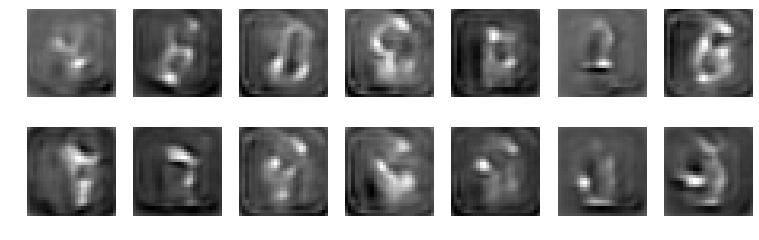

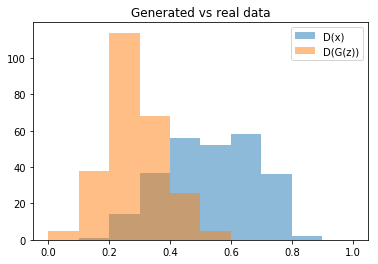

Time for epoch 652 is 48.23205158114433 min
error D: 1.0519366264343262, error G: -0.7728966474533081
Time for epoch 653 is 48.32897883281112 min
error D: 0.9559901356697083, error G: -0.37363332509994507
Time for epoch 654 is 48.42760918289423 min
error D: 0.9598181247711182, error G: -0.6460437178611755
Time for epoch 655 is 48.50185352936387 min
error D: 0.8671607971191406, error G: -0.3691369295120239
Time for epoch 656 is 48.571714732795954 min
error D: 0.8951383829116821, error G: -0.5995771288871765
Time for epoch 657 is 48.63892784714699 min
error D: 0.8364968299865723, error G: -0.3533681035041809
Time for epoch 658 is 48.70356076210737 min
error D: 0.8145419955253601, error G: -0.5342384576797485
Time for epoch 659 is 48.769038166850805 min
error D: 0.7690517902374268, error G: -0.3492681682109833
Time for epoch 660 is 48.83419278264046 min
error D: 0.7781745195388794, error G: -0.4813350439071655
Time for epoch 661 is 48.90063714981079 min
error D: 0.7581378817558289, error 

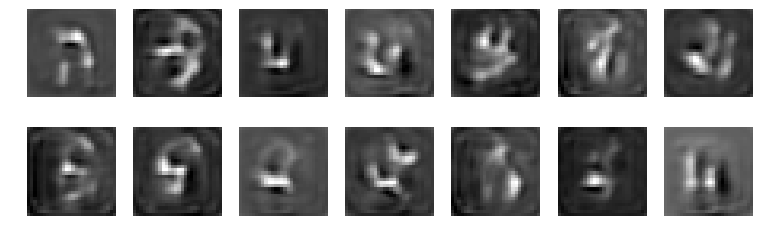

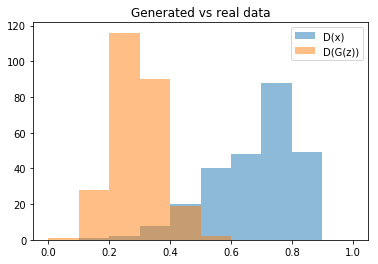

Time for epoch 662 is 48.991260048002005 min
error D: 0.7610419988632202, error G: -0.461911141872406
Time for epoch 663 is 49.06013001129031 min
error D: 0.7573532462120056, error G: -0.3255697190761566
Time for epoch 664 is 49.127914380282164 min
error D: 0.7988077998161316, error G: -0.5286900401115417
Time for epoch 665 is 49.19496941566467 min
error D: 0.7671356201171875, error G: -0.25837889313697815
Time for epoch 666 is 49.26154991611838 min
error D: 0.8949594497680664, error G: -0.6780245304107666
Time for epoch 667 is 49.32767612859607 min
error D: 0.8907924294471741, error G: -0.20350755751132965
Time for epoch 668 is 49.39577924832702 min
error D: 0.9656957387924194, error G: -0.7538449764251709
Time for epoch 669 is 49.464184798300266 min
error D: 0.9759963154792786, error G: -0.19197604060173035
Time for epoch 670 is 49.531270399689674 min
error D: 1.018847942352295, error G: -0.8132331967353821
Time for epoch 671 is 49.606049582362175 min
error D: 1.019209861755371, erro

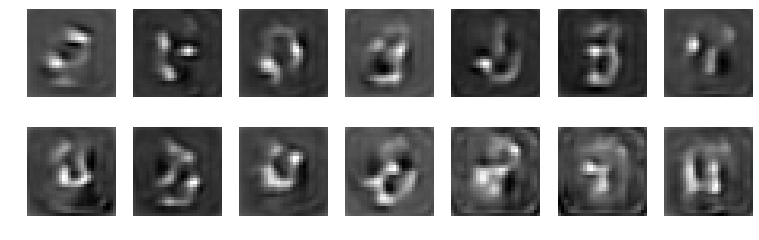

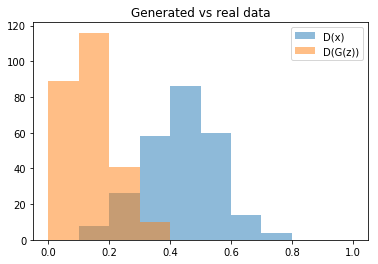

Time for epoch 672 is 49.730494901537895 min
error D: 1.1523550748825073, error G: -0.9525841474533081
Time for epoch 673 is 49.81937716528773 min
error D: 1.0096251964569092, error G: -0.16384732723236084
Time for epoch 674 is 49.902815382927656 min
error D: 1.061199426651001, error G: -0.8468749523162842
Time for epoch 675 is 49.99148213490844 min
error D: 1.0929834842681885, error G: -0.17373445630073547
Time for epoch 676 is 50.06198648363352 min
error D: 1.2163881063461304, error G: -0.9826041460037231
Time for epoch 677 is 50.130497217178345 min
error D: 1.1828105449676514, error G: -0.16147544980049133
Time for epoch 678 is 50.20011166483164 min
error D: 1.4347490072250366, error G: -1.2015328407287598
Time for epoch 679 is 50.26820641383529 min
error D: 1.2079694271087646, error G: -0.22521191835403442
Time for epoch 680 is 50.334459230303764 min
error D: 1.4704984426498413, error G: -1.190086841583252
Time for epoch 681 is 50.402768183499575 min
error D: 1.327308177947998, err

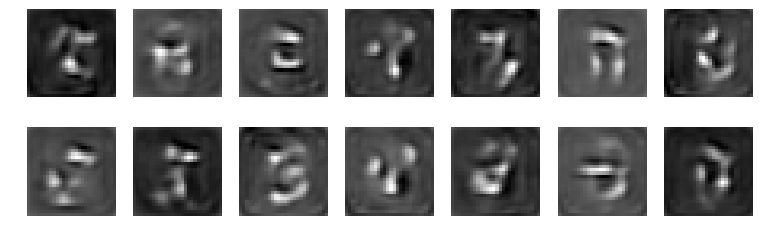

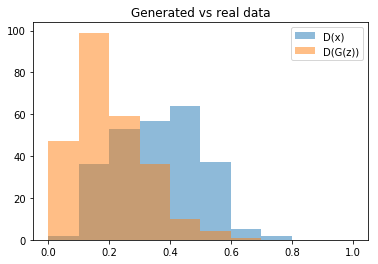

Time for epoch 682 is 50.50183121487498 min
error D: 1.469778060913086, error G: -1.148924708366394
Time for epoch 683 is 50.569779481738806 min
error D: 1.4551981687545776, error G: -0.2780737280845642
Time for epoch 684 is 50.64187176525593 min
error D: 1.4884198904037476, error G: -1.1165510416030884
Time for epoch 685 is 50.708905048668385 min
error D: 1.421127200126648, error G: -0.32200726866722107
Time for epoch 686 is 50.781457114964724 min
error D: 1.432002067565918, error G: -1.063467264175415
Time for epoch 687 is 50.84889183193445 min
error D: 1.2380532026290894, error G: -0.317597359418869
Time for epoch 688 is 50.91698294505477 min
error D: 1.1759313344955444, error G: -0.7710844278335571
Time for epoch 689 is 50.98292161524296 min
error D: 1.0588611364364624, error G: -0.3229081332683563
Time for epoch 690 is 51.04976658523083 min
error D: 0.9653636813163757, error G: -0.5798218250274658
Time for epoch 691 is 51.1161666624248 min
error D: 0.8464112281799316, error G: -0.

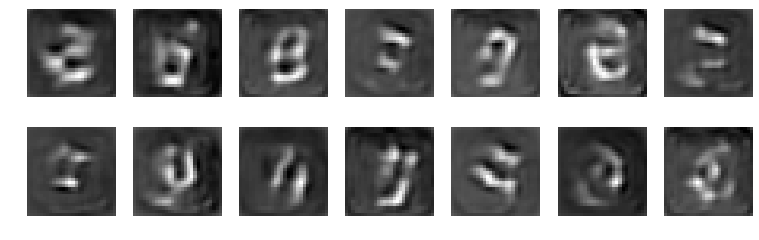

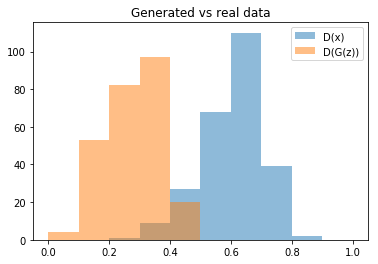

Time for epoch 692 is 51.20988366752863 min
error D: 0.7782525420188904, error G: -0.3749384880065918
Time for epoch 693 is 51.277158584445715 min
error D: 0.7587924003601074, error G: -0.334464430809021
Time for epoch 694 is 51.34352019801736 min
error D: 0.7031656503677368, error G: -0.31931203603744507
Time for epoch 695 is 51.41169225051999 min
error D: 0.6886200308799744, error G: -0.33566415309906006
Time for epoch 696 is 51.47831713408232 min
error D: 0.6490840911865234, error G: -0.28183186054229736
Time for epoch 697 is 51.54902893304825 min
error D: 0.6010268330574036, error G: -0.2811392545700073
Time for epoch 698 is 51.616110015660524 min
error D: 0.6196357011795044, error G: -0.3033762276172638
Time for epoch 699 is 51.68193343281746 min
error D: 0.6271024346351624, error G: -0.2890613079071045
Time for epoch 700 is 51.74994181469083 min
error D: 0.6180046796798706, error G: -0.30467620491981506
Time for epoch 701 is 51.81497944518924 min
error D: 0.6084110736846924, erro

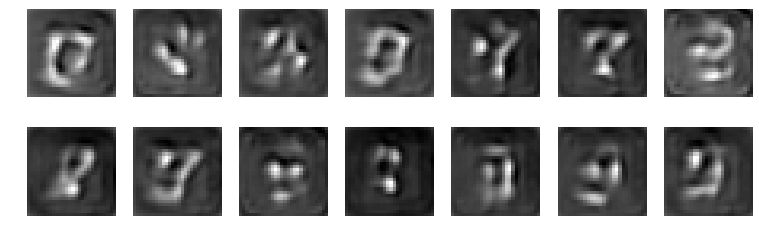

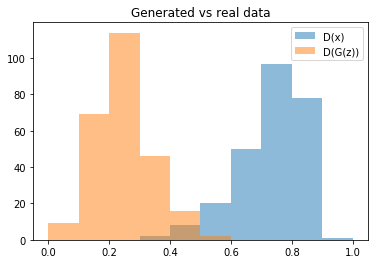

Time for epoch 702 is 51.91165841370821 min
error D: 0.6649540662765503, error G: -0.34519723057746887
Time for epoch 703 is 51.980417765676975 min
error D: 0.6481788158416748, error G: -0.28896963596343994
Time for epoch 704 is 52.04923876747489 min
error D: 0.6814055442810059, error G: -0.3265814483165741
Time for epoch 705 is 52.118033315986395 min
error D: 0.6932052373886108, error G: -0.3344120383262634
Time for epoch 706 is 52.183547884225845 min
error D: 0.7027382850646973, error G: -0.3133290708065033
Time for epoch 707 is 52.250298134982586 min
error D: 0.7029538750648499, error G: -0.37866953015327454
Time for epoch 708 is 52.31583686172962 min
error D: 0.7406724095344543, error G: -0.3076193332672119
Time for epoch 709 is 52.38280349969864 min
error D: 0.7854442000389099, error G: -0.4980267286300659
Time for epoch 710 is 52.44994096830487 min
error D: 0.8109215497970581, error G: -0.28802257776260376
Time for epoch 711 is 52.516136296093464 min
error D: 0.8991889357566833, 

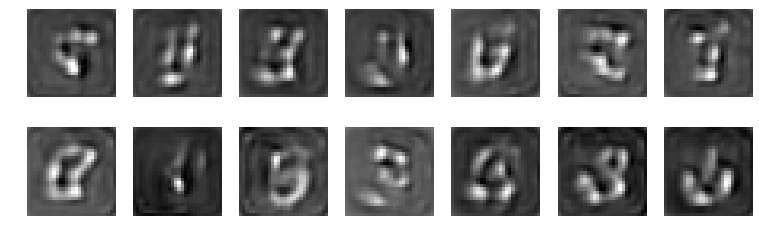

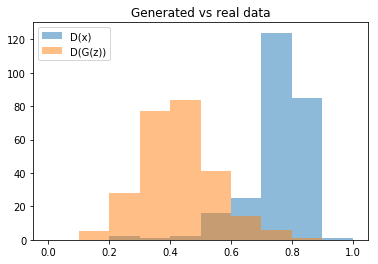

Time for epoch 712 is 52.60998269915581 min
error D: 0.9048901796340942, error G: -0.29755282402038574
Time for epoch 713 is 52.67802929878235 min
error D: 0.9935039281845093, error G: -0.6966232061386108
Time for epoch 714 is 52.7439114972949 min
error D: 1.0501044988632202, error G: -0.3314144015312195
Time for epoch 715 is 52.811371717602015 min
error D: 1.1442965269088745, error G: -0.8571022152900696
Time for epoch 716 is 52.876450046896935 min
error D: 1.095931053161621, error G: -0.3661891222000122
Time for epoch 717 is 52.940958235412836 min
error D: 1.2116750478744507, error G: -0.9010512232780457
Time for epoch 718 is 53.00438913330436 min
error D: 1.2074205875396729, error G: -0.4452778697013855
Time for epoch 719 is 53.07180763036013 min
error D: 1.3069398403167725, error G: -0.948834240436554
Time for epoch 720 is 53.13783146440983 min
error D: 1.3397934436798096, error G: -0.49940112233161926
Time for epoch 721 is 53.205143466591835 min
error D: 1.3420053720474243, error 

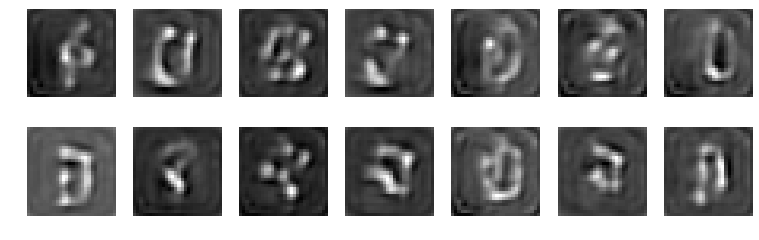

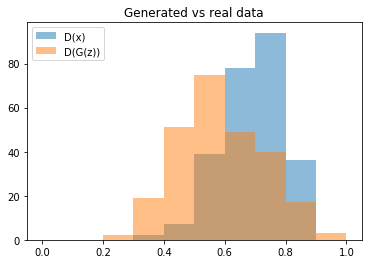

Time for epoch 722 is 53.30181081593037 min
error D: 1.344731092453003, error G: -0.5104331970214844
Time for epoch 723 is 53.368871450424194 min
error D: 1.3987165689468384, error G: -1.0233736038208008
Time for epoch 724 is 53.435339368879795 min
error D: 1.3008568286895752, error G: -0.48564523458480835
Time for epoch 725 is 53.50532751530409 min
error D: 1.3270130157470703, error G: -0.998371958732605
Time for epoch 726 is 53.57665438205004 min
error D: 1.171524167060852, error G: -0.4203645884990692
Time for epoch 727 is 53.64551583305001 min
error D: 1.1726248264312744, error G: -0.8531813621520996
Time for epoch 728 is 53.713393434882164 min
error D: 1.1194705963134766, error G: -0.36176949739456177
Time for epoch 729 is 53.77822579443455 min
error D: 1.1148110628128052, error G: -0.8375015258789062
Time for epoch 730 is 53.842911034822464 min
error D: 1.013625144958496, error G: -0.3080994784832001
Time for epoch 731 is 53.90831544995308 min
error D: 1.0355186462402344, error G

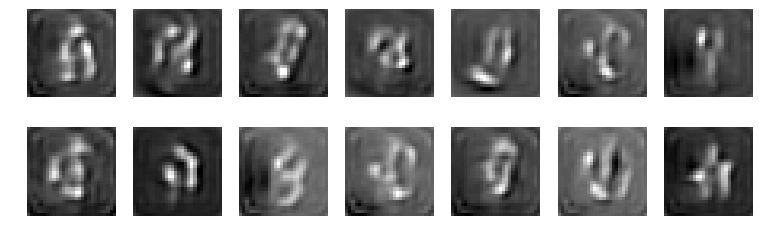

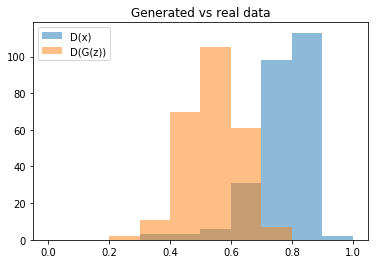

Time for epoch 732 is 54.0053050480783 min
error D: 0.9406571984291077, error G: -0.2855982184410095
Time for epoch 733 is 54.070712849497795 min
error D: 0.9276644587516785, error G: -0.674160361289978
Time for epoch 734 is 54.13644736260176 min
error D: 0.8907641768455505, error G: -0.2690313160419464
Time for epoch 735 is 54.2028147354722 min
error D: 0.8743534684181213, error G: -0.6221185922622681
Time for epoch 736 is 54.26916316896677 min
error D: 0.804993748664856, error G: -0.2557511627674103
Time for epoch 737 is 54.33394803106785 min
error D: 0.8452387452125549, error G: -0.5774616599082947
Time for epoch 738 is 54.40506926551461 min
error D: 0.7841525673866272, error G: -0.24873727560043335
Time for epoch 739 is 54.47766722738743 min
error D: 0.7754454612731934, error G: -0.5202900171279907
Time for epoch 740 is 54.54392068460584 min
error D: 0.7993692755699158, error G: -0.24627582728862762
Time for epoch 741 is 54.60877453163266 min
error D: 0.7533799409866333, error G: -

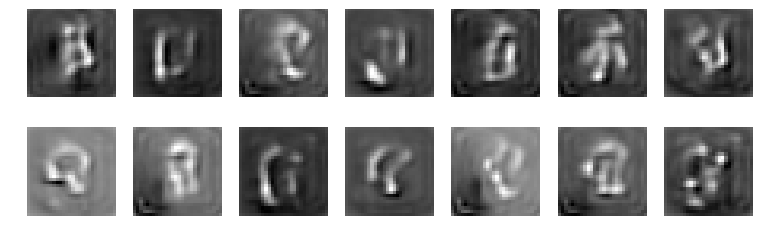

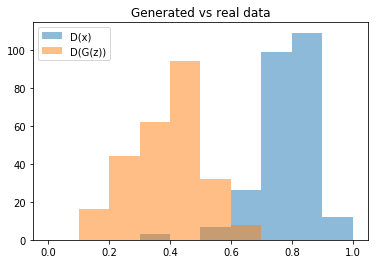

Time for epoch 742 is 54.69926014915109 min
error D: 0.7683287262916565, error G: -0.2251560539007187
Time for epoch 743 is 54.766252014786005 min
error D: 0.7840773463249207, error G: -0.5616753101348877
Time for epoch 744 is 54.83172285184264 min
error D: 0.7254699468612671, error G: -0.2377818077802658
Time for epoch 745 is 54.89948961511254 min
error D: 0.8108868598937988, error G: -0.5898438692092896
Time for epoch 746 is 54.96760148182511 min
error D: 0.7528943419456482, error G: -0.23871161043643951
Time for epoch 747 is 55.03842021524906 min
error D: 0.833367109298706, error G: -0.603538990020752
Time for epoch 748 is 55.108894765377045 min
error D: 0.8252344131469727, error G: -0.23004645109176636
Time for epoch 749 is 55.176389548927546 min
error D: 0.9562055468559265, error G: -0.7387894988059998
Time for epoch 750 is 55.242312517017126 min
error D: 0.8283870816230774, error G: -0.23636704683303833
Time for epoch 751 is 55.26193764805794 min
error D: 0.9362773299217224, erro

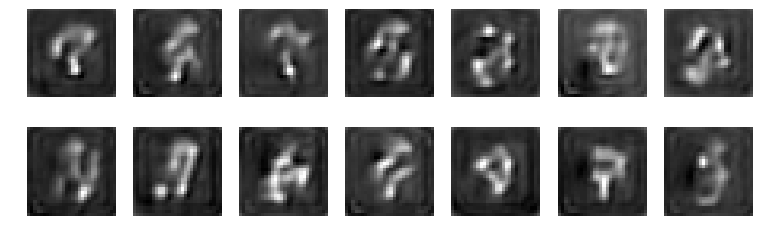

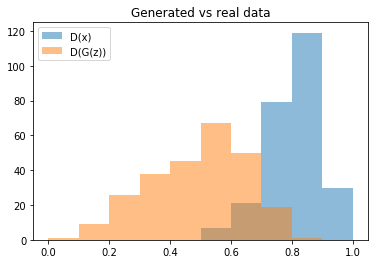

Time for epoch 752 is 55.35387321934104 min
error D: 0.9214925765991211, error G: -0.2272101640701294
Time for epoch 753 is 55.418080396950245 min
error D: 1.0660817623138428, error G: -0.8269147872924805
Time for epoch 754 is 55.484382163733244 min
error D: 1.0307773351669312, error G: -0.2421109974384308
Time for epoch 755 is 55.55006504803896 min
error D: 1.0663840770721436, error G: -0.8165737390518188
Time for epoch 756 is 55.61404171586037 min
error D: 1.0609381198883057, error G: -0.24427129328250885
Time for epoch 757 is 55.68263864889741 min
error D: 1.2426578998565674, error G: -1.0228766202926636
Time for epoch 758 is 55.74878130108118 min
error D: 1.1706682443618774, error G: -0.27721303701400757
Time for epoch 759 is 55.81466446444392 min
error D: 1.2915836572647095, error G: -1.0574500560760498
Time for epoch 760 is 55.8791179805994 min
error D: 1.1886398792266846, error G: -0.2931833267211914
Time for epoch 761 is 55.943601831793785 min
error D: 1.3038318157196045, error

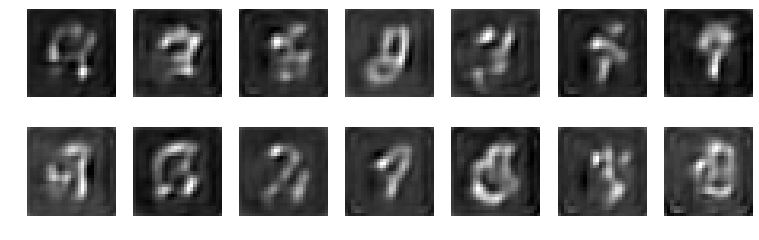

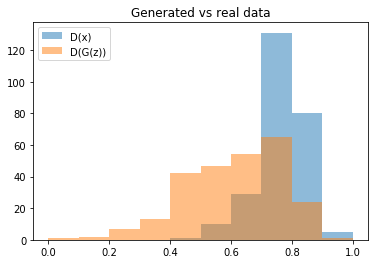

Time for epoch 762 is 56.03365183249116 min
error D: 1.2897686958312988, error G: -0.27601194381713867
Time for epoch 763 is 56.097395315766335 min
error D: 1.35222589969635, error G: -1.0649625062942505
Time for epoch 764 is 56.16295516490936 min
error D: 1.23763108253479, error G: -0.2948562502861023
Time for epoch 765 is 56.22808188199997 min
error D: 1.3395311832427979, error G: -1.0220855474472046
Time for epoch 766 is 56.291741482913494 min
error D: 1.2848042249679565, error G: -0.29569774866104126
Time for epoch 767 is 56.35701063275337 min
error D: 1.4035438299179077, error G: -1.082781434059143
Time for epoch 768 is 56.421175844967365 min
error D: 1.2595757246017456, error G: -0.2874913513660431
Time for epoch 769 is 56.486378498375416 min
error D: 1.369940996170044, error G: -1.0644837617874146
Time for epoch 770 is 56.55077376589179 min
error D: 1.2596831321716309, error G: -0.2670632004737854
Time for epoch 771 is 56.61471305042505 min
error D: 1.3483067750930786, error G: 

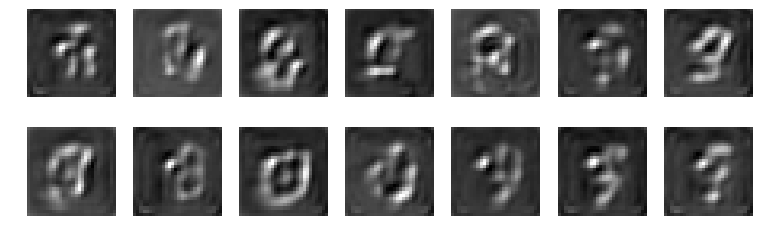

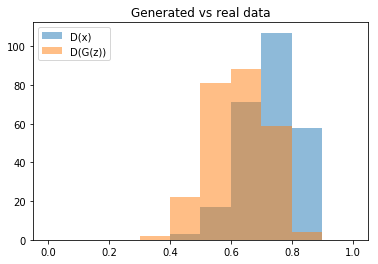

Time for epoch 772 is 56.704678531736135 min
error D: 1.159305214881897, error G: -0.27111324667930603
Time for epoch 773 is 56.769048411399126 min
error D: 1.2885526418685913, error G: -0.9809973239898682
Time for epoch 774 is 56.836946066468954 min
error D: 1.1624985933303833, error G: -0.2380874752998352
Time for epoch 775 is 56.91194101050496 min
error D: 1.164512038230896, error G: -0.8429458737373352
Time for epoch 776 is 57.00497358292341 min
error D: 1.0885024070739746, error G: -0.23086634278297424
Time for epoch 777 is 57.085864797234535 min
error D: 1.101312518119812, error G: -0.7922362089157104
Time for epoch 778 is 57.17233772948384 min
error D: 0.9941095113754272, error G: -0.2295355349779129
Time for epoch 779 is 57.26524819433689 min
error D: 0.9932496547698975, error G: -0.6895459890365601
Time for epoch 780 is 57.3578638471663 min
error D: 0.933347761631012, error G: -0.23723696172237396
Time for epoch 781 is 57.434357319027185 min
error D: 0.9311187863349915, error 

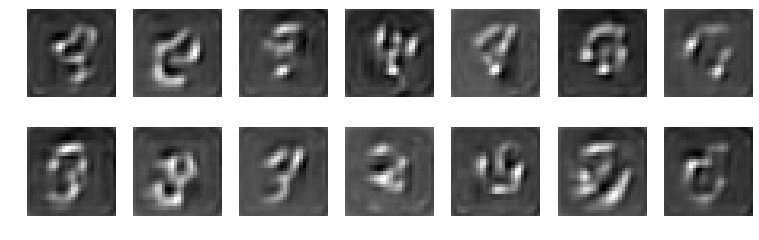

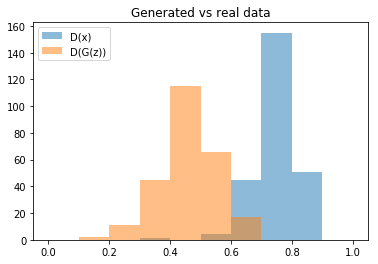

Time for epoch 782 is 57.54120871797204 min
error D: 0.8917454481124878, error G: -0.22695273160934448
Time for epoch 783 is 57.6141058281064 min
error D: 0.8763043284416199, error G: -0.5840350985527039
Time for epoch 784 is 57.68489786610007 min
error D: 0.8346378803253174, error G: -0.2712944746017456
Time for epoch 785 is 57.75406729802489 min
error D: 0.7956019043922424, error G: -0.49240681529045105
Time for epoch 786 is 57.8244715295732 min
error D: 0.8173742294311523, error G: -0.3072470426559448
Time for epoch 787 is 57.89355478435755 min
error D: 0.8589575886726379, error G: -0.5568970441818237
Time for epoch 788 is 57.960893485695124 min
error D: 0.8145188093185425, error G: -0.31719478964805603
Time for epoch 789 is 58.026990082114935 min
error D: 0.856197714805603, error G: -0.5578166842460632
Time for epoch 790 is 58.095214381814 min
error D: 0.8131363391876221, error G: -0.33723580837249756
Time for epoch 791 is 58.172976065427065 min
error D: 0.8197650909423828, error G

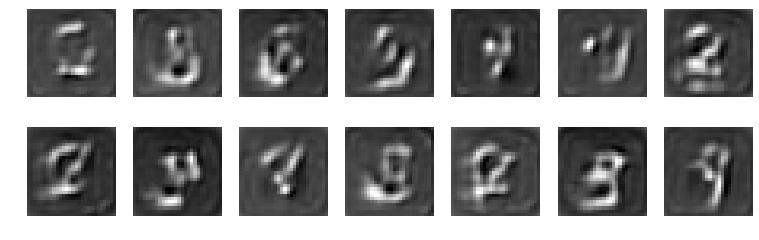

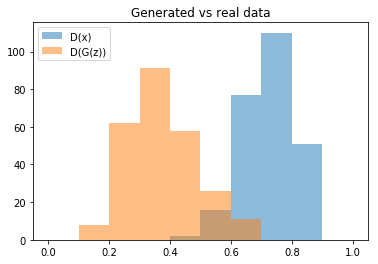

Time for epoch 792 is 58.27975535020232 min
error D: 0.8436552286148071, error G: -0.3729897141456604
Time for epoch 793 is 58.34846253320575 min
error D: 0.8391045928001404, error G: -0.5455163717269897
Time for epoch 794 is 58.413125302642584 min
error D: 0.8130267262458801, error G: -0.3714243769645691
Time for epoch 795 is 58.479894798249006 min
error D: 0.816641092300415, error G: -0.49566906690597534
Time for epoch 796 is 58.54763597995043 min
error D: 0.8155649900436401, error G: -0.4093379080295563
Time for epoch 797 is 58.61424406990409 min
error D: 0.8544177412986755, error G: -0.5235558152198792
Time for epoch 798 is 58.680828750133514 min
error D: 0.8521782159805298, error G: -0.39208608865737915
Time for epoch 799 is 58.74529388546944 min
error D: 0.8491531014442444, error G: -0.5410907864570618
Time for epoch 800 is 58.81116149947047 min
error D: 0.8782477974891663, error G: -0.389051616191864
Time for epoch 801 is 58.878200229257345 min
error D: 0.8952784538269043, error

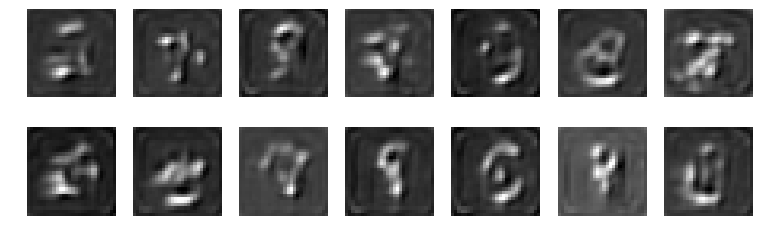

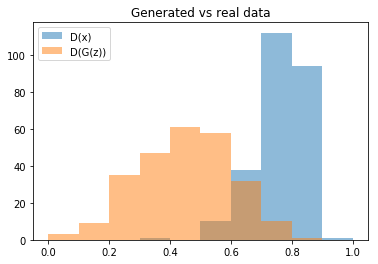

Time for epoch 802 is 58.97313589602709 min
error D: 0.9617592692375183, error G: -0.38968396186828613
Time for epoch 803 is 59.045670330524445 min
error D: 0.9964506030082703, error G: -0.7101240158081055
Time for epoch 804 is 59.11048184707761 min
error D: 1.0298670530319214, error G: -0.36042511463165283
Time for epoch 805 is 59.18977651745081 min
error D: 1.1426712274551392, error G: -0.9011377096176147
Time for epoch 806 is 59.25555518269539 min
error D: 1.1024973392486572, error G: -0.31002455949783325
Time for epoch 807 is 59.32478133589029 min
error D: 1.3386471271514893, error G: -1.1296799182891846
Time for epoch 808 is 59.39031556993723 min
error D: 1.2425096035003662, error G: -0.27708154916763306
Time for epoch 809 is 59.45444559678435 min
error D: 1.3365978002548218, error G: -1.0879251956939697
Time for epoch 810 is 59.51982279494405 min
error D: 1.1503499746322632, error G: -0.2718338072299957
Time for epoch 811 is 59.58442169800401 min
error D: 1.324771761894226, error

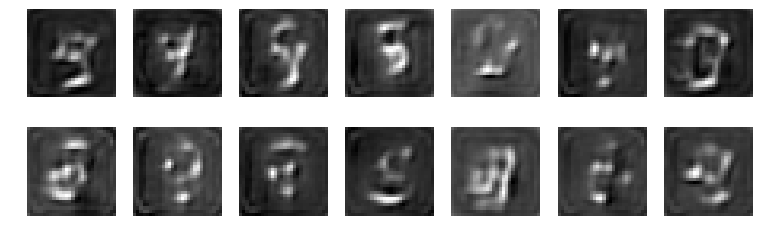

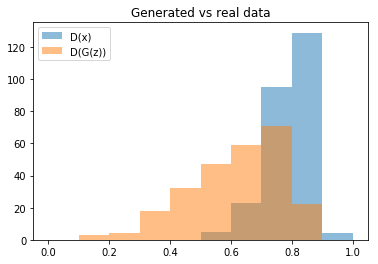

Time for epoch 812 is 59.67769808322191 min
error D: 1.1124917268753052, error G: -0.2524740695953369
Time for epoch 813 is 59.74245074763894 min
error D: 1.2053989171981812, error G: -0.9272474646568298
Time for epoch 814 is 59.80870869755745 min
error D: 1.0647567510604858, error G: -0.24964764714241028
Time for epoch 815 is 59.87521631643176 min
error D: 1.2238600254058838, error G: -0.9396450519561768
Time for epoch 816 is 59.94040162861347 min
error D: 1.135677695274353, error G: -0.26269713044166565
Time for epoch 817 is 60.01042668521404 min
error D: 1.2477620840072632, error G: -0.9384510517120361
Time for epoch 818 is 60.07653573155403 min
error D: 1.2138826847076416, error G: -0.28643691539764404
Time for epoch 819 is 60.1418593339622 min
error D: 1.3605843782424927, error G: -1.0027408599853516
Time for epoch 820 is 60.20838371664286 min
error D: 1.2385776042938232, error G: -0.342492938041687
Time for epoch 821 is 60.27643904834986 min
error D: 1.3826099634170532, error G: 

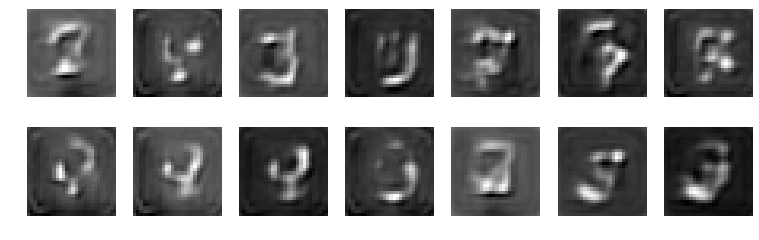

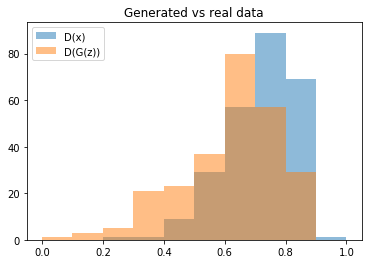

Time for epoch 822 is 60.39016482979059 min
error D: 1.278640866279602, error G: -0.36531487107276917
Time for epoch 823 is 60.50691448524594 min
error D: 1.2872639894485474, error G: -0.9217109680175781
Time for epoch 824 is 60.584795501083136 min
error D: 1.15680730342865, error G: -0.36608046293258667
Time for epoch 825 is 60.648911099880934 min
error D: 1.0623904466629028, error G: -0.6783174276351929
Time for epoch 826 is 60.71410411596298 min
error D: 0.9609783291816711, error G: -0.3391290605068207
Time for epoch 827 is 60.777406346052885 min
error D: 0.8588356375694275, error G: -0.5176615118980408
Time for epoch 828 is 60.842615749686956 min
error D: 0.7600645422935486, error G: -0.3376847505569458
Time for epoch 829 is 60.90671903267503 min
error D: 0.7498674392700195, error G: -0.37211287021636963
Time for epoch 830 is 60.97048118337989 min
error D: 0.6946149468421936, error G: -0.3198399543762207
Time for epoch 831 is 61.034890949726105 min
error D: 0.6914458870887756, erro

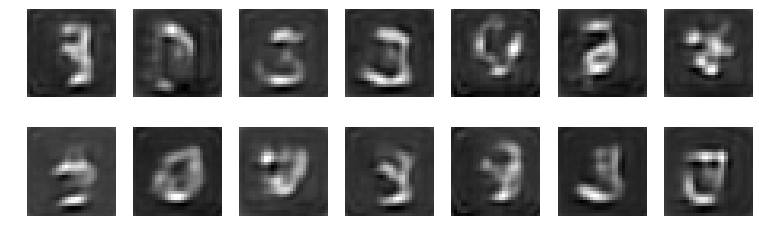

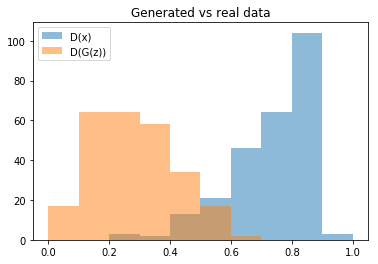

Time for epoch 832 is 61.13270181417465 min
error D: 0.6933009028434753, error G: -0.35134896636009216
Time for epoch 833 is 61.205114498734474 min
error D: 0.7306233048439026, error G: -0.3385828733444214
Time for epoch 834 is 61.27336196601391 min
error D: 0.7714263200759888, error G: -0.37557661533355713
Time for epoch 835 is 61.33811918273568 min
error D: 0.8019087314605713, error G: -0.3668096661567688
Time for epoch 836 is 61.40398346632719 min
error D: 0.8268753886222839, error G: -0.4041045606136322
Time for epoch 837 is 61.468985464423895 min
error D: 0.8595591187477112, error G: -0.3733462393283844
Time for epoch 838 is 61.53380089998245 min
error D: 0.936180830001831, error G: -0.5773703455924988
Time for epoch 839 is 61.59769778326154 min
error D: 0.9887251257896423, error G: -0.23568566143512726
Time for epoch 840 is 61.66407149657607 min
error D: 1.1270713806152344, error G: -0.8177887201309204
Time for epoch 841 is 61.728589065372944 min
error D: 1.0009715557098389, erro

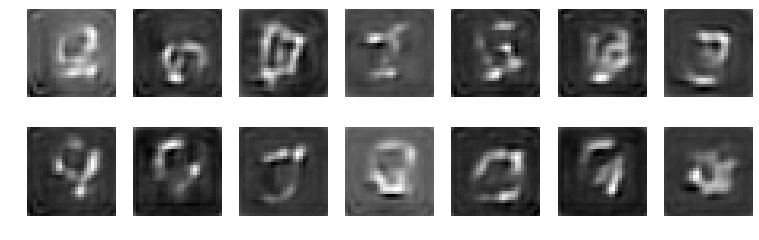

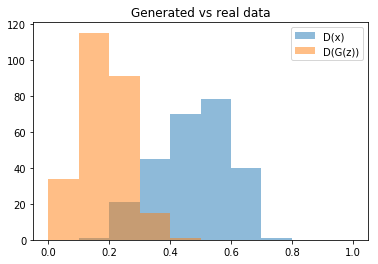

Time for epoch 842 is 61.822503097355366 min
error D: 1.0914227962493896, error G: -0.8296313285827637
Time for epoch 843 is 61.88579012826085 min
error D: 0.9984574317932129, error G: -0.16789944469928741
Time for epoch 844 is 61.94986421242356 min
error D: 0.9214916229248047, error G: -0.6045461297035217
Time for epoch 845 is 62.01461386680603 min
error D: 0.8915008306503296, error G: -0.1762036383152008
Time for epoch 846 is 62.08062111586332 min
error D: 0.8649973273277283, error G: -0.597199559211731
Time for epoch 847 is 62.150461446493864 min
error D: 0.7647839784622192, error G: -0.18307653069496155
Time for epoch 848 is 62.237762328237295 min
error D: 0.8760920763015747, error G: -0.6304798126220703
Time for epoch 849 is 62.309750236570835 min
error D: 0.757238507270813, error G: -0.1981198787689209
Time for epoch 850 is 62.38695641979575 min
error D: 0.8568825721740723, error G: -0.6031049489974976
Time for epoch 851 is 62.46771889925003 min
error D: 0.7938809394836426, error

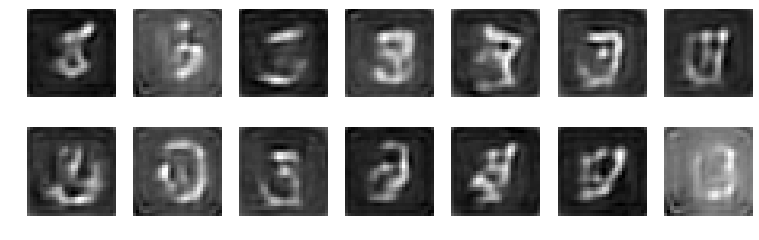

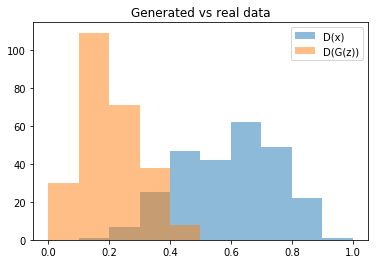

Time for epoch 852 is 62.56975461542606 min
error D: 0.8266428112983704, error G: -0.5397803783416748
Time for epoch 853 is 62.63500778377056 min
error D: 0.8886783719062805, error G: -0.26448318362236023
Time for epoch 854 is 62.70138546451926 min
error D: 0.9704530835151672, error G: -0.7105398178100586
Time for epoch 855 is 62.776516165584326 min
error D: 0.9303569793701172, error G: -0.33421021699905396
Time for epoch 856 is 62.86590661481023 min
error D: 1.1154597997665405, error G: -0.8423722982406616
Time for epoch 857 is 62.932819332927465 min
error D: 1.065659999847412, error G: -0.4073460102081299
Time for epoch 858 is 63.000722363591194 min
error D: 1.2020567655563354, error G: -0.9162150621414185
Time for epoch 859 is 63.076496332883835 min
error D: 1.1766319274902344, error G: -0.47511807084083557
Time for epoch 860 is 63.145533729344606 min
error D: 1.1658300161361694, error G: -0.8492252826690674
Time for epoch 861 is 63.210736114531755 min
error D: 1.1808652877807617, e

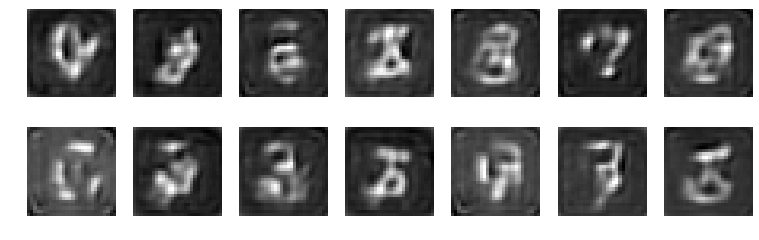

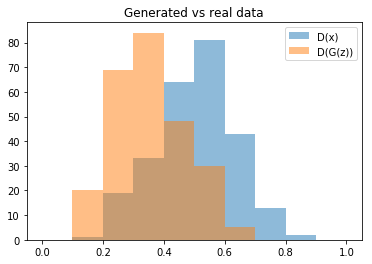

Time for epoch 862 is 63.301326513290405 min
error D: 1.106964349746704, error G: -0.7589082717895508
Time for epoch 863 is 63.365056082606316 min
error D: 1.001790165901184, error G: -0.4494900703430176
Time for epoch 864 is 63.429064348340034 min
error D: 0.924206554889679, error G: -0.6109384298324585
Time for epoch 865 is 63.49510256573558 min
error D: 0.8531236052513123, error G: -0.4165271520614624
Time for epoch 866 is 63.55977816134691 min
error D: 0.8017210960388184, error G: -0.4797263741493225
Time for epoch 867 is 63.62359369546175 min
error D: 0.7683355212211609, error G: -0.38103896379470825
Time for epoch 868 is 63.69232773035765 min
error D: 0.7220993638038635, error G: -0.4081365466117859
Time for epoch 869 is 63.755798164755106 min
error D: 0.6792123317718506, error G: -0.36758917570114136
Time for epoch 870 is 63.81985101848841 min
error D: 0.7604925036430359, error G: -0.4120062589645386
Time for epoch 871 is 63.88416323065758 min
error D: 0.7305179238319397, error 

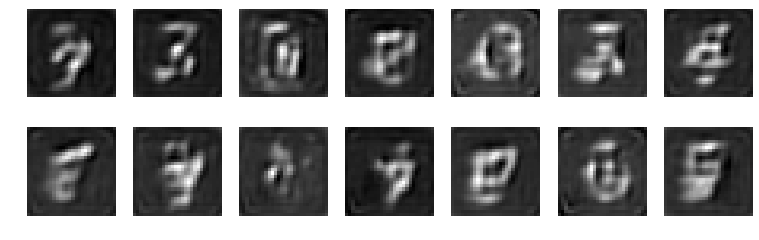

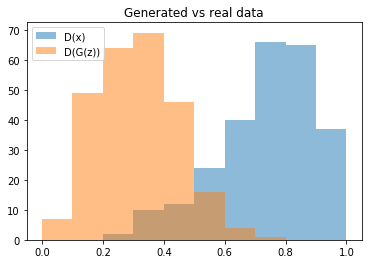

Time for epoch 872 is 63.97237776592374 min
error D: 0.7696447968482971, error G: -0.4237436056137085
Time for epoch 873 is 64.04340791329741 min
error D: 0.8587329983711243, error G: -0.50909024477005
Time for epoch 874 is 64.12631296366453 min
error D: 0.8831190466880798, error G: -0.36075830459594727
Time for epoch 875 is 64.22094640135765 min
error D: 1.1063883304595947, error G: -0.8394824862480164
Time for epoch 876 is 64.30211064964533 min
error D: 1.140621304512024, error G: -0.28086230158805847
Time for epoch 877 is 64.37657823041081 min
error D: 1.714198112487793, error G: -1.5220587253570557
Time for epoch 878 is 64.44161365181208 min
error D: 1.4896031618118286, error G: -0.224864199757576
Time for epoch 879 is 64.51234827935696 min
error D: 1.8484091758728027, error G: -1.6447913646697998
Time for epoch 880 is 64.58601626753807 min
error D: 1.4928624629974365, error G: -0.18588711321353912
Time for epoch 881 is 64.67854123190045 min
error D: 1.4788098335266113, error G: -1

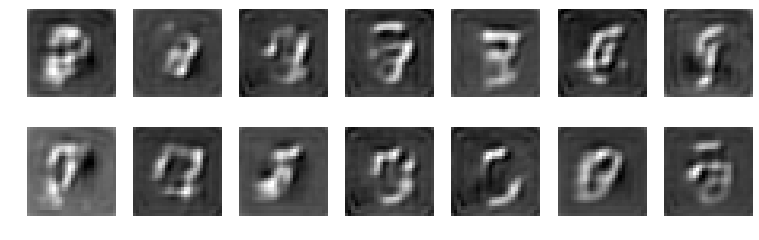

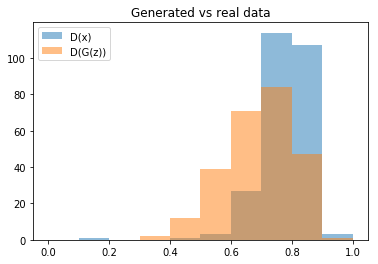

Time for epoch 882 is 64.80430183559656 min
error D: 1.175578236579895, error G: -0.1409764140844345
Time for epoch 883 is 64.90638450160623 min
error D: 1.0607727766036987, error G: -0.8201664090156555
Time for epoch 884 is 64.99552214890718 min
error D: 0.7662928700447083, error G: -0.17548437416553497
Time for epoch 885 is 65.06226707994938 min
error D: 0.6449348330497742, error G: -0.3459726870059967
Time for epoch 886 is 65.12805831804872 min
error D: 0.581205427646637, error G: -0.1790395975112915
Time for epoch 887 is 65.192199498415 min
error D: 0.5326840877532959, error G: -0.2706623673439026
Time for epoch 888 is 65.25636356696486 min
error D: 0.5096534490585327, error G: -0.19280798733234406
Time for epoch 889 is 65.32260252907872 min
error D: 0.5011138916015625, error G: -0.23264539241790771
Time for epoch 890 is 65.38858277723193 min
error D: 0.5208443999290466, error G: -0.21421250700950623
Time for epoch 891 is 65.45487884804606 min
error D: 0.5234360694885254, error G: 

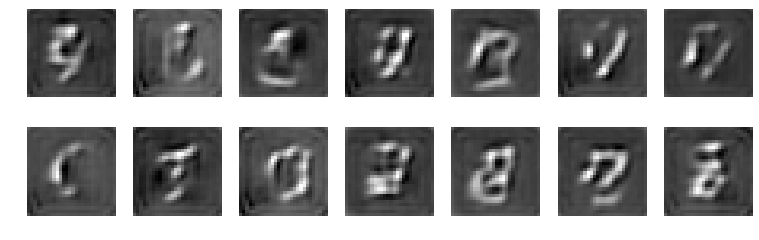

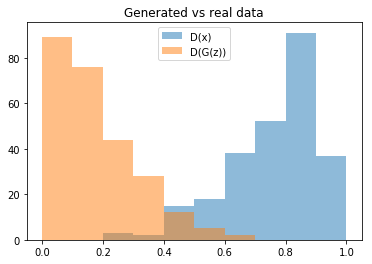

Time for epoch 892 is 65.54915436729789 min
error D: 0.5125293135643005, error G: -0.23143130540847778
Time for epoch 893 is 65.61313679814339 min
error D: 0.5459370017051697, error G: -0.26956117153167725
Time for epoch 894 is 65.68262720108032 min
error D: 0.6169515252113342, error G: -0.2703845798969269
Time for epoch 895 is 65.7476348169148 min
error D: 0.6620907187461853, error G: -0.36424899101257324
Time for epoch 896 is 65.81190538406372 min
error D: 0.6739982962608337, error G: -0.2943708300590515
Time for epoch 897 is 65.8758365996182 min
error D: 0.7555741667747498, error G: -0.45188596844673157
Time for epoch 898 is 65.94121554866433 min
error D: 0.905537486076355, error G: -0.285305380821228
Time for epoch 899 is 66.00612611323595 min
error D: 0.9930070042610168, error G: -0.6969029307365417
Time for epoch 900 is 66.08724679425359 min
error D: 1.0241236686706543, error G: -0.3539092540740967
Time for epoch 901 is 66.16311264783144 min
error D: 1.2023985385894775, error G: 

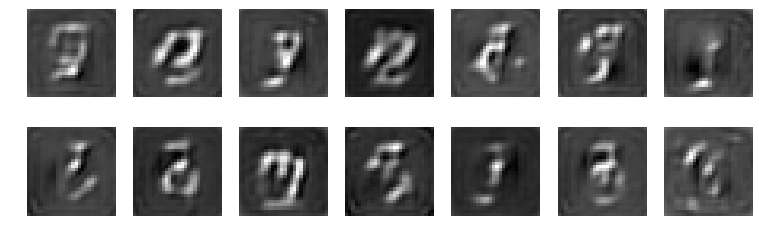

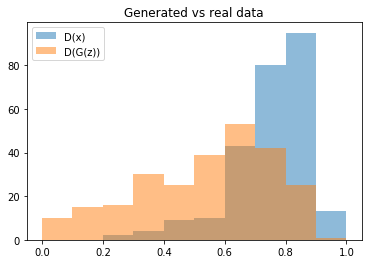

Time for epoch 902 is 66.26539388298988 min
error D: 1.078189730644226, error G: -0.3900375962257385
Time for epoch 903 is 66.33143888413906 min
error D: 1.1575767993927002, error G: -0.8223047852516174
Time for epoch 904 is 66.40623766556382 min
error D: 1.060753345489502, error G: -0.37671172618865967
Time for epoch 905 is 66.47328683361411 min
error D: 0.9574242234230042, error G: -0.6262353658676147
Time for epoch 906 is 66.53838957846165 min
error D: 0.8910900950431824, error G: -0.3637085258960724
Time for epoch 907 is 66.60205466300249 min
error D: 0.8569598197937012, error G: -0.5189961194992065
Time for epoch 908 is 66.66726700216532 min
error D: 0.7703489661216736, error G: -0.38852280378341675
Time for epoch 909 is 66.7306179702282 min
error D: 0.7392221689224243, error G: -0.3890454173088074
Time for epoch 910 is 66.79440098255873 min
error D: 0.7132483720779419, error G: -0.38689810037612915
Time for epoch 911 is 66.85879021510482 min
error D: 0.7652461528778076, error G: 

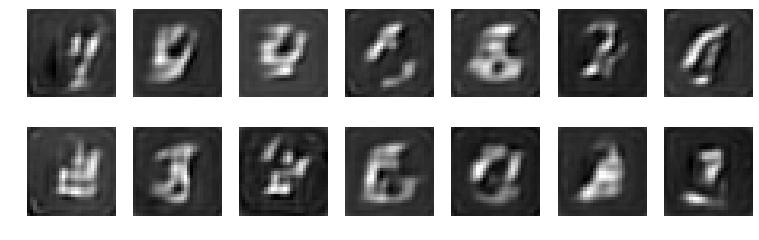

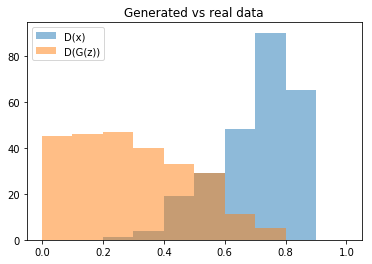

Time for epoch 912 is 66.94721868261695 min
error D: 0.736160397529602, error G: -0.41831764578819275
Time for epoch 913 is 67.01183520257473 min
error D: 0.7177569270133972, error G: -0.38986068964004517
Time for epoch 914 is 67.07657473161817 min
error D: 0.7685357928276062, error G: -0.4204142987728119
Time for epoch 915 is 67.14485054835677 min
error D: 0.8349342942237854, error G: -0.4153681993484497
Time for epoch 916 is 67.2096702978015 min
error D: 0.9077837467193604, error G: -0.4941807687282562
Time for epoch 917 is 67.27274366095662 min
error D: 0.8800680041313171, error G: -0.4989427626132965
Time for epoch 918 is 67.34220476448536 min
error D: 0.9457772970199585, error G: -0.4178709387779236
Time for epoch 919 is 67.41134389862418 min
error D: 1.1064529418945312, error G: -0.8237386345863342
Time for epoch 920 is 67.47884613275528 min
error D: 1.141664981842041, error G: -0.3215845227241516
Time for epoch 921 is 67.54543036594987 min
error D: 1.3748016357421875, error G: -

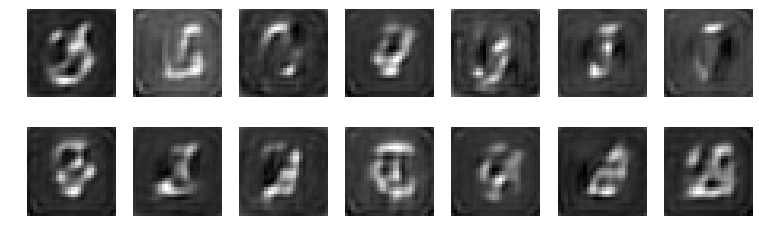

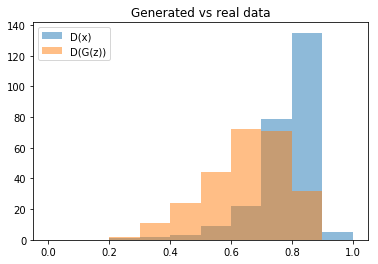

Time for epoch 922 is 67.63545581698418 min
error D: 1.2538871765136719, error G: -0.27897965908050537
Time for epoch 923 is 67.7026767320931 min
error D: 1.4416871070861816, error G: -1.1799640655517578
Time for epoch 924 is 67.7686054483056 min
error D: 1.3045448064804077, error G: -0.2516382932662964
Time for epoch 925 is 67.8399254642427 min
error D: 1.2939302921295166, error G: -0.9997599720954895
Time for epoch 926 is 67.90751570090652 min
error D: 1.2101653814315796, error G: -0.22479723393917084
Time for epoch 927 is 67.97196001186967 min
error D: 1.1650553941726685, error G: -0.8864518404006958
Time for epoch 928 is 68.03592278063297 min
error D: 1.0788706541061401, error G: -0.21496295928955078
Time for epoch 929 is 68.10214243084192 min
error D: 1.00907301902771, error G: -0.7198220491409302
Time for epoch 930 is 68.16865469887853 min
error D: 0.9777274131774902, error G: -0.1992042362689972
Time for epoch 931 is 68.23402369767427 min
error D: 0.9148737788200378, error G: -0

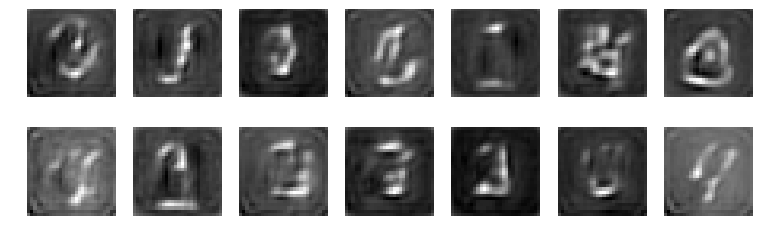

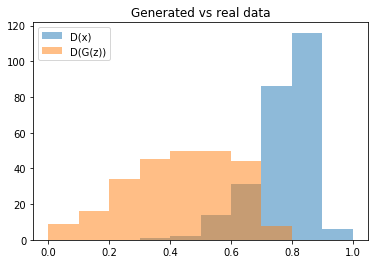

Time for epoch 932 is 68.32565528154373 min
error D: 0.8328979015350342, error G: -0.23518487811088562
Time for epoch 933 is 68.3905676342547 min
error D: 0.9144256711006165, error G: -0.6673650145530701
Time for epoch 934 is 68.45498113334179 min
error D: 0.842486560344696, error G: -0.2558082044124603
Time for epoch 935 is 68.52005361393094 min
error D: 0.8898857831954956, error G: -0.626381516456604
Time for epoch 936 is 68.58718196675181 min
error D: 0.9057995676994324, error G: -0.27249884605407715
Time for epoch 937 is 68.65361363068223 min
error D: 0.9885938763618469, error G: -0.731623649597168
Time for epoch 938 is 68.72016438469291 min
error D: 0.9748927354812622, error G: -0.2873568534851074
Time for epoch 939 is 68.78435382992029 min
error D: 1.0205153226852417, error G: -0.7263811826705933
Time for epoch 940 is 68.84837988391519 min
error D: 1.1069364547729492, error G: -0.32032275199890137
Time for epoch 941 is 68.91300899907947 min
error D: 1.1589967012405396, error G: -

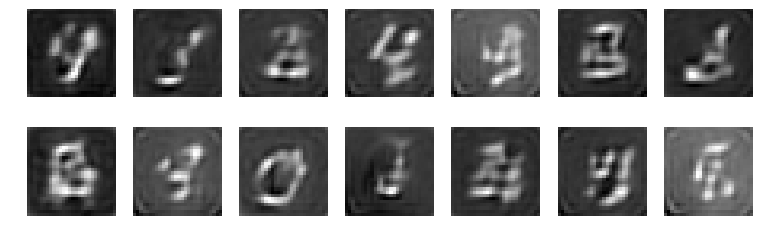

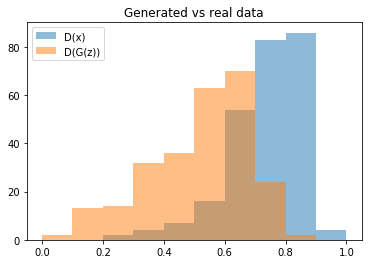

Time for epoch 942 is 69.01465282961726 min
error D: 1.1226292848587036, error G: -0.3312084972858429
Time for epoch 943 is 69.08846481516957 min
error D: 1.223952054977417, error G: -0.9631175994873047
Time for epoch 944 is 69.15358904749155 min
error D: 1.083481788635254, error G: -0.3356426954269409
Time for epoch 945 is 69.22221463173628 min
error D: 1.1965810060501099, error G: -0.9149513244628906
Time for epoch 946 is 69.2933645658195 min
error D: 1.0427547693252563, error G: -0.30694442987442017
Time for epoch 947 is 69.36604558303952 min
error D: 0.9929491281509399, error G: -0.6739491820335388
Time for epoch 948 is 69.43268997967243 min
error D: 0.9617574214935303, error G: -0.31017637252807617
Time for epoch 949 is 69.49881289899349 min
error D: 0.8961626291275024, error G: -0.5945557951927185
Time for epoch 950 is 69.5654941983521 min
error D: 0.8552523851394653, error G: -0.3089762330055237
Time for epoch 951 is 69.63278211280704 min
error D: 0.867191731929779, error G: -0.

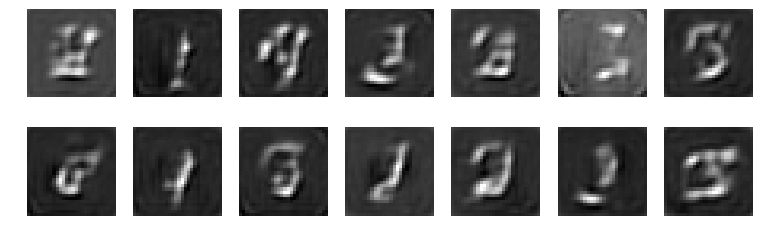

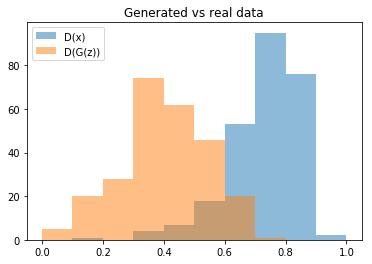

Time for epoch 952 is 69.728689417243 min
error D: 0.8961973786354065, error G: -0.3123420476913452
Time for epoch 953 is 69.79421639814973 min
error D: 0.9249705672264099, error G: -0.6157308220863342
Time for epoch 954 is 69.86088236048818 min
error D: 0.906056821346283, error G: -0.3181579113006592
Time for epoch 955 is 69.9265252314508 min
error D: 1.019902229309082, error G: -0.7093339562416077
Time for epoch 956 is 69.99169275164604 min
error D: 0.9881457090377808, error G: -0.3142523765563965
Time for epoch 957 is 70.05907368287444 min
error D: 1.0902657508850098, error G: -0.7553863525390625
Time for epoch 958 is 70.12415312975645 min
error D: 1.0489140748977661, error G: -0.30921924114227295
Time for epoch 959 is 70.18897994980216 min
error D: 1.1692895889282227, error G: -0.8139075040817261
Time for epoch 960 is 70.25421392917633 min
error D: 1.121556043624878, error G: -0.28655821084976196
Time for epoch 961 is 70.31923465058208 min
error D: 1.3153244256973267, error G: -0.9

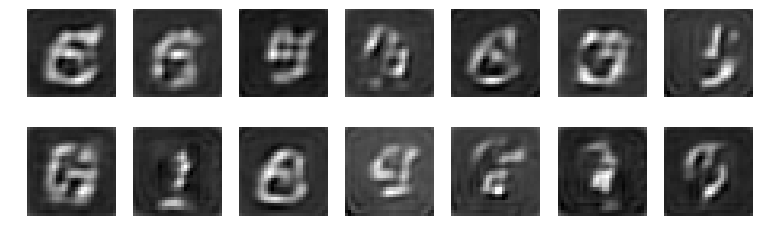

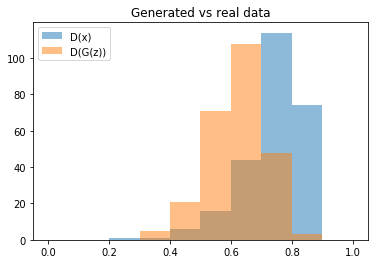

Time for epoch 962 is 70.40824944525957 min
error D: 1.141444206237793, error G: -0.25244760513305664
Time for epoch 963 is 70.473457749933 min
error D: 1.2487598657608032, error G: -0.9297775626182556
Time for epoch 964 is 70.53806606680155 min
error D: 1.1767351627349854, error G: -0.22430753707885742
Time for epoch 965 is 70.60246083140373 min
error D: 1.3087174892425537, error G: -1.0307635068893433
Time for epoch 966 is 70.67034429684281 min
error D: 1.1554410457611084, error G: -0.21082112193107605
Time for epoch 967 is 70.73799126595259 min
error D: 1.157289743423462, error G: -0.8630486726760864
Time for epoch 968 is 70.81186849623919 min
error D: 1.0477008819580078, error G: -0.23392140865325928
Time for epoch 969 is 70.88356968387961 min
error D: 1.132885217666626, error G: -0.8642314672470093
Time for epoch 970 is 70.95392034947872 min
error D: 1.0006415843963623, error G: -0.25190699100494385
Time for epoch 971 is 71.02135776355863 min
error D: 1.1875635385513306, error G: 

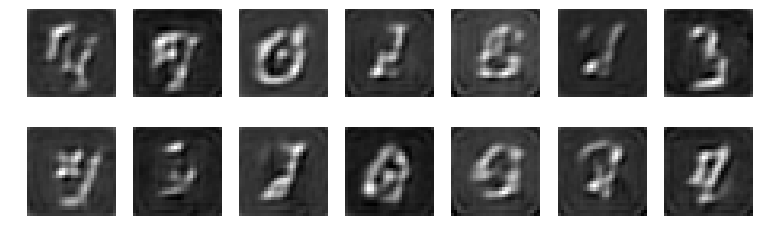

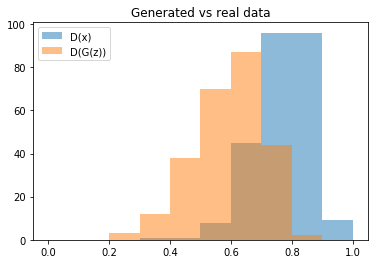

Time for epoch 972 is 71.11843169480562 min
error D: 1.0673800706863403, error G: -0.2751320004463196
Time for epoch 973 is 71.19163294509053 min
error D: 1.3484283685684204, error G: -1.095268726348877
Time for epoch 974 is 71.26443249732256 min
error D: 1.0740736722946167, error G: -0.3208012580871582
Time for epoch 975 is 71.33305368572474 min
error D: 1.1917481422424316, error G: -0.8711735010147095
Time for epoch 976 is 71.39909346401691 min
error D: 1.178942322731018, error G: -0.341427206993103
Time for epoch 977 is 71.4648725502193 min
error D: 1.2541269063949585, error G: -0.9343304634094238
Time for epoch 978 is 71.53094756603241 min
error D: 1.2108818292617798, error G: -0.36966848373413086
Time for epoch 979 is 71.59711566567421 min
error D: 1.2717424631118774, error G: -0.9492310285568237
Time for epoch 980 is 71.66711319610476 min
error D: 1.1453087329864502, error G: -0.38822317123413086
Time for epoch 981 is 71.73574401438236 min
error D: 1.1333996057510376, error G: -0

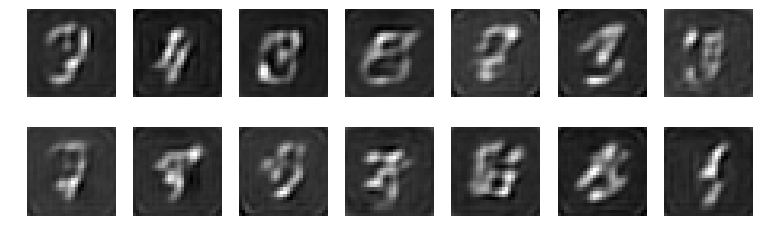

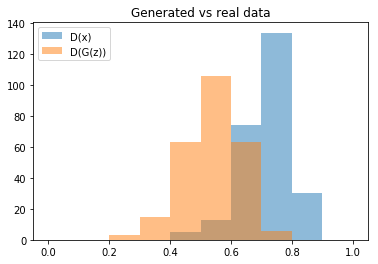

Time for epoch 982 is 71.83050547912717 min
error D: 1.0644603967666626, error G: -0.39740830659866333
Time for epoch 983 is 71.89560419693589 min
error D: 1.0206438302993774, error G: -0.6676769852638245
Time for epoch 984 is 71.96523096039891 min
error D: 0.9986273050308228, error G: -0.39855825901031494
Time for epoch 985 is 72.0324587970972 min
error D: 0.9351174831390381, error G: -0.5724521279335022
Time for epoch 986 is 72.09733086451888 min
error D: 0.9222123622894287, error G: -0.3954070806503296
Time for epoch 987 is 72.16381868720055 min
error D: 0.8988689184188843, error G: -0.5166381597518921
Time for epoch 988 is 72.22942984849215 min
error D: 0.9323113560676575, error G: -0.4024532735347748
Time for epoch 989 is 72.29491291567683 min
error D: 0.9448421001434326, error G: -0.6049085855484009
Time for epoch 990 is 72.36123664677143 min
error D: 0.9953364133834839, error G: -0.39584633708000183
Time for epoch 991 is 72.42551421374083 min
error D: 1.1252875328063965, error G

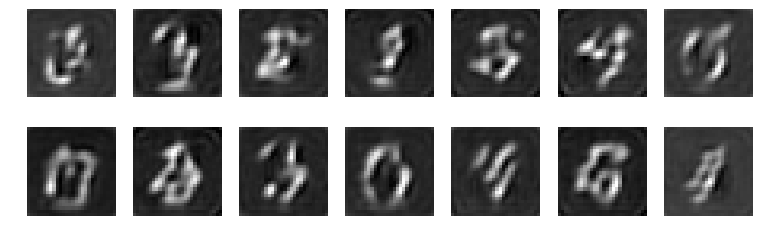

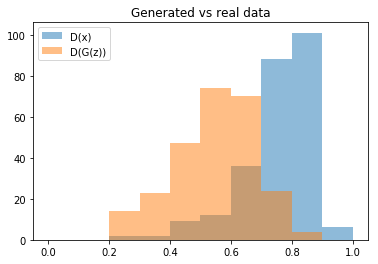

Time for epoch 992 is 72.51807748153806 min
error D: 1.0707601308822632, error G: -0.35610732436180115
Time for epoch 993 is 72.58494179695845 min
error D: 1.3206779956817627, error G: -1.0827207565307617
Time for epoch 994 is 72.6532304957509 min
error D: 1.1803498268127441, error G: -0.3117038905620575
Time for epoch 995 is 72.72020056471229 min
error D: 1.391801357269287, error G: -1.1276917457580566
Time for epoch 996 is 72.79382659867406 min
error D: 1.1826602220535278, error G: -0.30818110704421997
Time for epoch 997 is 72.88533764705062 min
error D: 1.2779792547225952, error G: -0.9645377397537231
Time for epoch 998 is 72.95474034547806 min
error D: 1.1903830766677856, error G: -0.24860873818397522
Time for epoch 999 is 73.0198759175837 min
error D: 1.2033573389053345, error G: -0.9102242588996887
Time for epoch 1000 is 73.08424085006118 min
error D: 1.0841988325119019, error G: -0.1943592131137848
Time for epoch 1001 is 73.14938032999635 min
error D: 1.0798306465148926, error G

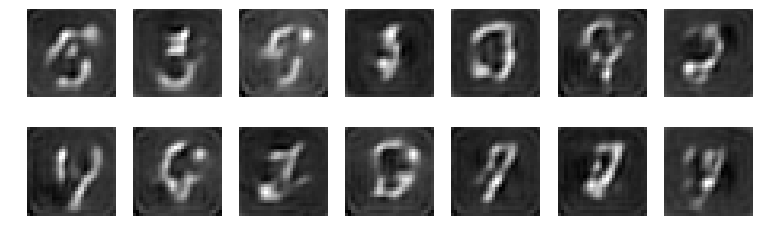

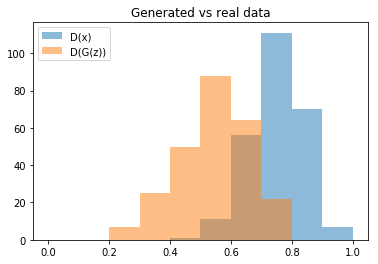

Time for epoch 1002 is 73.24341128394008 min
error D: 0.9908588528633118, error G: -0.19663865864276886
Time for epoch 1003 is 73.30723011493683 min
error D: 1.0107641220092773, error G: -0.7311439514160156
Time for epoch 1004 is 73.37194803357124 min
error D: 0.9285008907318115, error G: -0.23621973395347595
Time for epoch 1005 is 73.44068848341703 min
error D: 1.0664838552474976, error G: -0.7972681522369385
Time for epoch 1006 is 73.5073782838881 min
error D: 0.9243423342704773, error G: -0.2567954957485199
Time for epoch 1007 is 73.57317709550261 min
error D: 1.003321647644043, error G: -0.7114803791046143
Time for epoch 1008 is 73.64107759669423 min
error D: 1.0136871337890625, error G: -0.26464009284973145
Time for epoch 1009 is 73.71130916848779 min
error D: 1.1703476905822754, error G: -0.8790196180343628
Time for epoch 1010 is 73.77600083500147 min
error D: 1.1805270910263062, error G: -0.30796051025390625
Time for epoch 1011 is 73.8423301614821 min
error D: 1.2214155197143555

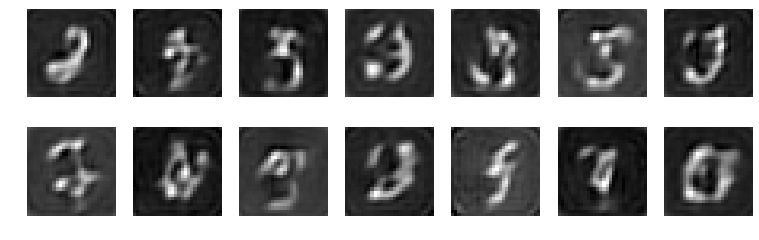

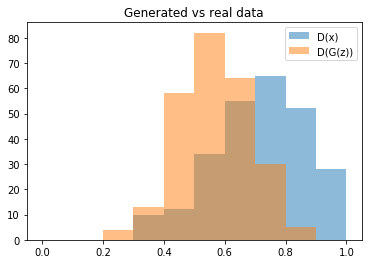

Time for epoch 1012 is 73.93463039770722 min
error D: 1.2034913301467896, error G: -0.38398313522338867
Time for epoch 1013 is 73.99788843095303 min
error D: 1.2934950590133667, error G: -0.962713360786438
Time for epoch 1014 is 74.06290859729052 min
error D: 1.2071609497070312, error G: -0.41015908122062683
Time for epoch 1015 is 74.12748631834984 min
error D: 1.2080844640731812, error G: -0.8975778818130493
Time for epoch 1016 is 74.19292026385665 min
error D: 1.1082947254180908, error G: -0.42052531242370605
Time for epoch 1017 is 74.2573724500835 min
error D: 1.0299736261367798, error G: -0.6927565336227417
Time for epoch 1018 is 74.32132929563522 min
error D: 0.9462020397186279, error G: -0.39017224311828613
Time for epoch 1019 is 74.38558946549892 min
error D: 0.8578713536262512, error G: -0.5162436962127686
Time for epoch 1020 is 74.45018419623375 min
error D: 0.8087886571884155, error G: -0.3757435381412506
Time for epoch 1021 is 74.51586610078812 min
error D: 0.794825673103332

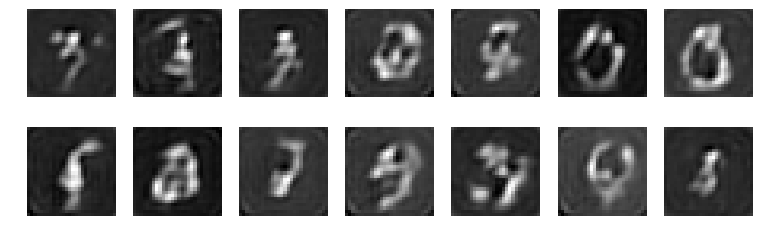

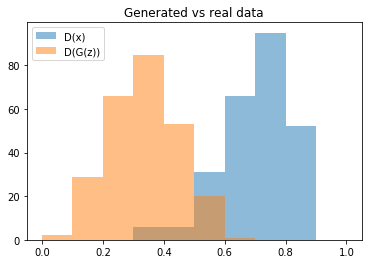

Time for epoch 1022 is 74.60520604997873 min
error D: 0.7762517929077148, error G: -0.43586334586143494
Time for epoch 1023 is 74.6706092171371 min
error D: 0.7786965370178223, error G: -0.37465593218803406
Time for epoch 1024 is 74.73529901728034 min
error D: 0.8045369386672974, error G: -0.42949944734573364
Time for epoch 1025 is 74.79945514723659 min
error D: 0.8264110684394836, error G: -0.41605454683303833
Time for epoch 1026 is 74.86361089721322 min
error D: 0.8494560718536377, error G: -0.454379677772522
Time for epoch 1027 is 74.92891204729676 min
error D: 0.9282663464546204, error G: -0.3700869083404541
Time for epoch 1028 is 74.99604219570756 min
error D: 1.159049391746521, error G: -0.8856855630874634
Time for epoch 1029 is 75.06086861714721 min
error D: 1.094495177268982, error G: -0.31310534477233887
Time for epoch 1030 is 75.12489686533809 min
error D: 1.2066316604614258, error G: -0.9020453095436096
Time for epoch 1031 is 75.18987445160747 min
error D: 1.199134111404419,

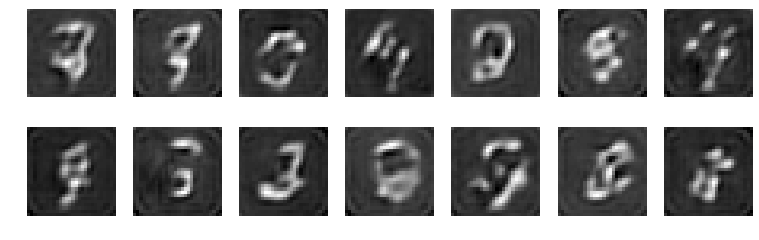

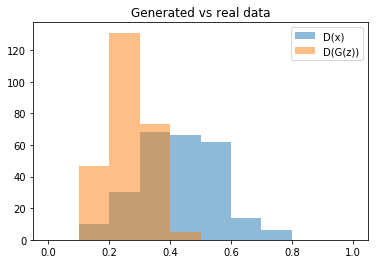

Time for epoch 1032 is 75.28170910105109 min
error D: 1.3433516025543213, error G: -1.032928228378296
Time for epoch 1033 is 75.34608831629157 min
error D: 1.242211103439331, error G: -0.2625272870063782
Time for epoch 1034 is 75.41115853562951 min
error D: 1.239045262336731, error G: -0.9398124814033508
Time for epoch 1035 is 75.47672909498215 min
error D: 1.1599154472351074, error G: -0.21589085459709167
Time for epoch 1036 is 75.54128504544497 min
error D: 1.2233487367630005, error G: -0.9729005098342896
Time for epoch 1037 is 75.60680326446891 min
error D: 1.0613138675689697, error G: -0.188301220536232
Time for epoch 1038 is 75.67517221346498 min
error D: 1.0297565460205078, error G: -0.7417320013046265
Time for epoch 1039 is 75.74053311347961 min
error D: 0.9976035952568054, error G: -0.17725282907485962
Time for epoch 1040 is 75.81584519520402 min
error D: 0.9232807159423828, error G: -0.6487475633621216
Time for epoch 1041 is 75.89314146339893 min
error D: 0.896128237247467, er

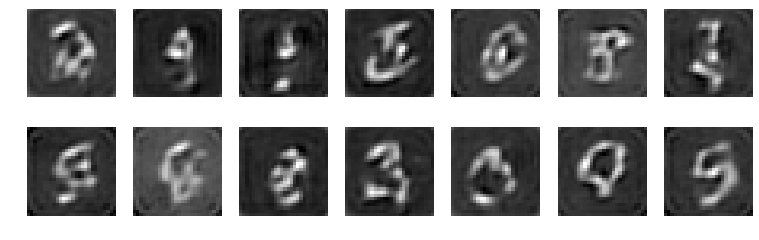

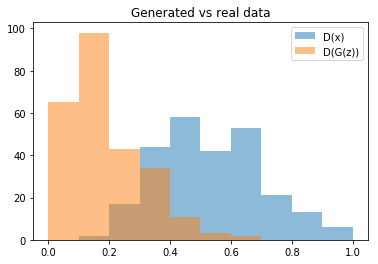

Time for epoch 1042 is 75.9997949488461 min
error D: 0.9411680698394775, error G: -0.6614137291908264
Time for epoch 1043 is 76.07015870139003 min
error D: 0.8286262154579163, error G: -0.2553393244743347
Time for epoch 1044 is 76.1372224278748 min
error D: 0.9381338357925415, error G: -0.6400008201599121
Time for epoch 1045 is 76.20197713002563 min
error D: 1.0421998500823975, error G: -0.26731613278388977
Time for epoch 1046 is 76.26994192972779 min
error D: 1.0967917442321777, error G: -0.7755801677703857
Time for epoch 1047 is 76.3347433283925 min
error D: 1.0493738651275635, error G: -0.32886868715286255
Time for epoch 1048 is 76.40020668134093 min
error D: 1.207833170890808, error G: -0.8859207034111023
Time for epoch 1049 is 76.4642666503787 min
error D: 1.24912428855896, error G: -0.3892759680747986
Time for epoch 1050 is 76.52807255089283 min
error D: 1.242226481437683, error G: -0.8544144034385681
Time for epoch 1051 is 76.59406176581979 min
error D: 1.2721174955368042, error

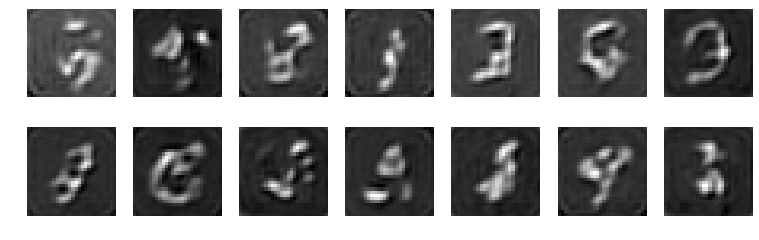

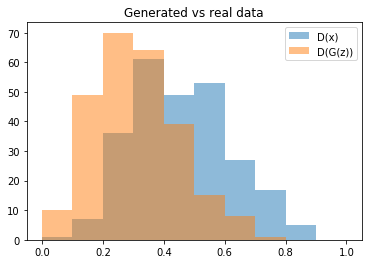

Time for epoch 1052 is 76.68723411485553 min
error D: 1.2869290113449097, error G: -0.9041182398796082
Time for epoch 1053 is 76.75060268118978 min
error D: 1.243467926979065, error G: -0.40810316801071167
Time for epoch 1054 is 76.81527179852128 min
error D: 1.1945607662200928, error G: -0.8836025595664978
Time for epoch 1055 is 76.88029835000634 min
error D: 1.0856568813323975, error G: -0.3918759822845459
Time for epoch 1056 is 76.94632454589009 min
error D: 0.978278398513794, error G: -0.6216354966163635
Time for epoch 1057 is 77.01012184843421 min
error D: 0.9198367595672607, error G: -0.3680918216705322
Time for epoch 1058 is 77.07634603232145 min
error D: 0.8623713850975037, error G: -0.523415207862854
Time for epoch 1059 is 77.1415703445673 min
error D: 0.8376012444496155, error G: -0.3588271737098694
Time for epoch 1060 is 77.20500791445374 min
error D: 0.8171526193618774, error G: -0.49835896492004395
Time for epoch 1061 is 77.26996296644211 min
error D: 0.8191237449645996, e

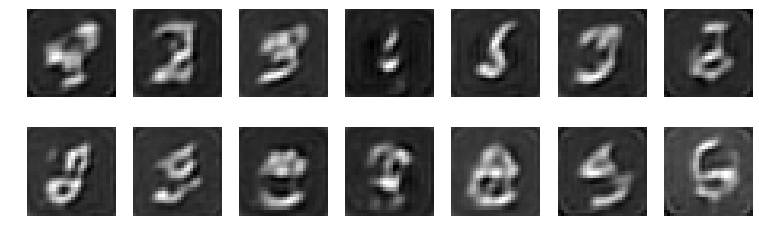

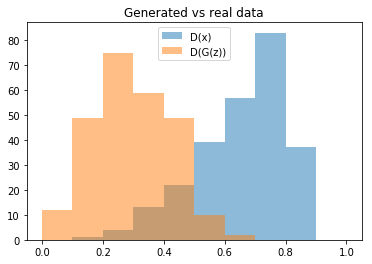

Time for epoch 1062 is 77.35947009921074 min
error D: 0.8184630274772644, error G: -0.45458105206489563
Time for epoch 1063 is 77.42469959706068 min
error D: 0.8723919987678528, error G: -0.41231292486190796
Time for epoch 1064 is 77.48934691399336 min
error D: 0.8724390864372253, error G: -0.5052309036254883
Time for epoch 1065 is 77.55348503217101 min
error D: 0.9873657822608948, error G: -0.339793860912323
Time for epoch 1066 is 77.61765333637595 min
error D: 1.1644227504730225, error G: -0.8908488750457764
Time for epoch 1067 is 77.68530088290572 min
error D: 1.0530325174331665, error G: -0.3225209712982178
Time for epoch 1068 is 77.75153924524784 min
error D: 1.277647852897644, error G: -0.990322470664978
Time for epoch 1069 is 77.81767008081079 min
error D: 1.1649409532546997, error G: -0.2948514223098755
Time for epoch 1070 is 77.88223265111446 min
error D: 1.2469813823699951, error G: -0.9074015617370605
Time for epoch 1071 is 77.94708016887307 min
error D: 1.1949468851089478, 

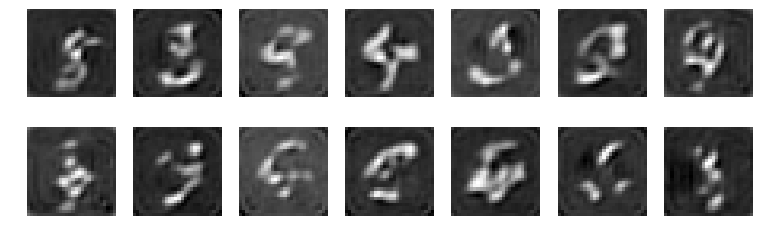

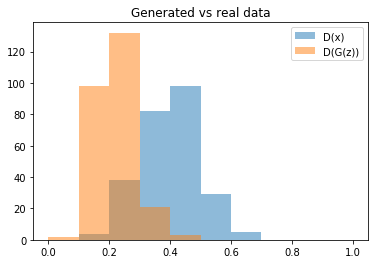

Time for epoch 1072 is 78.03696230053902 min
error D: 1.256519079208374, error G: -0.965430498123169
Time for epoch 1073 is 78.10160890221596 min
error D: 1.1300134658813477, error G: -0.23411116003990173
Time for epoch 1074 is 78.16877259686589 min
error D: 1.1992653608322144, error G: -0.9264620542526245
Time for epoch 1075 is 78.23398264870048 min
error D: 1.1270596981048584, error G: -0.19158896803855896
Time for epoch 1076 is 78.29802864789963 min
error D: 1.0890605449676514, error G: -0.7977983951568604
Time for epoch 1077 is 78.36304519698024 min
error D: 1.027827501296997, error G: -0.22784742712974548
Time for epoch 1078 is 78.42772934958339 min
error D: 1.026940107345581, error G: -0.7399476170539856
Time for epoch 1079 is 78.49229951575398 min
error D: 0.983496904373169, error G: -0.22715184092521667
Time for epoch 1080 is 78.55595871806145 min
error D: 0.9702960848808289, error G: -0.6695314645767212
Time for epoch 1081 is 78.62081818282604 min
error D: 1.0101696252822876, 

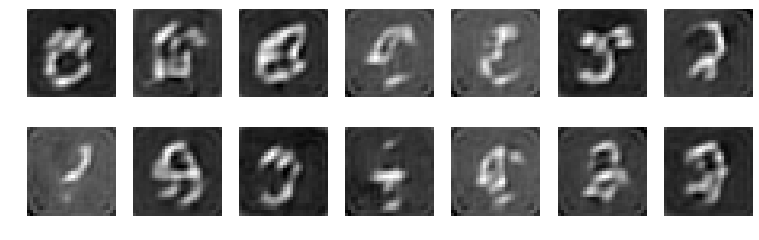

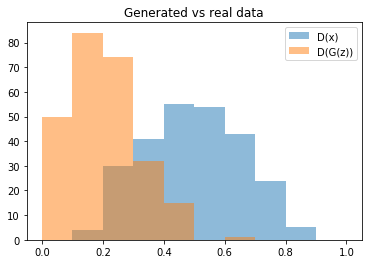

Time for epoch 1082 is 78.71135693416 min
error D: 1.10166335105896, error G: -0.8376003503799438
Time for epoch 1083 is 78.77594608068466 min
error D: 1.028916597366333, error G: -0.27579545974731445
Time for epoch 1084 is 78.8397504799068 min
error D: 1.134268045425415, error G: -0.8123775720596313
Time for epoch 1085 is 78.90424606576562 min
error D: 1.1343300342559814, error G: -0.30854928493499756
Time for epoch 1086 is 78.96834686398506 min
error D: 1.2091429233551025, error G: -0.8779901266098022
Time for epoch 1087 is 79.03431263193488 min
error D: 1.1783486604690552, error G: -0.36640870571136475
Time for epoch 1088 is 79.09871689975262 min
error D: 1.284642219543457, error G: -0.922997236251831
Time for epoch 1089 is 79.1629595644772 min
error D: 1.2637523412704468, error G: -0.43633797764778137
Time for epoch 1090 is 79.22896259650588 min
error D: 1.2571194171905518, error G: -0.8791268467903137
Time for epoch 1091 is 79.29377596452832 min
error D: 1.2265678644180298, error 

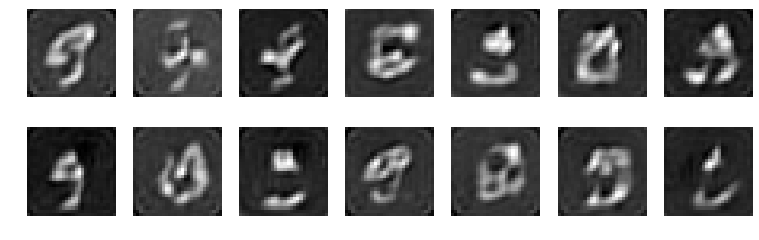

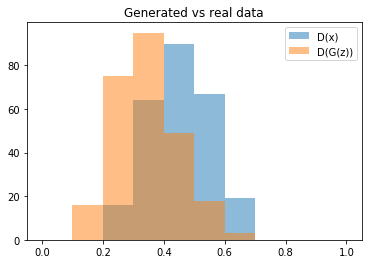

Time for epoch 1092 is 79.38387036696076 min
error D: 1.1935681104660034, error G: -0.8471862077713013
Time for epoch 1093 is 79.44864891469479 min
error D: 1.1513270139694214, error G: -0.40847939252853394
Time for epoch 1094 is 79.51364383473992 min
error D: 1.0776114463806152, error G: -0.6782852411270142
Time for epoch 1095 is 79.57849634811282 min
error D: 1.0388429164886475, error G: -0.4178783893585205
Time for epoch 1096 is 79.64353226870298 min
error D: 1.013525128364563, error G: -0.6124109029769897
Time for epoch 1097 is 79.71228642761707 min
error D: 0.9807393550872803, error G: -0.41946136951446533
Time for epoch 1098 is 79.77682661637664 min
error D: 0.9866134524345398, error G: -0.5956748127937317
Time for epoch 1099 is 79.84102354943752 min
error D: 0.9804908633232117, error G: -0.43431079387664795
Time for epoch 1100 is 79.90560143440962 min
error D: 0.9983913898468018, error G: -0.5932166576385498
Time for epoch 1101 is 79.97046064585447 min
error D: 0.980948686599731

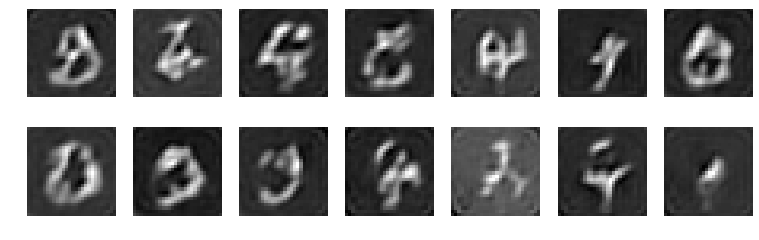

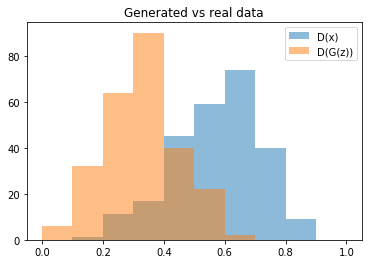

Time for epoch 1102 is 80.07422586157918 min
error D: 1.0236836671829224, error G: -0.6896026134490967
Time for epoch 1103 is 80.15082500129938 min
error D: 1.081262469291687, error G: -0.3794548511505127
Time for epoch 1104 is 80.2268506474793 min
error D: 1.226548194885254, error G: -0.9080531597137451
Time for epoch 1105 is 80.30503496527672 min
error D: 1.124456524848938, error G: -0.33282339572906494
Time for epoch 1106 is 80.37822196632624 min
error D: 1.3301914930343628, error G: -0.9993634223937988
Time for epoch 1107 is 80.44187701120973 min
error D: 1.1222463846206665, error G: -0.3294803202152252
Time for epoch 1108 is 80.51151084899902 min
error D: 1.2878468036651611, error G: -0.9423924684524536
Time for epoch 1109 is 80.5853516496718 min
error D: 1.1173045635223389, error G: -0.2970150113105774
Time for epoch 1110 is 80.6609823293984 min
error D: 1.2399225234985352, error G: -0.9578312039375305
Time for epoch 1111 is 80.74503049999475 min
error D: 1.093634843826294, error

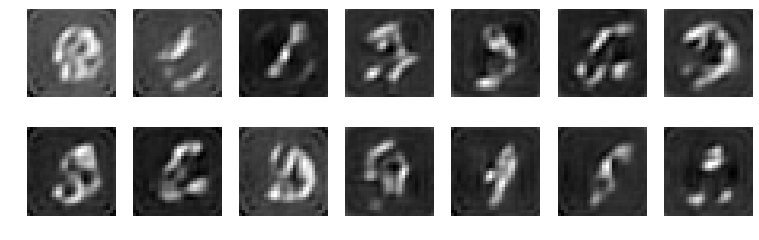

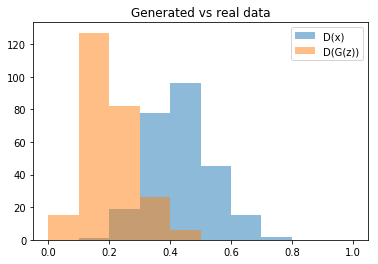

Time for epoch 1112 is 80.87442810088396 min
error D: 1.0846068859100342, error G: -0.7647636532783508
Time for epoch 1113 is 80.94694536551833 min
error D: 1.0573930740356445, error G: -0.2072392702102661
Time for epoch 1114 is 81.043193500489 min
error D: 1.0168825387954712, error G: -0.716103196144104
Time for epoch 1115 is 81.12958079949021 min
error D: 0.9943214058876038, error G: -0.22859369218349457
Time for epoch 1116 is 81.2349359691143 min
error D: 1.0882762670516968, error G: -0.8097506165504456
Time for epoch 1117 is 81.3088768273592 min
error D: 0.9345985054969788, error G: -0.24954666197299957
Time for epoch 1118 is 81.38121183216572 min
error D: 1.073428750038147, error G: -0.804308295249939
Time for epoch 1119 is 81.45131746679544 min
error D: 1.0004768371582031, error G: -0.29802405834198
Time for epoch 1120 is 81.54717621579766 min
error D: 1.2294881343841553, error G: -0.9593403339385986
Time for epoch 1121 is 81.6398355960846 min
error D: 1.1424572467803955, error G

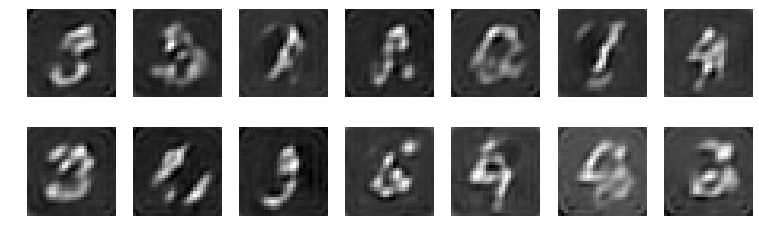

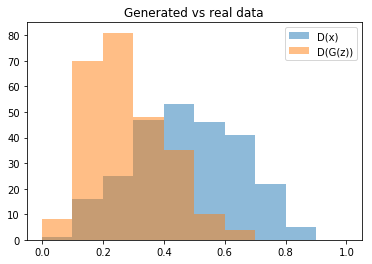

Time for epoch 1122 is 81.74682633206248 min
error D: 1.3400248289108276, error G: -1.0490334033966064
Time for epoch 1123 is 81.83021407946944 min
error D: 1.252726674079895, error G: -0.34333670139312744
Time for epoch 1124 is 81.91188710182905 min
error D: 1.410075306892395, error G: -1.107363224029541
Time for epoch 1125 is 81.99571213498712 min
error D: 1.238823652267456, error G: -0.3813510537147522
Time for epoch 1126 is 82.06631146743894 min
error D: 1.3148881196975708, error G: -0.9863477945327759
Time for epoch 1127 is 82.13440883159637 min
error D: 1.252528429031372, error G: -0.3519325256347656
Time for epoch 1128 is 82.21040445193648 min
error D: 1.187737226486206, error G: -0.8297423124313354
Time for epoch 1129 is 82.28024272993207 min
error D: 1.0920087099075317, error G: -0.3735900819301605
Time for epoch 1130 is 82.34630499780178 min
error D: 1.057448387145996, error G: -0.6667293310165405
Time for epoch 1131 is 82.43304544687271 min
error D: 0.9712830185890198, error

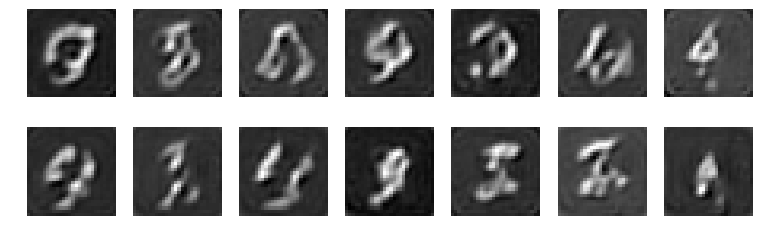

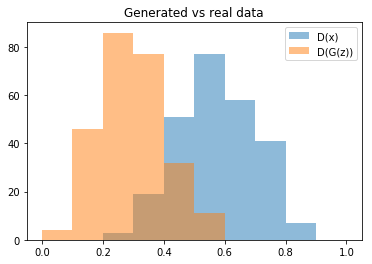

Time for epoch 1132 is 82.53974521532655 min
error D: 0.9795235991477966, error G: -0.616348385810852
Time for epoch 1133 is 82.6165223158896 min
error D: 0.9470205307006836, error G: -0.36567264795303345
Time for epoch 1134 is 82.69114547967911 min
error D: 0.9341492652893066, error G: -0.5893522500991821
Time for epoch 1135 is 82.77095237001777 min
error D: 0.9546845555305481, error G: -0.36722123622894287
Time for epoch 1136 is 82.83630429953337 min
error D: 1.0696380138397217, error G: -0.7483657598495483
Time for epoch 1137 is 82.90198422968388 min
error D: 1.0171927213668823, error G: -0.35277074575424194
Time for epoch 1138 is 82.96963718160987 min
error D: 1.244242548942566, error G: -0.9499902725219727
Time for epoch 1139 is 83.0377157330513 min
error D: 1.1283034086227417, error G: -0.361265629529953
Time for epoch 1140 is 83.10315016657114 min
error D: 1.249000072479248, error G: -0.9025801420211792
Time for epoch 1141 is 83.16750686243176 min
error D: 1.1840436458587646, er

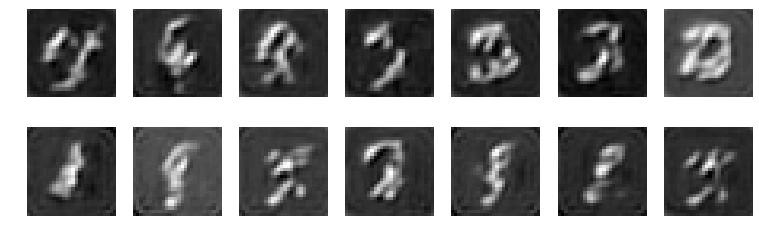

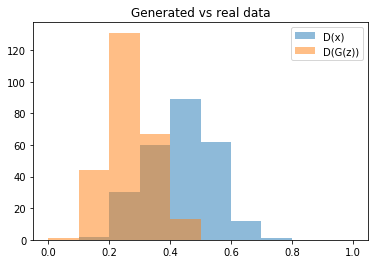

Time for epoch 1142 is 83.26756333187222 min
error D: 1.2868306636810303, error G: -0.9360765814781189
Time for epoch 1143 is 83.3417424634099 min
error D: 1.213183879852295, error G: -0.2635832726955414
Time for epoch 1144 is 83.4086640290916 min
error D: 1.2454971075057983, error G: -0.9342179894447327
Time for epoch 1145 is 83.48181876540184 min
error D: 1.1822068691253662, error G: -0.2221885621547699
Time for epoch 1146 is 83.55330991372466 min
error D: 1.15506911277771, error G: -0.8616063594818115
Time for epoch 1147 is 83.61924923211336 min
error D: 1.0979046821594238, error G: -0.1912490725517273
Time for epoch 1148 is 83.69214170053601 min
error D: 1.0091421604156494, error G: -0.7197385430335999
Time for epoch 1149 is 83.76419126614928 min
error D: 0.9321154952049255, error G: -0.19423304498195648
Time for epoch 1150 is 83.83143928647041 min
error D: 0.9590848088264465, error G: -0.6779062151908875
Time for epoch 1151 is 83.89784123003483 min
error D: 0.9327008724212646, err

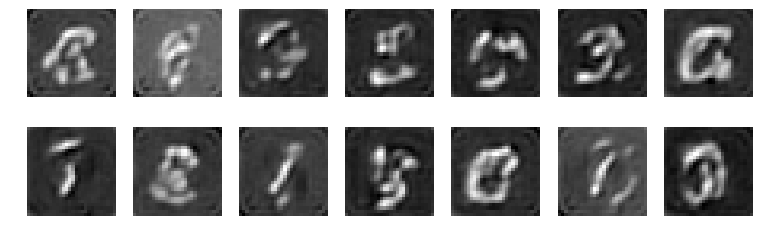

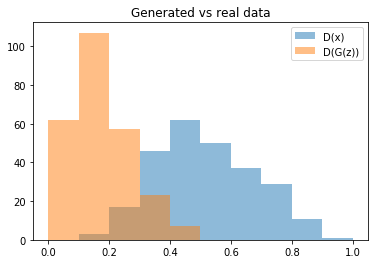

Time for epoch 1152 is 83.98981781303883 min
error D: 0.8987436890602112, error G: -0.6045308113098145
Time for epoch 1153 is 84.05531976744533 min
error D: 0.9024431109428406, error G: -0.252252995967865
Time for epoch 1154 is 84.12206296250224 min
error D: 0.9336540699005127, error G: -0.6290193200111389
Time for epoch 1155 is 84.18831638246775 min
error D: 0.9895253777503967, error G: -0.2865000367164612
Time for epoch 1156 is 84.25422406196594 min
error D: 1.1264132261276245, error G: -0.8273775577545166
Time for epoch 1157 is 84.31890735030174 min
error D: 1.1226392984390259, error G: -0.3220590651035309
Time for epoch 1158 is 84.387675113976 min
error D: 1.1573935747146606, error G: -0.7981120944023132
Time for epoch 1159 is 84.45747714862227 min
error D: 1.1876194477081299, error G: -0.3779275417327881
Time for epoch 1160 is 84.52566253393888 min
error D: 1.296433448791504, error G: -0.997118353843689
Time for epoch 1161 is 84.59301308169961 min
error D: 1.2520053386688232, erro

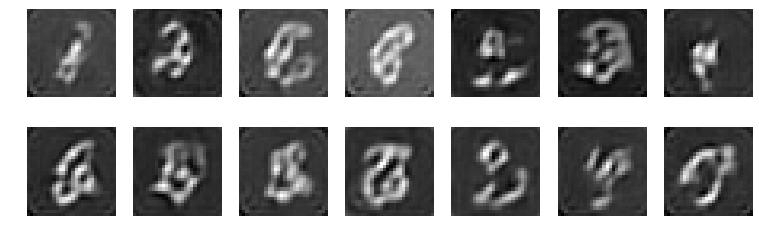

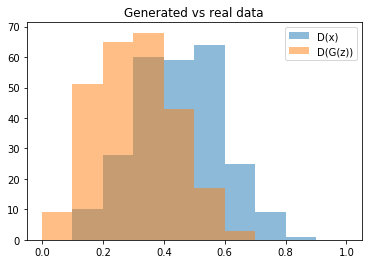

Time for epoch 1162 is 84.68934408202767 min
error D: 1.357930064201355, error G: -1.0261751413345337
Time for epoch 1163 is 84.76045921444893 min
error D: 1.232735514640808, error G: -0.4111403822898865
Time for epoch 1164 is 84.82494761422276 min
error D: 1.1550246477127075, error G: -0.7830055952072144
Time for epoch 1165 is 84.89136818423867 min
error D: 1.1222434043884277, error G: -0.4462568163871765
Time for epoch 1166 is 84.95913689956069 min
error D: 1.1015301942825317, error G: -0.7185336351394653
Time for epoch 1167 is 85.02570254728198 min
error D: 1.064780592918396, error G: -0.437203586101532
Time for epoch 1168 is 85.0945751145482 min
error D: 1.0230154991149902, error G: -0.5857623219490051
Time for epoch 1169 is 85.17408768087626 min
error D: 1.0180209875106812, error G: -0.4945591986179352
Time for epoch 1170 is 85.25260837748647 min
error D: 1.0276916027069092, error G: -0.5145469903945923
Time for epoch 1171 is 85.329838629812 min
error D: 1.063508152961731, error G

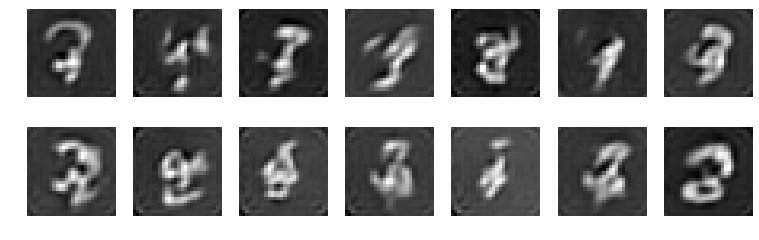

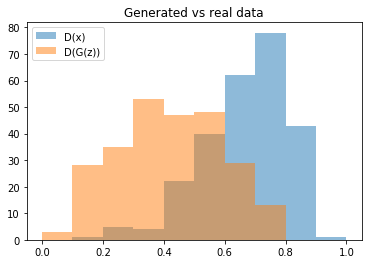

Time for epoch 1172 is 85.43637198209763 min
error D: 1.0844433307647705, error G: -0.4204597473144531
Time for epoch 1173 is 85.51360681653023 min
error D: 1.2156370878219604, error G: -0.8344051837921143
Time for epoch 1174 is 85.59113136678934 min
error D: 1.097702980041504, error G: -0.4054795801639557
Time for epoch 1175 is 85.67429134994745 min
error D: 1.3554056882858276, error G: -0.9740177989006042
Time for epoch 1176 is 85.75473177805543 min
error D: 1.2219784259796143, error G: -0.4207215905189514
Time for epoch 1177 is 85.8346255980432 min
error D: 1.4169753789901733, error G: -1.0444806814193726
Time for epoch 1178 is 85.90609992668033 min
error D: 1.3046815395355225, error G: -0.3207225203514099
Time for epoch 1179 is 85.98648566380143 min
error D: 1.3748072385787964, error G: -1.0078810453414917
Time for epoch 1180 is 86.065225366503 min
error D: 1.2681188583374023, error G: -0.23494067788124084
Time for epoch 1181 is 86.14221864938736 min
error D: 1.2942430973052979, er

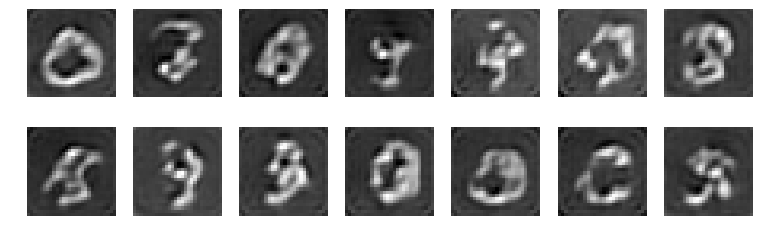

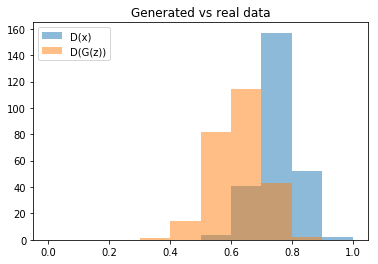

Time for epoch 1182 is 86.24735223129392 min
error D: 1.105644702911377, error G: -0.21833506226539612
Time for epoch 1183 is 86.3253423832357 min
error D: 1.1284862756729126, error G: -0.8522257804870605
Time for epoch 1184 is 86.39311848208308 min
error D: 0.9654459953308105, error G: -0.2080201804637909
Time for epoch 1185 is 86.45757161453366 min
error D: 1.011700987815857, error G: -0.7502233386039734
Time for epoch 1186 is 86.52094248309731 min
error D: 0.8746509552001953, error G: -0.2195788025856018
Time for epoch 1187 is 86.58470904827118 min
error D: 0.9610639214515686, error G: -0.6922240257263184
Time for epoch 1188 is 86.65810644999146 min
error D: 0.8985896706581116, error G: -0.26336127519607544
Time for epoch 1189 is 86.75385278463364 min
error D: 0.9397485256195068, error G: -0.6575120687484741
Time for epoch 1190 is 86.84889848157763 min
error D: 0.983502209186554, error G: -0.27297884225845337
Time for epoch 1191 is 86.93217424675822 min
error D: 1.0035713911056519, 

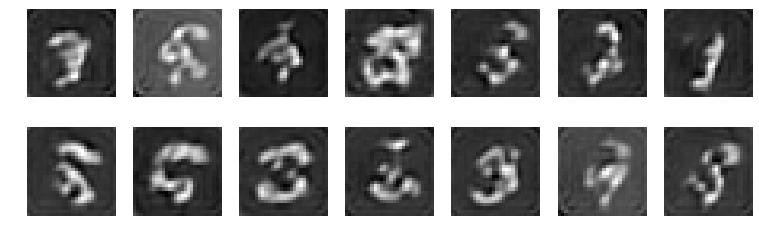

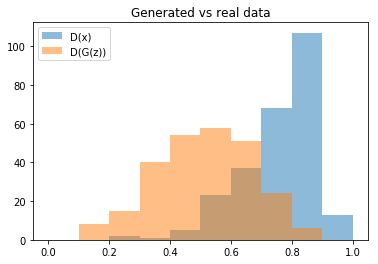

Time for epoch 1192 is 87.04989150166512 min
error D: 1.046860933303833, error G: -0.31435567140579224
Time for epoch 1193 is 87.11725058034062 min
error D: 1.06407630443573, error G: -0.7664225101470947
Time for epoch 1194 is 87.18698750063777 min
error D: 1.0333348512649536, error G: -0.342647910118103
Time for epoch 1195 is 87.25931601598859 min
error D: 1.2221306562423706, error G: -0.9405931830406189
Time for epoch 1196 is 87.34509211406112 min
error D: 1.1838728189468384, error G: -0.37406158447265625
Time for epoch 1197 is 87.43558141589165 min
error D: 1.2892335653305054, error G: -1.006034016609192
Time for epoch 1198 is 87.50792184844613 min
error D: 1.123896837234497, error G: -0.3703150749206543
Time for epoch 1199 is 87.59776836633682 min
error D: 1.1461842060089111, error G: -0.8322702646255493
Time for epoch 1200 is 87.68152644857764 min
error D: 1.0786712169647217, error G: -0.3703143000602722
Time for epoch 1201 is 87.7787789478898 min
error D: 1.0206154584884644, erro

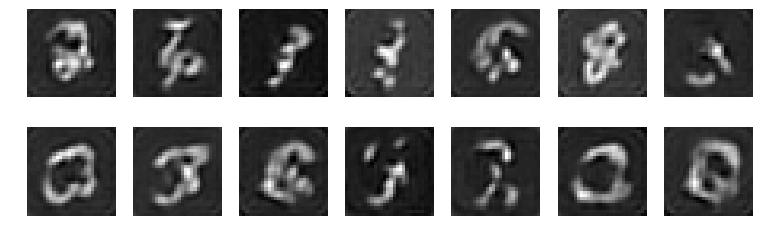

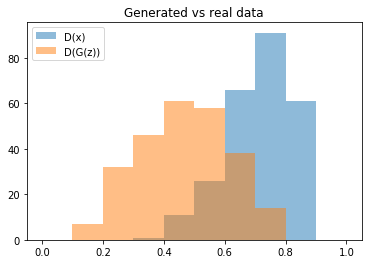

Time for epoch 1202 is 87.87895674631 min
error D: 0.9560590982437134, error G: -0.351068913936615
Time for epoch 1203 is 87.94641583412886 min
error D: 0.958988606929779, error G: -0.604293704032898
Time for epoch 1204 is 88.02068521082401 min
error D: 0.9130758047103882, error G: -0.40229132771492004
Time for epoch 1205 is 88.09356863051653 min
error D: 0.934402346611023, error G: -0.5472359657287598
Time for epoch 1206 is 88.1652230322361 min
error D: 0.9714124202728271, error G: -0.45856040716171265
Time for epoch 1207 is 88.24702376499772 min
error D: 0.9778501391410828, error G: -0.5316793918609619
Time for epoch 1208 is 88.32217217981815 min
error D: 0.9966285824775696, error G: -0.3740571439266205
Time for epoch 1209 is 88.39030593261123 min
error D: 1.2447212934494019, error G: -0.9605497121810913
Time for epoch 1210 is 88.45926831290126 min
error D: 1.103593349456787, error G: -0.3340057134628296
Time for epoch 1211 is 88.52554928138852 min
error D: 1.2664045095443726, error 

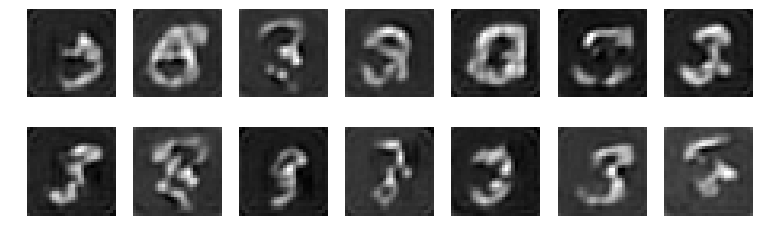

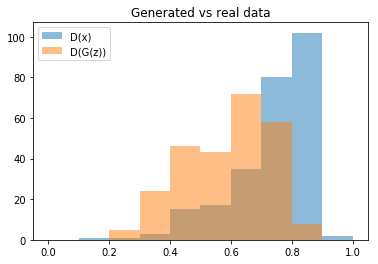

Time for epoch 1212 is 88.61863522976637 min
error D: 1.2284750938415527, error G: -0.3133707046508789
Time for epoch 1213 is 88.68735721707344 min
error D: 1.345718502998352, error G: -1.0391228199005127
Time for epoch 1214 is 88.7566948980093 min
error D: 1.2581894397735596, error G: -0.2915116846561432
Time for epoch 1215 is 88.82183618098497 min
error D: 1.4001119136810303, error G: -1.065618634223938
Time for epoch 1216 is 88.89138836413622 min
error D: 1.3071613311767578, error G: -0.23077793419361115
Time for epoch 1217 is 88.95786981657147 min
error D: 1.2489216327667236, error G: -0.9296897649765015
Time for epoch 1218 is 89.03122936561704 min
error D: 1.144403338432312, error G: -0.2449013590812683
Time for epoch 1219 is 89.10119014978409 min
error D: 1.217042088508606, error G: -0.947691798210144
Time for epoch 1220 is 89.16844731196761 min
error D: 1.069629430770874, error G: -0.22714023292064667
Time for epoch 1221 is 89.2400120832026 min
error D: 1.083632230758667, error 

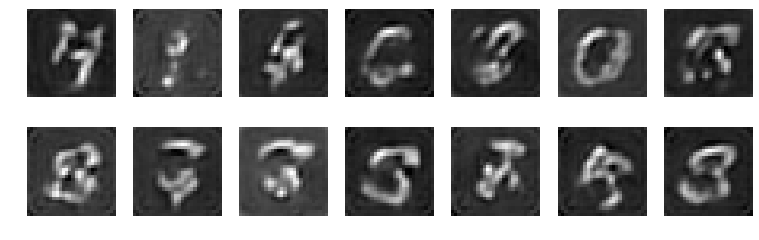

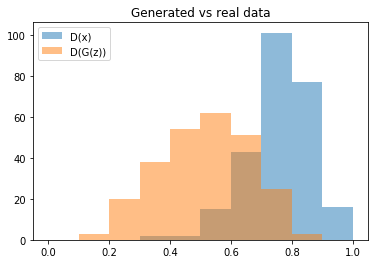

Time for epoch 1222 is 89.34301939606667 min
error D: 1.099025845527649, error G: -0.19801679253578186
Time for epoch 1223 is 89.41169121488929 min
error D: 1.1676634550094604, error G: -0.9170600175857544
Time for epoch 1224 is 89.48432154580951 min
error D: 1.0014718770980835, error G: -0.25817060470581055
Time for epoch 1225 is 89.55178853496909 min
error D: 1.2690610885620117, error G: -1.0353193283081055
Time for epoch 1226 is 89.6224380992353 min
error D: 1.0541560649871826, error G: -0.30090367794036865
Time for epoch 1227 is 89.69654018059373 min
error D: 1.1995422840118408, error G: -0.8850744962692261
Time for epoch 1228 is 89.76791091635823 min
error D: 1.1441468000411987, error G: -0.3003196120262146
Time for epoch 1229 is 89.83431501686573 min
error D: 1.2625998258590698, error G: -0.9397423267364502
Time for epoch 1230 is 89.9016547948122 min
error D: 1.2250946760177612, error G: -0.3548775911331177
Time for epoch 1231 is 89.97183951362967 min
error D: 1.2590175867080688,

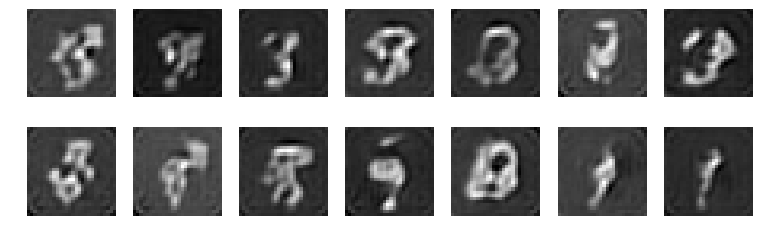

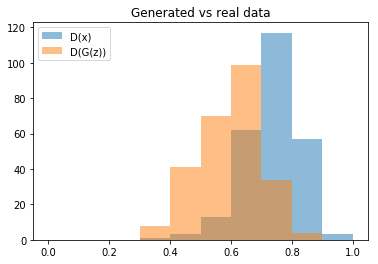

Time for epoch 1232 is 90.06642101332545 min
error D: 1.2103615999221802, error G: -0.38075676560401917
Time for epoch 1233 is 90.13553239777684 min
error D: 1.208274245262146, error G: -0.8600295782089233
Time for epoch 1234 is 90.2035412825644 min
error D: 1.125464677810669, error G: -0.3648033142089844
Time for epoch 1235 is 90.26840476691723 min
error D: 1.1392649412155151, error G: -0.7960208654403687
Time for epoch 1236 is 90.33383224904537 min
error D: 1.0534083843231201, error G: -0.3529866635799408
Time for epoch 1237 is 90.39759601280093 min
error D: 0.9935466051101685, error G: -0.6485052704811096
Time for epoch 1238 is 90.46188114956021 min
error D: 0.9730002880096436, error G: -0.3768155574798584
Time for epoch 1239 is 90.52615864574909 min
error D: 1.023607850074768, error G: -0.653374195098877
Time for epoch 1240 is 90.58959491178393 min
error D: 1.0229655504226685, error G: -0.38265860080718994
Time for epoch 1241 is 90.65488008409739 min
error D: 1.1099885702133179, er

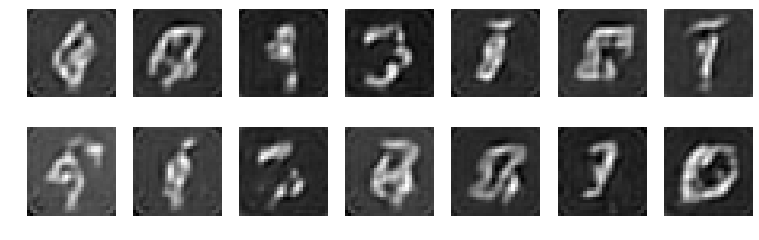

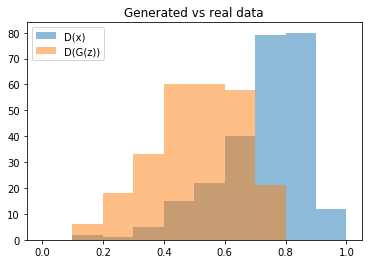

Time for epoch 1242 is 90.75009583309293 min
error D: 1.1736836433410645, error G: -0.35506147146224976
Time for epoch 1243 is 90.87158593535423 min
error D: 1.3045012950897217, error G: -0.948845386505127
Time for epoch 1244 is 90.9396421648562 min
error D: 1.2528491020202637, error G: -0.34475117921829224
Time for epoch 1245 is 91.02046560123563 min
error D: 1.4072283506393433, error G: -1.0682916641235352
Time for epoch 1246 is 91.10049041733146 min
error D: 1.2672429084777832, error G: -0.34339290857315063
Time for epoch 1247 is 91.1863192692399 min
error D: 1.4342916011810303, error G: -1.091031551361084
Time for epoch 1248 is 91.28204784914851 min
error D: 1.3243584632873535, error G: -0.3211069107055664
Time for epoch 1249 is 91.37032171711326 min
error D: 1.4189403057098389, error G: -1.1012661457061768
Time for epoch 1250 is 91.44605883583426 min
error D: 1.2378582954406738, error G: -0.28634771704673767
Time for epoch 1251 is 91.52010595053434 min
error D: 1.231797695159912, 

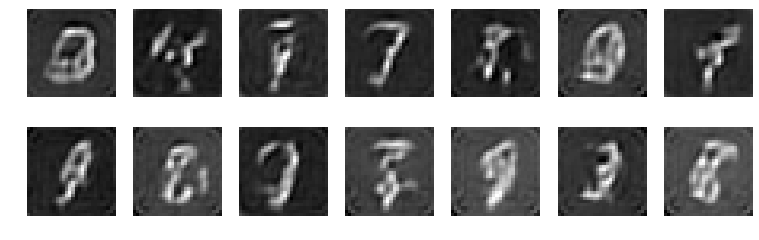

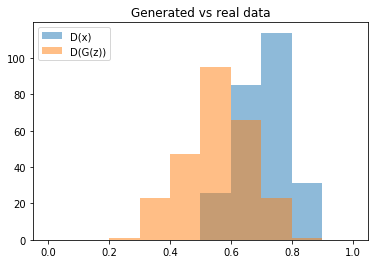

Time for epoch 1252 is 91.6288284137845 min
error D: 1.0799791812896729, error G: -0.23385700583457947
Time for epoch 1253 is 91.71280914917588 min
error D: 1.1991280317306519, error G: -0.9036498069763184
Time for epoch 1254 is 91.80680976808071 min
error D: 1.0237109661102295, error G: -0.23794949054718018
Time for epoch 1255 is 91.90141834691167 min
error D: 1.1367030143737793, error G: -0.8713647127151489
Time for epoch 1256 is 91.99514766409993 min
error D: 1.0247663259506226, error G: -0.2532860040664673
Time for epoch 1257 is 92.08238685131073 min
error D: 1.1354529857635498, error G: -0.8452861905097961
Time for epoch 1258 is 92.16093968227506 min
error D: 1.0536936521530151, error G: -0.2871466279029846
Time for epoch 1259 is 92.25846108421683 min
error D: 1.1912192106246948, error G: -0.9012829065322876
Time for epoch 1260 is 92.34484427794814 min
error D: 1.0263879299163818, error G: -0.314169317483902
Time for epoch 1261 is 92.41705768182874 min
error D: 1.2180330753326416,

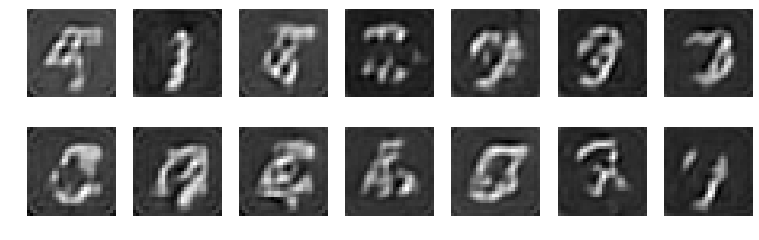

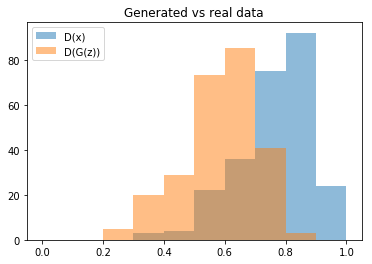

Time for epoch 1262 is 92.52816586568952 min
error D: 1.1248700618743896, error G: -0.34000077843666077
Time for epoch 1263 is 92.61564948037267 min
error D: 1.2644091844558716, error G: -0.972664475440979
Time for epoch 1264 is 92.69903701171279 min
error D: 1.2076088190078735, error G: -0.34255096316337585
Time for epoch 1265 is 92.79539188370109 min
error D: 1.2410389184951782, error G: -0.9403634071350098
Time for epoch 1266 is 92.87184136360884 min
error D: 1.1178131103515625, error G: -0.35662543773651123
Time for epoch 1267 is 92.94000116735697 min
error D: 1.0797358751296997, error G: -0.7650416493415833
Time for epoch 1268 is 93.00906238332391 min
error D: 1.0057778358459473, error G: -0.3326883912086487
Time for epoch 1269 is 93.08763904869556 min
error D: 0.9797008633613586, error G: -0.6573684215545654
Time for epoch 1270 is 93.17569030076265 min
error D: 0.9416372776031494, error G: -0.3383176624774933
Time for epoch 1271 is 93.24136788025498 min
error D: 0.899122536182403

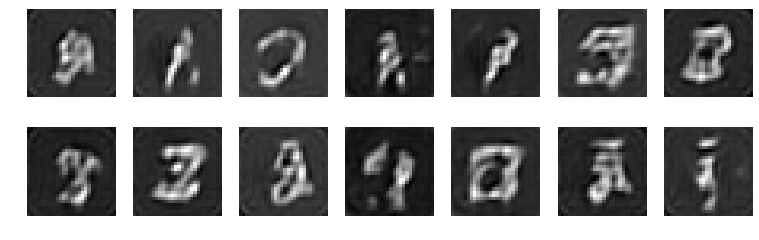

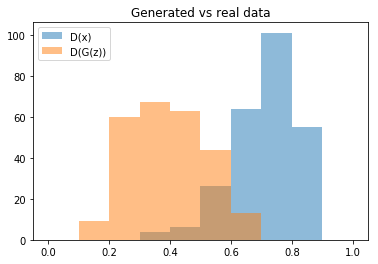

Time for epoch 1272 is 93.33640943467617 min
error D: 0.9090823531150818, error G: -0.33470064401626587
Time for epoch 1273 is 93.40092182904482 min
error D: 0.9465980529785156, error G: -0.635879635810852
Time for epoch 1274 is 93.46490858495235 min
error D: 0.8829604983329773, error G: -0.3405170142650604
Time for epoch 1275 is 93.53060799837112 min
error D: 0.948242723941803, error G: -0.650702953338623
Time for epoch 1276 is 93.59471339732409 min
error D: 0.9948979020118713, error G: -0.33414679765701294
Time for epoch 1277 is 93.66301552951336 min
error D: 1.1226081848144531, error G: -0.822745680809021
Time for epoch 1278 is 93.7323730327189 min
error D: 1.0916855335235596, error G: -0.3550707697868347
Time for epoch 1279 is 93.80933975055814 min
error D: 1.2126545906066895, error G: -0.8689489364624023
Time for epoch 1280 is 93.88391396775842 min
error D: 1.147580623626709, error G: -0.3295503854751587
Time for epoch 1281 is 93.9578077159822 min
error D: 1.2592511177062988, erro

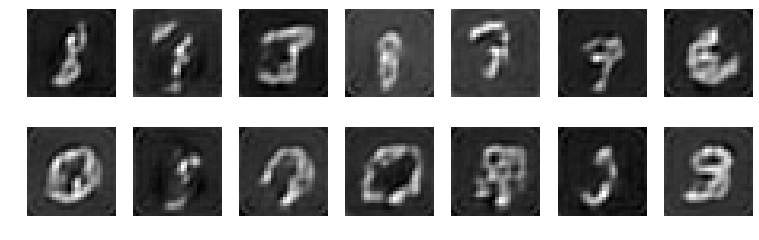

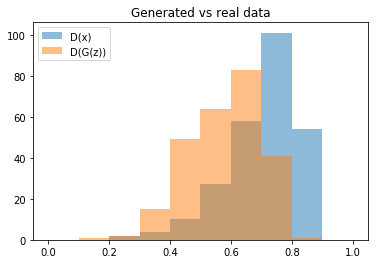

Time for epoch 1282 is 94.05869869887829 min
error D: 1.2377523183822632, error G: -0.3014945983886719
Time for epoch 1283 is 94.13286937773228 min
error D: 1.3161453008651733, error G: -0.9773468971252441
Time for epoch 1284 is 94.20868226885796 min
error D: 1.2277629375457764, error G: -0.2710292339324951
Time for epoch 1285 is 94.30633448064327 min
error D: 1.3241738080978394, error G: -1.0170332193374634
Time for epoch 1286 is 94.37521356344223 min
error D: 1.2168734073638916, error G: -0.22580812871456146
Time for epoch 1287 is 94.43948291614652 min
error D: 1.133123517036438, error G: -0.8236027956008911
Time for epoch 1288 is 94.50371729955077 min
error D: 1.192155361175537, error G: -0.21352650225162506
Time for epoch 1289 is 94.56811803206801 min
error D: 1.1937363147735596, error G: -0.8810156583786011
Time for epoch 1290 is 94.63174169883132 min
error D: 1.15427565574646, error G: -0.25468501448631287
Time for epoch 1291 is 94.69664734601974 min
error D: 1.1765295267105103, 

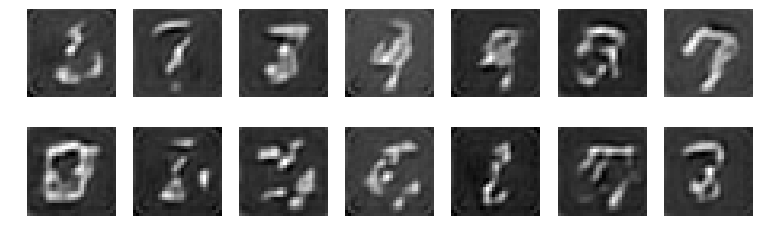

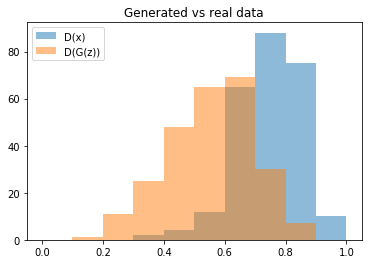

Time for epoch 1292 is 94.78679931163788 min
error D: 1.1829675436019897, error G: -0.25941622257232666
Time for epoch 1293 is 94.85128351673484 min
error D: 1.2574129104614258, error G: -0.9549658298492432
Time for epoch 1294 is 94.91664069890976 min
error D: 1.185705304145813, error G: -0.3190372586250305
Time for epoch 1295 is 94.98182194679976 min
error D: 1.2932718992233276, error G: -0.9703099727630615
Time for epoch 1296 is 95.04621034488082 min
error D: 1.2285974025726318, error G: -0.34172770380973816
Time for epoch 1297 is 95.10987436398864 min
error D: 1.3608781099319458, error G: -1.048259973526001
Time for epoch 1298 is 95.17454836517572 min
error D: 1.2367230653762817, error G: -0.3602902889251709
Time for epoch 1299 is 95.2392612658441 min
error D: 1.2797565460205078, error G: -0.9288113117218018
Time for epoch 1300 is 95.30498586595058 min
error D: 1.1982698440551758, error G: -0.3463709354400635
Time for epoch 1301 is 95.37072856351733 min
error D: 1.1557831764221191, 

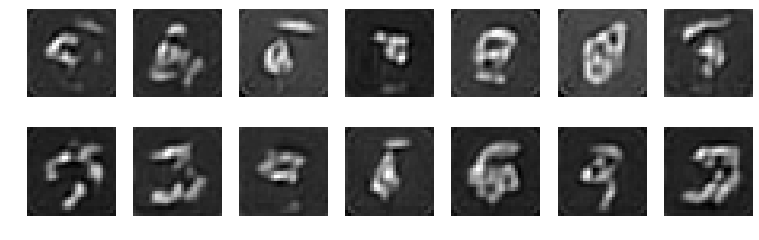

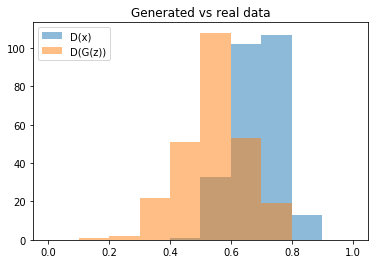

Time for epoch 1302 is 95.46168189868331 min
error D: 1.12366783618927, error G: -0.321159303188324
Time for epoch 1303 is 95.52613712847233 min
error D: 1.0691215991973877, error G: -0.6919234991073608
Time for epoch 1304 is 95.59089408069849 min
error D: 1.0109214782714844, error G: -0.3539631962776184
Time for epoch 1305 is 95.65724446251988 min
error D: 1.061728596687317, error G: -0.7324590682983398
Time for epoch 1306 is 95.72453994676471 min
error D: 0.9948496222496033, error G: -0.3553505539894104
Time for epoch 1307 is 95.7885192334652 min
error D: 0.9683283567428589, error G: -0.611132025718689
Time for epoch 1308 is 95.85276716202497 min
error D: 1.028672218322754, error G: -0.355644166469574
Time for epoch 1309 is 95.91647941619158 min
error D: 1.0935782194137573, error G: -0.7814334630966187
Time for epoch 1310 is 95.98026511445642 min
error D: 1.063370943069458, error G: -0.3336963653564453
Time for epoch 1311 is 96.04397404938936 min
error D: 1.15640127658844, error G: -

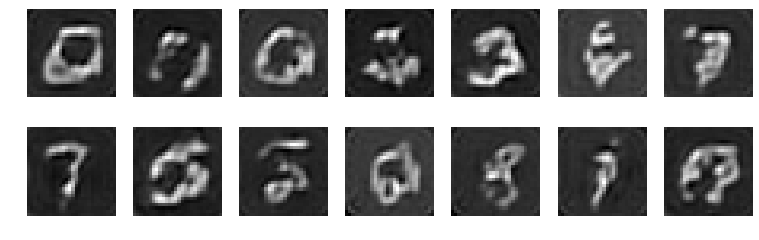

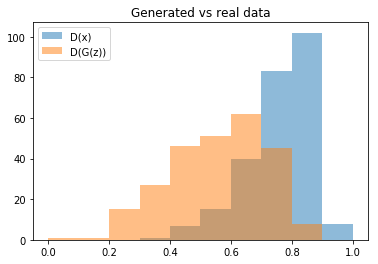

Time for epoch 1312 is 96.13354718312621 min
error D: 1.1151140928268433, error G: -0.33272963762283325
Time for epoch 1313 is 96.19699415192008 min
error D: 1.1940877437591553, error G: -0.8817375898361206
Time for epoch 1314 is 96.26432320103049 min
error D: 1.1455440521240234, error G: -0.33892542123794556
Time for epoch 1315 is 96.32855297997594 min
error D: 1.2460041046142578, error G: -0.9092974662780762
Time for epoch 1316 is 96.39407166466117 min
error D: 1.1428622007369995, error G: -0.3190891742706299
Time for epoch 1317 is 96.45989804714918 min
error D: 1.2407077550888062, error G: -0.9175909161567688
Time for epoch 1318 is 96.54005021229386 min
error D: 1.0920026302337646, error G: -0.287874698638916
Time for epoch 1319 is 96.62041421607137 min
error D: 1.1955454349517822, error G: -0.899147093296051
Time for epoch 1320 is 96.69334561377764 min
error D: 1.0752202272415161, error G: -0.28647786378860474
Time for epoch 1321 is 96.77316019684076 min
error D: 1.1820359230041504

KeyboardInterrupt: 

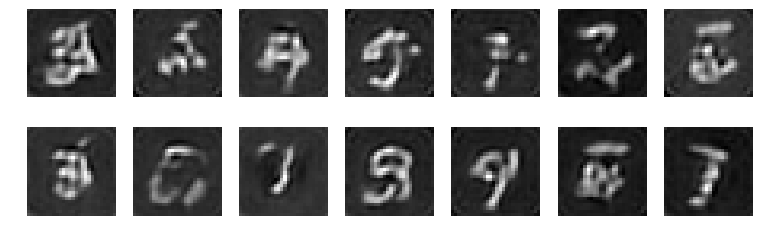

In [55]:
from IPython import display

EPOCHS = 5000
BSIZE = 256

# время
start = time.time()/60

# вектора для мониторинга сходимости сеток
d_losses = [ ]
g_losses = [ ]

num = 0 # для сохранения картинок 

# запускаем цикл обучения 
for epoch in range(EPOCHS):
    
    # генерируем батч
    X_batch = sample_data_batch(BSIZE)
    X_fake = sample_noise_batch(BSIZE)
    
    # делаем N шагов обучения дискриминатора
    for i in range(5):
        train_discriminator_step(X_batch, X_fake)
        
    # делаем K шагов обучения генератора
    for i in range(1):
        train_generator_step(X_batch, X_fake)

    gen_log = discriminator(generator(X_fake))
    real_log = discriminator(X_batch) 
    
    d_losses.append(discriminator_loss(real_log, gen_log).numpy())
    g_losses.append(generator_loss(gen_log).numpy())
        
    # ну сколько можно ждааать!!! 
    if epoch % 1==0:
        print('Time for epoch {} is {} min'.format(epoch + 1, time.time()/60-start))
        print('error D: {}, error G: {}'.format(d_losses[-1], g_losses[-1]))

    if epoch % 10==0:
        # сохраняем модель и обновляем картинку
        # checkpoint.save(file_prefix = checkpoint_prefix)

        # можно раскоментировать, если хочется, чтобы картинка обновлялась, а не дополнялас
        #display.clear_output(wait=True)
        num += 1
        sample_images(2,7, num)
        sample_probas(X_batch)

Тренируем сетки.

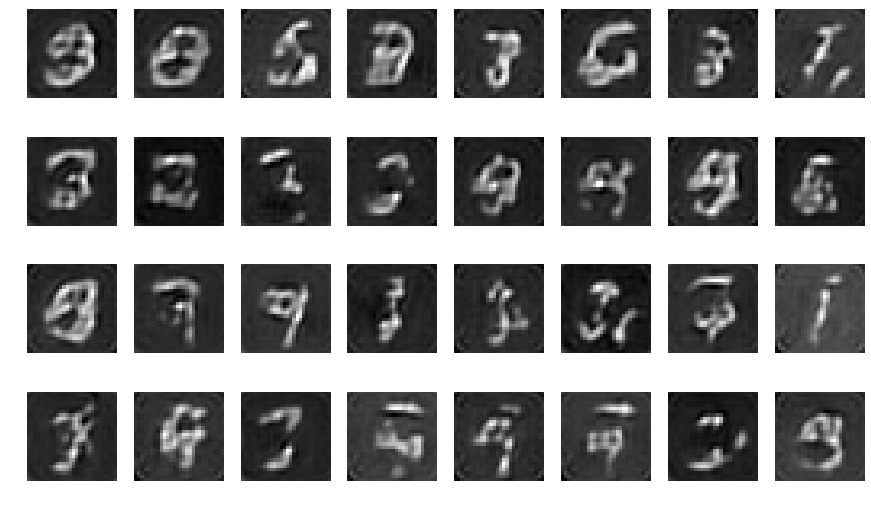

In [56]:
# сетка тренировалась много итераций
sample_images(4,8)  

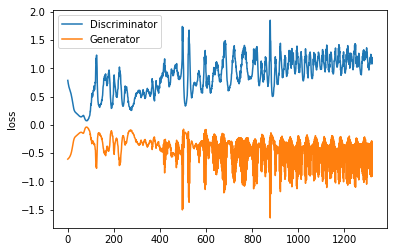

In [57]:
# смотрим сошлись ли потери
plt.plot(d_losses, label='Discriminator')
plt.plot(g_losses, label='Generator')
plt.ylabel('loss')
plt.legend();

# 7. Интерполяция 

Давайте попробуем взять два вектора, сгенерированных из нормального распределения и посмотреть как один из них перетекакет в другой. 

In [60]:
from scipy.interpolate import interp1d

def show_interp_samples(point1, point2, N_samples_interp):
    N_samples_interp_all = N_samples_interp + 2

    # линия между двумя точками
    line = interp1d([1, N_samples_interp_all], np.vstack([point1, point2]), axis=0)

    fig = plt.figure(figsize=(15,4))
    for i in range(N_samples_interp_all):
        ax = fig.add_subplot(1, 2 + N_samples_interp, i+1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(generator.predict(line(i + 1).reshape((1, 100)))[0, :, :, 0],cmap='gray')
    plt.show()
    pass

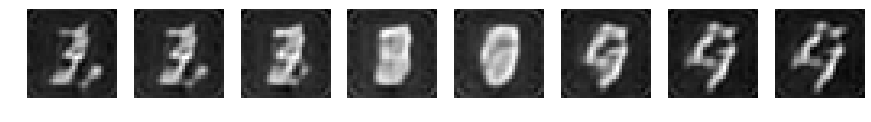

In [64]:
np.random.seed(seed=42)

# Рандомная точка в пространстве
noise_1 = np.random.normal(0, 1, (1, 100))

# смотрим как она перетекает в симметричкную
show_interp_samples(noise_1, -noise_1, 6)

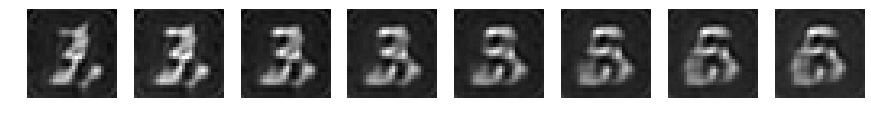

In [65]:
noise_2 = np.random.normal(0, 1, (1, 100))
show_interp_samples(noise_1, noise_2, 6)

А что мы вообще сгенерировали?! Давайте посмотрим на точку из выборки наиболее близкую к получившейся генерации.

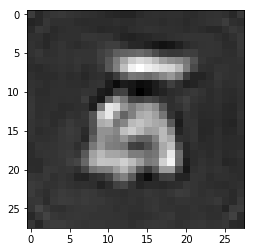

In [66]:
id_label_sample = 8
img_smp = generator.predict(sample_noise_batch(1))
plt.imshow(img_smp[0,:,:,0], cmap='gray')

In [67]:
img_smp.shape, X.shape

((1, 28, 28, 1), (60000, 28, 28, 1))

In [68]:
# ищем l1 норму между тем, что сгенерилось и остальным 
L1d = np.sum(np.sum(np.abs(X[:,:,:,0] - img_smp[:,:,:,0]), axis=1), axis=1)
idx_l1_sort = L1d.argsort()
idx_l1_sort.shape

(60000,)

In [69]:
idx_l1_sort[:5]

array([ 3919, 10440, 28678, 48398, 12088])

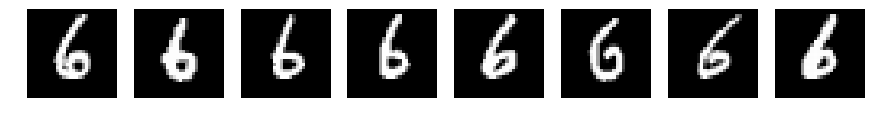

In [70]:
N_closest = 8

fig = plt.figure(figsize=(15,4))
for i in range(N_closest):
    ax = fig.add_subplot(1, N_closest, i+1)
    ax.grid('off')
    ax.axis('off')
    ax.imshow(X[idx_l1_sort[i], :, :, 0], cmap='gray')
plt.show()

Сохраняю гифку из картинок. 

In [72]:
import os
import glob
import imageio

def create_animated_gif(files, animated_gif_name, pause=0):
    if pause != 0:
        # Load the gifs up several times in the array, to slow down the animation
        frames = []
        for file in files:
            count = 0
            while count < pause:
                frames.append(file)
                count+=1
        print("Total number of frames in the animation:", len(frames))
        files = frames
    images = [imageio.imread(file) for file in files]
    imageio.mimsave(animated_gif_name, images, duration = 0.005)

In [74]:
pause = 1
animated_gif_name = 'animation_GAN.gif'

In [76]:
image_path = 'images_gan/*.png'
files = glob.glob(image_path)
files = sorted(files, key = lambda w: int(w.split('_')[-1].split('.')[0]))
create_animated_gif(files, animated_gif_name, pause)

Total number of frames in the animation: 133


# Задание на дом: 

* Превратить нашу GAN в Conditional GAN 

![](https://camo.githubusercontent.com/63a263678253a1eedd74432ad85751da2407a3d8/687474703a2f2f6775696d70657261726e61752e636f6d2f66696c65732f626c6f672f46616e7461737469632d47414e732d616e642d77686572652d746f2d66696e642d7468656d2f6347414e5f6f766572766965772e6a7067)

На этом всё :) 

![](https://miro.medium.com/max/896/1*3VOLkgm-QY05gEpGDkBzTA.gif)